El objetivo del siguiente taller es realizar una segmentación de los usuarios que participaron en la maratón de Madrid en base a las respuestas que dieron a la encuesta que se les pasó una vez finalizado el evento.

Los usuarios respondieron vía email a una serie de cuestiones que trataban de analizar su satisfacción con diversos elementos del evento, así como analizar el _engagement_ de las marcas patrocinadoras del evento con los usuarios que respondieron la encuesta. Si bien, esta segunda parte de la encuesta se omite en este trabajo.

Se trabajará únicamente con los primeros 50 campos de la encuesta, que se componen de variables que recogen una de las siguientes tres dimensiones:

- **Variables de tipo fecha:** Variables que recogen información como cuándo se inició la encuesta, cuándo se finalizó, cuándo quedó grabada en el sistema, o cuánto duró.
- **Variables de tipo demográfico:** Variables que recogen datos demográficos de los usuarios que responden la encuesta, tales como género, edad, lugar de residencia, motivación de haber participado en la carrera, tipo de evento en el que participó, etc.
- **Variables relativas a la encuesta:** Variables que recogen las puntuaciones proporcionadas por los usuarios a una serie de diferentes cuestiones, evaludas del 1 (peor puntuación) al 5 (mejor puntuación).

El índice de contenidos de este taller es el siguiente:

1. [Importar Librerías]()
2. [Preparación del Dataset]()
  - [Lectura de Datos]()
  - [Revisión Inicial de los Datos]()
  - [Limpieza de Datos]()
3. [Análisis Exploratorio de Datos (EDA)]()
4. [Selección de Variables]()
  - [Reducción de Dimensionalidad]()
5. [Aplicación de Algoritmos de Clustering]()
  - [Selección del Algoritmo de Clustering]()
  - [Determinación del Número de Clusters]()
  - [Ejecución del Algoritmo]()
6. [Interpretación y Comunicación de Resultados]()
  - [Interpretación de Clusters]()
  - [Conclusiones Finales]()


# 1. Importar Librerías

> Para persistir los datos, conectaremos Google Colab con nuestro Google Drive. Para ello:
>
> 1. Sube a tu cuenta de Google Drive la carpeta que contiene el material de este taller.
> 2. Ejecuta la siguiente celda de código.
> 3. Se te requerirá iniciar sesión en tu cuenta de Google Drive.
> 4. Inicia sesión con tu cuenta de Google Drive.
> 5. Los archivos alojados dentro de la carpeta ``/MyDrive`` de tu cuenta de Google Drive se mostrarán en la carpeta ``/content`` del Google Colab.


In [ ]:
from typing import Optional

import chardet
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import re
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import gaussian_kde, mannwhitneyu
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

# from google.colab import data_table, drive
# data_table.enable_dataframe_formatter()
# drive.mount('/content/drive')

# 2. Preparación del Dataset

## 2.1. Lectura de Datos

A continuación, leeremos los datos con los que trabajaremos en el taller y mostraremos una primera visualización de los mismos. Dado que pueden originarse problemas con el tipo de codificación utilizada por el archivo que se lee, haremos uso del siguiente código para primero detectar dicha codificación:

```python
with open(DATA_PATH, 'rb') as file:
  encoding_name = chardet.detect(file.read())["encoding"]
```

Este fragmento nos permitirá guardar en la variable ``encoding_name`` el tipo de codificación utilizado en el archivo **data.csv** con el que trabajaremos. Posteriormente, pasaremos esta variable como argumento en la función ``pd.read_csv()`` para informar de qué tipo de codificación debe ser utilizada.

Una vez leídos los datos, mostraremos las primeras 5 observaciones mediante el método ``head()`` de la librería Pandas.

In [ ]:
# DATA_PATH = "/content/drive/MyDrive/taller_12062024/data/data.csv"
DATA_PATH = "./data (1).csv"

# Detectar la codificación del archivo
with open(DATA_PATH, 'rb') as file:
    encoding_name = chardet.detect(file.read())["encoding"]

original_df = pd.read_csv(DATA_PATH, encoding=encoding_name, sep=";")

# Incluimos un campo de ID de encuestas, que nos servirá más adelante
original_df["survey_id"] = original_df.index
original_df.head()

StartDate      End Date Recorded Date  Survey_duration  Survey_finished  \
0  26/4/23 4:24  26/4/23 4:29  26/4/23 4:29              311                1   
1  26/4/23 4:22  26/4/23 4:30  26/4/23 4:30              462                1   
2  26/4/23 4:22  26/4/23 4:31  26/4/23 4:31              506                1   
3  26/4/23 4:23  26/4/23 4:31  26/4/23 4:31              451                1   
4  26/4/23 4:26  26/4/23 4:33  26/4/23 4:33              396                1   

  Gender    Age      Residence                            Goal          Event  \
0   Male  30-34  Madrid's Area                 To set a new PR  Half Marathon   
1   Male  40-44  Madrid's Area                      To finish!       Marathon   
2   Male  35-39  Madrid's Area                 To set a new PR            10K   
3   Male  40-44  Madrid's Area  To check it off my bucket list            10K   
4   Male  30-34  Madrid's Area                 To set a new PR            10K   

   ...  \
0  ...   
1  ...   
2  ...   
3  ...   
4  ...   

  Please estimate the below using Euros: - How much did you and your group spend on accommodation in Madrid for the whole trip?  \
0                                                  0                                                                              
1                                                NaN                                                                              
2                                                  0                                                                              
3                                                  0                                                                              
4                                                NaN                                                                              

   Please estimate the below using Euros: - How much did you and your group spend on food and beverage in bars and restaurants in Madrid for the whole trip?  \
0                                                 70                                                                                                           
1                                                NaN                                                                                                           
2                                                  0                                                                                                           
3                                                  0                                                                                                           
4                                                NaN                                                                                                           

   Please estimate the below using Euros: - How much did you and your group spend on transportation to get to Madrid from your origin and vice versa?  \
0                                                 10                                                                                                    
1                                                NaN                                                                                                    
2                                                  0                                                                                                    
3                                                  0                                                                                                    
4                                                NaN                                                                                                    

   Please estimate the below using Euros: - How much did you and your group spend on local transportation during your stay in Madrid (taxi, bus, metro, etc.)?  \
0                                                  0                                                                                          

Tal y como se comentó anteriormente, trabajaremos inicialmente solo con las primeras 50 columnas del dataset. Haremos uso de `pandas.DataFrame.iloc` para quedarnos con estas 50 primeras columnas (más la columna de `survey_id`).

In [ ]:
columns = original_df.columns[:50].tolist() + ["survey_id"]
df = original_df[columns]  # Nos quedamos con todas las filas y solo las primeras 50 columnas
df.head()

StartDate      End Date Recorded Date  Survey_duration  Survey_finished  \
0  26/4/23 4:24  26/4/23 4:29  26/4/23 4:29              311                1   
1  26/4/23 4:22  26/4/23 4:30  26/4/23 4:30              462                1   
2  26/4/23 4:22  26/4/23 4:31  26/4/23 4:31              506                1   
3  26/4/23 4:23  26/4/23 4:31  26/4/23 4:31              451                1   
4  26/4/23 4:26  26/4/23 4:33  26/4/23 4:33              396                1   

  Gender    Age      Residence                            Goal          Event  \
0   Male  30-34  Madrid's Area                 To set a new PR  Half Marathon   
1   Male  40-44  Madrid's Area                      To finish!       Marathon   
2   Male  35-39  Madrid's Area                 To set a new PR            10K   
3   Male  40-44  Madrid's Area  To check it off my bucket list            10K   
4   Male  30-34  Madrid's Area                 To set a new PR            10K   

   ... Satisfaction Race: - Finish Line (Runner Secure Zone)  \
0  ...                                                5.0      
1  ...                                                4.0      
2  ...                                                5.0      
3  ...                                                5.0      
4  ...                                                5.0      

   Satisfaction Race: - Finish Line Food Selection  \
0                                              5.0   
1                                              4.0   
2                                              5.0   
3                                              5.0   
4                                              5.0   

   Satisfaction Race: - Finish Line Beverage Selection  \
0                                                5.0     
1                                                4.0     
2                                                5.0     
3                                                5.0     
4                                                5.0     

   Satisfaction Event: - Post-Race Communications (digital, emails, etc.)  \
0                                                5.0                        
1                                                2.0                        
2                                                5.0                        
3                                                2.0                        
4                                                5.0                        

   Satisfaction Event:: - Parking & Transportation  \
0                                              5.0   
1                                              3.0   
2                                              5.0   
3                                              5.0   
4                                              5.0   

   Satisfaction Event: - Event Staff  Satisfaction Event: - T-Shirt  \
0                                2.0                            5.0   
1                                3.0                            2.0   
2                                5.0                            5.0   
3                                5.0                            5.0   
4                                5.0                            5.0   

   Satisfaction Event: - Medal  Satisfaction Event: - Merchandise  survey_id  
0                          5.0                                5.0          0  
1                          5.0                                3.0          1  
2                          5.0                                5.0          2  
3                          5.0                                5.0          3  
4                          5.0                                5.0          4  

[5 rows x 51 columns]

A continuación, para familiarizarnos un poco más con la tipología de datos con los que trabajaremos, realizaremos una revisión inicial de los datos, donde vamos a mostrar varias características del dataset.

## 2.2. Revisión Inicial de los Datos

La revisión inicial de los datos consiste únicamente en familiarizarnos con la estructura del dataset. Para ello, vamos a atender a las dimensiones de nuestro conjunto de datos, así como la naturaleza de las variables que lo conforman. Analizaremos pues los siguientes aspectos:

* Número de observaciones y número de variables.
* Tipología de datos.
* Descripción de las variables.

### 2.2.1. Número de observaciones y número de características

Para ver cuántas observaciones y características tenemos en nuestro dataset original, simplemente haremos uso del atributo ``shape`` de los DataFrames de Pandas. Este atributo devuelve una tupla de dos elementos donde el primer elemento hace referencia al número de observaciones y el segundo elemento hace referencia el número de características.

In [ ]:
n_rows, n_columns = df.shape

print(f"Número de observaciones: {n_rows}")
print(f"Número de características: {n_columns}")

Número de observaciones: 3668
Número de características: 51


Vemos que contamos con un total de 3.668 respuestas a la encuesta y un total de 51 columnas, lo que lo convierte en un dataset de alta dimensionalidad. Si bien, algunas de estas columnas puede que sean descartadas posteriormente durante el proceso de limpieza del dataset. Asimismo, es posible que realicemos una reducción de dimensionalidad mediante el uso de Análisis de Componentes Principales (PCA, del inglés _Principal Component Analysis_) o mediante técnicas de selección de características.

### 2.2.2. Tipología de datos

Es de vital importancia familiarizarnos con la tipología de datos con la que estamos trabajando, ya que las metodologías de trabajo que apliquemos dependerán directamente de esto. A continuación, vamos a hacer uso del atributo ``dtypes`` de los DataFrames de Pandas para observar qué tipología de dato refleja cada variable.

> Dado que tenemos un dataset de alta dimensionalidad, mostraremos el output como un nuevo DataFrame, para poder navegar a través de la tabla generada. Si simplemente mostramos ``df.dtypes`` en la celda de código, el output podría truncarse y no dejarnos ver todo el resultado.

In [ ]:
dtypes_df = pd.DataFrame(df.dtypes, columns=['DataType'])
dtypes_df

DataType
StartDate                                            object
End Date                                             object
Recorded Date                                        object
Survey_duration                                       int64
Survey_finished                                       int64
Gender                                               object
Age                                                  object
Residence                                            object
Goal                                                 object
Event                                                object
NPS.Catego                                           object
Number of nigths Madrid                             float64
NPS 1-10                                            float64
Satisfaction Event (1-5)                            float64
Odds Attendance (1-5)                               float64
Odds Other RnR (1-5)                                float64
Odds Other Race (1-5)                               float64
SatisfactionPreRace - Online Registration Process   float64
SatisfactionPreRace - Website                       float64
SatisfactionPreRace - On-site Registration (Che...  float64
SatisfactionPreRace - Pre-Race Communications       float64
SatisfactionPreRace - Health & Fitness Expo Ven...  float64
SatisfactionPreRace - Health & Fitness Expo Loc...  float64
SatisfactionPreRace - Health & Fitness Expo Hou...  float64
Satisfaction Race: - Start Line Experience          float64
Satisfaction Race: - Start Line Corral Management   float64
Satisfaction Race: - Race Announcements             float64
Satisfaction Race: - Event Security                 float64
Satisfaction Race: - Run Course Support (Staff/...  float64
Satisfaction Race: - Spectator Viewing Points       float64
Satisfaction Race: - Overall Course Design (out...  float64
Satisfaction Race: - Overall Course Scenery         float64
Satisfaction Race: - Overall Course Music/ Ente...  float64
Satisfaction Race: - Toilets on Course              float64
Satisfaction Race: - Visibility of Mile Markers     float64
Satisfaction Race: - Directional Signage            float64
Satisfaction Race: - Road Conditions                float64
Satisfaction Race: - Location of Aid Stations       float64
Satisfaction Race: - Number of Aid Stations         float64
Satisfaction Race: - Overall Post-Race Experience   float64
Satisfaction Race: - Post-Race Location             float64
Satisfaction Race: - Finish Line (Runner Secure...  float64
Satisfaction Race: - Finish Line Food Selection     float64
Satisfaction Race: - Finish Line Beverage Selec...  float64
Satisfaction Event: - Post-Race Communications ...  float64
Satisfaction Event:: - Parking & Transportation     float64
Satisfaction Event: - Event Staff                   float64
Satisfaction Event: - T-Shirt                       float64
Satisfaction Event: - Medal                         float64
Satisfaction Event: - Merchandise                   float64
survey_id                                             int64

Asimismo, y dado que tenemos un gran número de variables, veremos cómo se distribuyen las diferentes tipologías de datos presentes en nuestro dataset de una forma más visual, que nos ayudará a entender si la estructura de los datos es realmente la esperada bajo el marco de trabajo en el que nos encontramos.

In [ ]:
grouped_dtypes_df = dtypes_df.groupby('DataType').size().reset_index().rename(columns={0: "count"})

# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Barra
fig.add_trace(
    go.Bar(
        y=grouped_dtypes_df["DataType"].astype(str),
        x=grouped_dtypes_df["count"],
        orientation="h",
        text=grouped_dtypes_df["count"],  # Añade el texto sobre las barras
        textposition='auto',  # Posiciona el texto de manera automática
        marker=dict(
            color='#4C78A8',  # Color de las barras
            line=dict(color='#333', width=1.5)  # Borde de las barras
        ),
        hoverinfo='x+y'  # Información mostrada al hacer hover
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Conteo de Tipos de Datos',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Número de Variables',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='#E5E5E5'
    ),
    yaxis=dict(
        title='Tipo de Dato',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=False,
        zeroline=False
    ),
    template='plotly_white',  # Template con fondo blanco
    hovermode='closest',  # Modo de interacción al hacer hover
    margin=dict(l=150, r=50, t=80, b=50),  # Márgenes del gráfico
    bargap=0.15  # Espacio entre barras
)

# Mostrar el gráfico
fig.show()

Aquí ya observamos la primera cuestión que tendremos que tratar. Sabemos que la mayoría de nuestras variables deberían ser enteras, pues las respuestas a la encuesta se tratan de valores numéricos discretos en una escala del 1 al 5. Si bien, observamos que la mayoría de nuestros datos son de tipo ``float``. Esto probablemente se deba a la presencia de NaNs en las observaciones, que hacen que Pandas trate como ``float`` a toda la columna donde observa dichos valores faltantes.

Veremos más adelante cómo de acusiada es la presencia de NaNs mediante un análisis de cobertura del dataset. De momento, nos ayudaremos de este primer análisis de la tipología de los datos para hacer una descripción detallada de las variables con las que trabajaremos.

### 2.2.3. Descripción de las variables

En esta sección, queremos familiarizarnos con las variables que tenemos disponibles. Se pretende comprender a qué hacen referencia los diferentes campos de la encuesta, así como tener un primer acercamiento a los diferentes valores que podemos encontrarnos dentro de cada variable.

Para ello, únicamente observaremos cuáles son los posibles valores observados en cada una de las variables con las que contamos en nuestro conjunto de datos. Asimismo, tendremos en cuenta diferentes tratamientos en función de la tipología de variable que estemos trabajando:

* **Variables de tipo categórico:** En variables de tipo `str` o de tipo `int` - salvo la variable `Survey_duration`, que viene recogida como `int` pero podría ser perfectamente tratada como `float` -, mostraremos cuáles son los valores únicos que podemos observar en dicha variable.
* **Variables de tipo fecha:** Simplemente mostraremos el formato de los datos, su fecha mínima y su fecha máxima.
* **Variables de tipo `float`:** Mostraremos medidas descriptivas iniciales, mostrando estadísticos tales como la media, la mediana, la desviación típica, los valores mínimo y máximo, etc.

Para realizar este análisis, primero implementaremos una función `describe_feature()` que nos permitirá indicar la columna a trabajar en el DataFrame y que, tras identificar la tipología de datos que contiene dicha columna, realizará el tratamiento correspondiente.

In [ ]:
def describe_feature(data: pd.DataFrame, column: str, dtype: Optional[str] = None):
  """
  Función que describe la columna especificada en un DataFrame según su tipo de dato.

  Parameters
  ----------
  data : pd.DataFrame
      El DataFrame que contiene la columna a analizar.

  column : str
      El nombre de la columna a describir.

  dtype : Optional[str] (Default: None)
      Tipo de dato de la columna. Si no se proporciona, se infiere del DataFrame.

  Example
  -------
  df = pd.read_csv("path_to_your_data.csv")
  describe_feature(df, 'nombre_de_la_columna')
  """
  # Infiriendo el tipo de dato si no se proporciona
  if dtype is None:
      dtype = data[column].dtype

  # Tratamiento para variables de tipo float
  if dtype in ['float', 'float64', 'float32'] or pd.api.types.is_float_dtype(dtype):
      print(f"\nDescripción de la columna '{column}' de tipo float:")
      print(data[column].describe())

  # Tratamiento para variables de tipo categórico
  elif (
      (dtype in ['str', 'int', 'object', 'integer'])
      or (isinstance(dtype, pd.CategoricalDtype))
      or (pd.api.types.is_integer_dtype(dtype))
  ):
      print(f"\nDescripción de la columna '{column}' de tipo categórico o entero:")
      unique_values = data[column].sort_values().unique()
      print(f"Valores únicos ({len(unique_values)}): {unique_values}")
      value_counts = data[column].sort_values().value_counts()

  # Tratamiento para variables de tipo fecha
  elif (
      (dtype in ['date', 'datetime'])
      or (pd.api.types.is_datetime64_any_dtype(dtype))
  ):
      print(f"\nDescripción de la columna '{column}' de tipo fecha:")

      # Convertir la columna al tipo datetime
      if data[column].dtype == object:
        data[column] = pd.to_datetime(data[column], format="%d/%m/%y %H:%M", errors='coerce')

      # Mostrar información general
      print(f"Fecha mínima: {data[column].min()}")
      print(f"Fecha máxima: {data[column].max()}")

  else:
      raise TypeError(f"Tipo de dato de la columna '{column}' no reconocido o no soportado.")


In [ ]:
for column in df.columns:
  if column in ['survey_id', 'day', 'time_of_day']:
    continue
  # NOTE: Las columnas 'StartDate', 'End Date', 'Recorded Date' vienen como 'object'
  # pero son datetime.
  elif column in ['StartDate', 'End Date', 'Recorded Date']:
    describe_feature(df, column, dtype='datetime')
  elif column == "Survey_duration":
    describe_feature(df, column, dtype="float")
  else:
    describe_feature(df, column, dtype='int')


Descripción de la columna 'StartDate' de tipo fecha:
Fecha mínima: 2023-04-24 13:49:00
Fecha máxima: 2023-05-10 14:06:00

Descripción de la columna 'End Date' de tipo fecha:
Fecha mínima: 2023-04-24 13:51:00
Fecha máxima: 2023-05-10 14:06:00

Descripción de la columna 'Recorded Date' de tipo fecha:
Fecha mínima: 2023-04-26 04:29:00
Fecha máxima: 2023-05-10 14:07:00

Descripción de la columna 'Survey_duration' de tipo float:
count      3668.000000
mean       3267.009269
std       23745.520468
min           0.000000
25%         343.000000
50%         587.000000
75%         889.000000
max      574818.000000
Name: Survey_duration, dtype: float64

Descripción de la columna 'Survey_finished' de tipo categórico o entero:
Valores únicos (2): [0 1]

Descripción de la columna 'Gender' de tipo categórico o entero:
Valores únicos (4): ['Female' 'I prefer not to answer' 'Male' nan]

Descripción de la columna 'Age' de tipo categórico o entero:
Valores únicos (15): ['18-24' '25-29' '30-34' '35-39' '

Observamos que las variables con las que estamos trabajando son las siguientes:

* **`StartDate`**: Fecha de inicio de la encuesta. Esta fecha registra cuándo el usuario accedió al sistema de la encuesta. Las fechas de inicio varían desde el 24 de abril de 2023 hasta el 10 de mayo de 2023. El evento ocurrió el 23 de abril de 2023, por lo que los usuarios respondieron entre el día inmediatamente posterior y dos semanas después de la finalización del evento.

* **`End Date`**: Fecha de finalización de la encuesta. Esta fecha registra cuándo el usuario abandonó el sistema de la encuesta. El rango de fechas observado coincide con las fechas de inicio de la encuesta.

* **`Recorded Date`**: Fecha de registro de la encuesta. Esta variable representa la fecha en la que se guardó la encuesta en el sistema. Se observa una ligera discrepancia en las fechas, especialmente en la fecha mínima, que es dos días posterior a la fecha mínima registrada en `StartDate`.

* **`Survey_duration`**: Duración de la realización de la encuesta. Esta variable registra el tiempo, en segundos, que el usuario permaneció en el sistema de la encuesta. Existe una gran variabilidad en los tiempos de respuesta, con los siguientes valores:

  | Estadístico | Valor           |
  |-------------|-----------------|
  | mean        | 3267.009269     |
  | std         | 23745.520468    |
  | min         | 0.000000        |
  | 25%         | 343.000000      |
  | 50%         | 587.000000      |
  | 75%         | 889.000000      |
  | max         | 574818.000000   |

  Traducido a minutos:

  | Statistic | Value (minutes) |
  |-----------|-----------------|
  | mean      | 54.45015448     |
  | std       | 395.75867447    |
  | min       | 0.000000        |
  | 25%       | 5.71666667      |
  | 50%       | 9.78333333      |
  | 75%       | 14.81666667     |
  | max       | 9580.30000000   |

  Se observan tiempos de respuesta excesivamente anómalos. Realizaremos un análisis más profundo sobre esto en secciones posteriores.

* **`Survey_finished`**: Variable binaria que indica si el usuario ha finalizado la encuesta o no. Los valores posibles son: `1` (el usuario terminó la encuesta) y `0` (el usuario no terminó la encuesta).

* **`Gender`**: Género indicado por el usuario. Las opciones disponibles son:
  - `Female`
  - `Male`
  - `I prefer not to answer`
  - `NaN`

  Esta es la primera variable en la que aparecen valores faltantes (`NaN`). Posteriormente, se tratarán estos valores si es necesario.

* **`Age`**: Grupo de edad al que pertenece el usuario. Las categorías de edad son:
  - `18-24`
  - `25-29`
  - `30-34`
  - `35-39`
  - `40-44`
  - `45-49`
  - `50-54`
  - `55-59`
  - `60-64`
  - `65-69`
  - `70-74`
  - `75-79`
  - `80+`
  - `Prefer not to answer`
  - `NaN`

* **`Residence`**: Lugar de residencia del usuario. Las opciones disponibles son:
  - `Madrid's Area`
  - `Other Country`
  - `Other Spanish Region`
  - `NaN`

* **`Goal`**: Objetivo del usuario al inscribirse en la maratón. Las opciones son:
  - `To check it off my bucket list`
  - `To complete a health/fitness goal`
  - `To finish!`
  - `To honor a friend/family member`
  - `To set a new PR`
  - `Other`
  - `NaN`

* **`Event`**: Tipo de carrera en la que participó el usuario. Las opciones son:
  - `10K`
  - `10K, Half Marathon`
  - `10K, Half Marathon, Marathon`
  - `10K, Marathon`
  - `Half Marathon`
  - `Half Marathon, Marathon`
  - `Marathon`
  - `NaN`

  Observamos que algunos usuarios han respondido que participaron en más de un evento. Esto podría representar las distintas carreras en las que han participado, lo cual puede generar confusión y sería importante aclarar.

* **`NPS.Catego`**: Esta variable es una recodificación de la variable `NPS 1-10`, agrupando los valores de la siguiente manera:
  - Si `NPS 1-10` está en el intervalo $\left[0, 7\right)$, entonces `NPS.Catego` se clasifica como `Detractor`.
  - Si `NPS 1-10` está en el intervalo $\left[7, 9\right)$, entonces `NPS.Catego` se clasifica como `Passive`.
  - Si `NPS 1-10` está en el intervalo $\left[9, 10\right]$, entonces `NPS.Catego` se clasifica como `Promotor`.

  También se observan valores numéricos en `NPS.Catego`, lo cual se ha confirmado que es un error de codificación que se deberá corregir. Además, hay valores faltantes en esta variable.

* **`Number of nights Madrid`**: Número de noches que el usuario pasó en Madrid, con un rango de 0 a 11 noches. También hay valores faltantes en esta variable.

* **`NPS 1-10`**: Representa el *Net Promoter Score*, una medida de 0 a 10 que responde a la pregunta: *"¿Qué probabilidad hay de que usted recomiende este evento a un amigo o familiar?"*. Además de los valores esperados de 0 a 10, también se observan valores faltantes.

* **`Satisfaction Event (1-5)`**: Puntuación de 1 a 5 de la satisfacción del usuario con el evento en general. También se observan valores `NaN`.

* **`Odds Attendance (1-5)`**: Probabilidad percibida por el usuario (donde 1 es muy improbable y 5 muy probable) de asistir a próximos eventos. También hay valores faltantes.

* **`Odds Other RnR (1-5)`**: Probabilidad percibida por el usuario (donde 1 es muy improbable y 5 muy probable) de asistir a próximos eventos organizados por RnR. Se observan valores `NaN`.

* **`Odds Other Race (1-5)`**: Probabilidad percibida por el usuario (donde 1 es muy improbable y 5 es muy probable) de participar en otra carrera. También hay valores faltantes.

* **Columnas con el prefijo `SatisfactionPreRace`**: Puntuaciones del 1 al 5 de la satisfacción del usuario en diferentes aspectos previos a la carrera. Se observan valores `NaN`.

* **Columnas con el prefijo `Satisfaction Race`**: Puntuaciones del 1 al 5 de la satisfacción del usuario en diferentes aspectos durante la carrera. Se observan valores `NaN`.

* **Columnas con el prefijo `Satisfaction Event`**: Puntuaciones del 1 al 5 de la satisfacción del usuario en diferentes aspectos durante el evento. Se observan valores faltantes.


## 2.3. Limpieza de Datos

En esta sección, procederemos a una limpieza inicial de nuestros datos. Esta limpieza preliminar tiene como objetivo asegurar que nuestro dataset esté en condiciones óptimas para análisis posteriores. Nos enfocaremos en las siguientes tareas:

1. Estandarización de la nomenclatura de las variables.
2. Eliminación de duplicados.
3. Conversión de tipos de datos.
4. Tratamiento de valores faltantes.


### 2.3.1. Estandarización de la Nomenclatura de las Variables

Primero, estandarizaremos los nombres de las variables para garantizar la consistencia y facilitar el manejo del dataset. Esta estandarización incluye:

- Convertir todos los nombres a minúsculas.
- Reemplazar espacios y caracteres especiales por guiones bajos ('_').
- Asegurar la coherencia en la nomenclatura, especialmente en prefijos y sufijos.

In [ ]:
def standardize_column_name(name):
    name = name.lower()                   # Convierte a minúsculas
    name = re.sub(r'[^\w\s]', '_', name)  # Elimina caracteres especiales
    name = re.sub(r'\s+', '_', name)      # Reemplaza espacios por guiones bajos
    while '__' in name:                   # Si se generan dobles guiones bajos, los reemplazamos por uno solo
        name = name.replace('__', '_')
    if '_' in name[-1]:
        name = name[:-1]                  # Si hay un guion bajo al final, lo eliminamos
    return name


In [ ]:
# Estandarizamos las columnas del dataset
df.columns = [standardize_column_name(column_name) for column_name in df.columns]
df.columns

Index(['startdate', 'end_date', 'recorded_date', 'survey_duration',
       'survey_finished', 'gender', 'age', 'residence', 'goal', 'event',
       'nps_catego', 'number_of_nigths_madrid', 'nps_1_10',
       'satisfaction_event_1_5', 'odds_attendance_1_5', 'odds_other_rnr_1_5',
       'odds_other_race_1_5',
       'satisfactionprerace_online_registration_process',
       'satisfactionprerace_website',
       'satisfactionprerace_on_site_registration_check_in_packet_pick_up',
       'satisfactionprerace_pre_race_communications',
       'satisfactionprerace_health_fitness_expo_vendor_selection',
       'satisfactionprerace_health_fitness_expo_location',
       'satisfactionprerace_health_fitness_expo_hours_of_operation',
       'satisfaction_race_start_line_experience',
       'satisfaction_race_start_line_corral_management',
       'satisfaction_race_race_announcements',
       'satisfaction_race_event_security',
       'satisfaction_race_run_course_support_staff_volunteers',
       'sa

Por motivos de nomenclatura, también modificaremos el nombre de la variable `startdate` a `start_date`.

In [ ]:
columns = df.columns.tolist()
columns[0] = "start_date"
df.columns = columns

Asimismo, también renombraremos la variable `number_of_nigths_madrid` como `number_of_nights_madrid` debido a una pequeña errata.

In [ ]:
df.columns = df.columns.str.replace("nigths", "nights")

In [ ]:
df.columns

Index(['start_date', 'end_date', 'recorded_date', 'survey_duration',
       'survey_finished', 'gender', 'age', 'residence', 'goal', 'event',
       'nps_catego', 'number_of_nights_madrid', 'nps_1_10',
       'satisfaction_event_1_5', 'odds_attendance_1_5', 'odds_other_rnr_1_5',
       'odds_other_race_1_5',
       'satisfactionprerace_online_registration_process',
       'satisfactionprerace_website',
       'satisfactionprerace_on_site_registration_check_in_packet_pick_up',
       'satisfactionprerace_pre_race_communications',
       'satisfactionprerace_health_fitness_expo_vendor_selection',
       'satisfactionprerace_health_fitness_expo_location',
       'satisfactionprerace_health_fitness_expo_hours_of_operation',
       'satisfaction_race_start_line_experience',
       'satisfaction_race_start_line_corral_management',
       'satisfaction_race_race_announcements',
       'satisfaction_race_event_security',
       'satisfaction_race_run_course_support_staff_volunteers',
       's

### 2.3.2. Eliminación de Duplicados

Es crucial eliminar las filas duplicadas para asegurarnos de que cada registro en nuestro dataset sea único. Esto evita sesgos en el análisis y asegura la integridad de los datos. Podemos enumerar la cantidad de valores duplicados en nuestro dataset mediante el método `duplicated` de Pandas y, en caso de haberlos, podemos eliminarlos mediante el método `drop_duplicates`.

In [ ]:
n_duplicated = df.duplicated().sum()  # Contamos el número de registros duplicados
print(f"El número de registros duplicados es: {n_duplicated}")

El número de registros duplicados es: 0


Observamos que no hay datos duplicados, por lo que no será necesario utilizar el método `drop_duplicates`.

### 2.3.3. Conversión de Tipos de Datos

Asegurarse de que cada columna tenga el tipo de dato adecuado es fundamental para el análisis correcto. Ya anteriormente convertimos las columnas de fecha a formato *datetime*, si bien habíamos observado que algunas columnas venían identificadas como tipo `float` cuando realmente debían considerarse como `int`, especialmente las variables que recogen las respuestas a la encuesta por parte del usuario. No obstante, dado que aún no hemos realizado el correspondiente tratamiento de los valores faltantes, no podremos convertir aún la tipología de estas columnas. En su defecto, de momento nos aseguraremos que el resto de datos de dichas variables vengan correctamente tipificados.

In [ ]:
df.dtypes

start_date                                                                            datetime64[ns]
end_date                                                                              datetime64[ns]
recorded_date                                                                         datetime64[ns]
survey_duration                                                                                int64
survey_finished                                                                                int64
gender                                                                                        object
age                                                                                           object
residence                                                                                     object
goal                                                                                          object
event                                                                                      

In [ ]:
# Columnas que deberían ser de tipo entero pero actualmente son flotantes debido a valores faltantes
int_columns = df.select_dtypes("float").columns

# Asegurar que el resto de valores que no son faltantes son de tipo entero
columns_correct = []
for column in int_columns:
    try:
        assert df[column].dropna().astype(int).dtype == int
        columns_correct.append(column)
    except:
        TypeError(f"Existen valores en la columna '{column}' que no pueden convertirse a enteros.")

if columns_correct == int_columns.tolist():
    print("Las columnas de tipo entero están correctamente tipificadas al obviar los valores faltantes.\n")

Las columnas de tipo entero están correctamente tipificadas al obviar los valores faltantes.



### 2.3.4. Tratamiento de Valores Faltantes

Por último, identificaremos y realizaremos un tratamiento inicial de los valores faltantes. Hemos visto ya anteriormente que, efectivamente, contamos con valores faltantes en una gran cantidad de columnas de diferente tipología - tanto en las variables de tipo demográfico como en las variables que representan las respuestas de los usuarios a la encuesta -, por lo que tendremos que realizar un análisis en profundidad de cómo proceder con dichos valores.

Inicialmente, y para tener una mejor idea de cómo de grave es la presencia de `NaN`, realizaremos un análisis de cobertura de nuestro dataset. En un análisis de cobertura estamos interesados en conocer el porcentaje de valores no faltantes para cada columna. Esto nos dará una idea clara de cuáles son las columnas más afectadas por los valores faltantes y nos permitirá decidir la mejor estrategia para tratarlos.

#### 2.3.4.1. Análisis de Cobertura

Llevaremos a cabo el análisis de cobertura en dos dimensiones clave:

* **Cobertura de cada variable:** Evaluaremos el porcentaje de cobertura de cada columna, es decir, el porcentaje de valores no faltantes en cada una de las variables del dataset.
* **Cobertura de cada observación:** Examinaremos la distribución de los porcentajes de cobertura para las diferentes observaciones. Esto nos permitirá entender mejor la extensión de los valores faltantes en las encuestas individuales y determinar si existen muchas encuestas con datos incompletos.


##### 2.3.4.1.1. Cobertura de Cada Variable

En esta subsección, nos enfocaremos en la cobertura de cada variable individualmente. Analizaremos el porcentaje de datos no faltantes por columna para identificar cuáles variables tienen la mayor cantidad de datos completos y cuáles presentan una mayor cantidad de valores faltantes. Este análisis es crucial para determinar la calidad y la utilidad de cada variable en el conjunto de datos, así como para definir estrategias específicas de imputación o eliminación de variables.

In [ ]:
coverage_df = pd.DataFrame({"column_name": df.columns, "total_n_obs": len(df), "feature_n_obs": df.count().values})
coverage_df["coverage"] = (coverage_df["feature_n_obs"] / coverage_df["total_n_obs"] * 100).round(2)
coverage_df.sort_values(by="coverage")

column_name  total_n_obs  \
7                                           residence         3668   
9                                               event         3668   
5                                              gender         3668   
6                                                 age         3668   
8                                                goal         3668   
11                            number_of_nights_madrid         3668   
44  satisfaction_event_post_race_communications_di...         3668   
48                           satisfaction_event_medal         3668   
47                         satisfaction_event_t_shirt         3668   
46                     satisfaction_event_event_staff         3668   
45          satisfaction_event_parking_transportation         3668   
49                     satisfaction_event_merchandise         3668   
43   satisfaction_race_finish_line_beverage_selection         3668   
38           satisfaction_race_number_of_aid_stations         3668   
40               satisfaction_race_post_race_location         3668   
41   satisfaction_race_finish_line_runner_secure_zone         3668   
42       satisfaction_race_finish_line_food_selection         3668   
39     satisfaction_race_overall_post_race_experience         3668   
37         satisfaction_race_location_of_aid_stations         3668   
36                  satisfaction_race_road_conditions         3668   
35              satisfaction_race_directional_signage         3668   
34       satisfaction_race_visibility_of_mile_markers         3668   
33                satisfaction_race_toilets_on_course         3668   
32  satisfaction_race_overall_course_music_enterta...         3668   
31           satisfaction_race_overall_course_scenery         3668   
30  satisfaction_race_overall_course_design_out_an...         3668   
29         satisfaction_race_spectator_viewing_points         3668   
28  satisfaction_race_run_course_support_staff_vol...         3668   
25     satisfaction_race_start_line_corral_management         3668   
26               satisfaction_race_race_announcements         3668   
24            satisfaction_race_start_line_experience         3668   
23  satisfactionprerace_health_fitness_expo_hours_...         3668   
27                   satisfaction_race_event_security         3668   
21  satisfactionprerace_health_fitness_expo_vendor...         3668   
20        satisfactionprerace_pre_race_communications         3668   
19  satisfactionprerace_on_site_registration_check...         3668   
18                        satisfactionprerace_website         3668   
17    satisfactionprerace_online_registration_process         3668   
16                                odds_other_race_1_5         3668   
22   satisfactionprerace_health_fitness_expo_location         3668   
15                                 odds_other_rnr_1_5         3668   
14                                odds_attendance_1_5         3668   
13                             satisfaction_event_1_5         3668   
12                                           nps_1_10         3668   
10                                         nps_catego         3668   
0                                          start_date         3668   
3                                     survey_duration         3668   
2                                       recorded_date         3668   
1                                            end_date         3668   
4                                     survey_finished         3668   
50                                          survey_id         3668   

    feature_n_obs  coverage  
7            2454     66.90  
9            2507     68.35  
5            2512     68.48  
6            2512     68.48  
8            2512     68.48  
11           2572     70.12  
44           2899     79.03  
48           2899     79.03  
47           2899     79.03  
46           2899     79.03  
45           2899     79.03  
49           2899     79.03  
43         

In [ ]:
# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Histograma
fig.add_trace(
    go.Histogram(
        x=coverage_df["coverage"],
        histnorm='percent',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Color de las barras con transparencia
            line=dict(color='black', width=1.5)  # Borde de las barras
        ),
        opacity=0.75,  # Opacidad de las barras
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Análisis de Cobertura por Variable',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Porcentaje de Cobertura',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Frecuencia (%)',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.2,  # Espacio entre las barras
)

# Mostrar el gráfico
fig.show()

Este análisis nos permite identificar que las columnas relacionadas con datos demográficos - `residence`, `event`, `gender`, `age` y `goal` - tienen las coberturas más bajas, con aproximadamente 66-70% de valores no faltantes. Por otro lado, las variables de tipo fecha, dado que son generadas automáticamente por el sistema en el que se realiza la encuesta, sí cuentan con el 100% de completitud.

En estos momentos, podríamos plantearnos un umbral de cobertura que nos permita discernir entre las variables que deben ser eliminadas de nuestro análisis y aquellas que deben permanecer. Un *threshold* comúnmente aceptado para considerar un índice de cobertura suficientemente grande como para no eliminar una variable completa es alrededor del 70-80%. Este rango se basa en un balance entre retener suficiente información para un análisis robusto y evitar el sesgo o la pérdida de poder estadístico debido a demasiados valores faltantes.

* **Umbral del 80%:** Se recomienda generalmente un *threshold* del 80%. Las variables con una cobertura de al menos 80% se consideran lo suficientemente completas como para ser retenidas sin imputación excesiva. Este umbral permite retener la mayor cantidad de datos posibles sin comprometer significativamente la integridad de los datos.

* **Umbral del 70%:** En algunos casos, un umbral del 70% puede ser aceptable, especialmente si la variable es crítica para el análisis y no puede ser fácilmente reemplazada por otra variable. Sin embargo, esto puede requerir una imputación más cuidadosa y justificativa.

Variables con cobertura inferior al 70% generalmente se consideran demasiado incompletas y pueden ser eliminadas o requerir un tratamiento especial.

Para este dataset concreto, usar un umbral del 80% puede considerarse una práctica prudente. Esto implicaría que las variables `residence`, `event`, `gender`, `age` y `goal` podrían requerir atención especial debido a su cobertura por debajo del 80%. El resto de variables se pueden considerar lo suficientemente completas como para mantenerlas.

Dado que las variables que comentamos son especialmente críticas para nuestro objetivo de segmentación de los usuarios - parece razonable pensar que los datos demográficos puedan jugar un papel importante -, preferiremos realizar un análisis en mayor detalle para ver si somos capaces de retener dichas variables sin comprometer la integridad del análisis. Téngase en cuenta que aún disponemos de variables que pueden hacer que la cantidad de datos de los que disponemos se reduzca considerablemente, tales como `survey_finished` (es posible que la mayor parte de valores faltantes de estas variables demográficas procedan de usuarios que directamente no terminaron su encuesta y, tras eliminar ciertas observaciones, sí tengamos una completitud lo suficientemente grande).

In [ ]:
coverage_df["lower_70"] = coverage_df["coverage"] < 70
grouped_coverage_df = coverage_df.groupby("lower_70").size().reset_index().rename(columns={0: "count"})

# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Pie
fig.add_trace(
    go.Pie(
        labels=["Cobertura >= 70%", "Cobertura < 70%"],
        values=grouped_coverage_df['count'],
        textinfo='label+percent',  # Muestra la etiqueta y el porcentaje
        insidetextorientation='radial',  # Orientación del texto
        marker=dict(
            colors=['rgba(99, 110, 250, 0.6)', 'rgba(239, 85, 59, 0.6)'],  # Colores de las partes
            line=dict(color='white', width=2)  # Borde de las partes
        ),
        pull=[0.1, 0],  # Destaca la primera parte
        hoverinfo='label+percent+value',  # Información mostrada al hacer hover
        textfont=dict(size=16, color='black')  # Estilo del texto dentro de las partes
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Distribución de la Cobertura por Variable',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    showlegend=True,
    legend=dict(
        title='Leyenda',  # Título de la leyenda
        font=dict(size=15, family='Arial', color='navy'),
        orientation='h',  # Orientación horizontal de la leyenda
        x=0.5,  # Posición x de la leyenda
        xanchor='center',  # Ancla x en el centro
        y=-0.1,  # Posición y de la leyenda
        yanchor='top'  # Ancla y en la parte superior
    ),
    margin=dict(l=60, r=30, t=80, b=60),  # Márgenes del gráfico (left, right, top, bottom)
    font=dict(
        family="Arial, sans-serif",
        size=15,
        color="#333"
    )
)

# Mostrar el gráfico
fig.show()

Tal y como comentábamos anteriormente, tenemos en líneas generales un buen índice de cobertura. Concretamente, más del 90% de las variables tienen un índice de cobertura superior al 70% (46 de las 51 variables, para ser exactos). Como ya se ha mencionado, utilizando el umbral de cobertura del 70%, podríamos pensar en eliminar aquellas variables que no lo verifiquen. Si bien, vamos a seguir analizando el dataset antes de realizar ningún tratamiento de _missing values_, ya que aplicaremos algún que otro filtro previo que harán que nuestro dataset se vea ligeramente modificado.

A continuación, realizaremos el mismo análisis de cobertura, pero atendiendo a las encuestas en lugar de a las características con el objetivo de responder a la pregunta: ¿Cuántas encuestas constan de todos los campos rellenos?

##### 2.3.4.1.2. Cobertura de Cada Observación

En esta subsección, analizaremos la cobertura de cada observación individualmente. Esto implica examinar el porcentaje de datos no faltantes para cada fila del dataset. Este análisis nos permitirá entender la distribución de los valores faltantes entre las diferentes encuestas, identificando si existen muchas encuestas con datos incompletos y en qué medida esto puede afectar el análisis global. Al conocer la cobertura de cada observación, podremos tomar decisiones informadas sobre posibles eliminaciones de filas o imputaciones más específicas.

In [ ]:
coverage_df = pd.DataFrame({
    "survey_id": df["survey_id"],
    "total_features": len(df.columns),
    "n_informed_features": df.count(axis=1).values
})
coverage_df["coverage"] = (
    coverage_df["n_informed_features"] / coverage_df["total_features"] * 100
).round(2)
coverage_df.sort_values(by="coverage")

survey_id  total_features  n_informed_features  coverage
3350       3350              51                    6     11.76
3245       3245              51                    6     11.76
2594       2594              51                    6     11.76
3510       3510              51                    6     11.76
3253       3253              51                    6     11.76
...         ...             ...                  ...       ...
1242       1242              51                   51    100.00
1243       1243              51                   51    100.00
1244       1244              51                   51    100.00
1217       1217              51                   51    100.00
1833       1833              51                   51    100.00

[3668 rows x 4 columns]

In [ ]:
# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Histograma
fig.add_trace(
    go.Histogram(
        x=coverage_df["coverage"],
        histnorm='percent',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Color de las barras con transparencia
            line=dict(color='black', width=1.5)  # Borde de las barras
        ),
        opacity=0.75,  # Opacidad de las barras
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Análisis de Cobertura por Encuestas',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Porcentaje de Cobertura',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Frecuencia (%)',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.2,  # Espacio entre las barras
)

# Mostrar el gráfico
fig.show()

In [ ]:
coverage_df["lower_70"] = coverage_df["coverage"] < 70
grouped_coverage_df = coverage_df.groupby("lower_70").size().reset_index().rename(columns={0: "count"})

# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Pie
fig.add_trace(
    go.Pie(
        labels=["Cobertura >= 70%", "Cobertura < 70%"],
        values=grouped_coverage_df['count'],
        textinfo='label+percent',  # Muestra la etiqueta y el porcentaje
        insidetextorientation='radial',  # Orientación del texto
        marker=dict(
            colors=['rgba(99, 110, 250, 0.6)', 'rgba(239, 85, 59, 0.6)'],  # Colores de las partes
            line=dict(color='white', width=2)  # Borde de las partes
        ),
        pull=[0.1, 0],  # Destaca la primera parte
        hoverinfo='label+percent+value',  # Información mostrada al hacer hover
        textfont=dict(size=16, color='black')  # Estilo del texto dentro de las partes
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Distribución de la Cobertura por Encuestas',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    showlegend=True,
    legend=dict(
        title='Leyenda',  # Título de la leyenda
        font=dict(size=15, family='Arial', color='navy'),
        orientation='h',  # Orientación horizontal de la leyenda
        x=0.5,  # Posición x de la leyenda
        xanchor='center',  # Ancla x en el centro
        y=-0.1,  # Posición y de la leyenda
        yanchor='top'  # Ancla y en la parte superior
    ),
    margin=dict(l=60, r=30, t=80, b=60),  # Márgenes del gráfico (left, right, top, bottom)
    font=dict(
        family="Arial, sans-serif",
        size=15,
        color="#333"
    )
)

# Mostrar el gráfico
fig.show()

El análisis de cobertura de cada observación revela varios patrones importantes sobre la integridad de los datos en nuestro dataset. Basándonos en el DataFrame y el gráfico generados, se pueden extraer las siguientes conclusiones:

1. **Distribución de cobertura:** La mayoría de las observaciones tienen una cobertura completa del 100% (concretamente, el 67.94% de las encuestas). Esto es un indicador positivo, ya que sugiere que una parte considerable de las encuestas están completamente informadas con todos los datos necesarios presentes.
   
   Sin embargo, hay una fracción significativa de encuestas con coberturas muy bajas (alrededor del 10-20%). Estas encuestas tienen muchos valores faltantes, lo que podría comprometer la calidad del análisis si no se manejan adecuadamente.

2. **Observaciones con cobertura inferior al 70%:** Un número notable de encuestas tiene una cobertura inferior al 70% (694 encuestas, el 18.9%). Según el umbral discutido anteriormente, estas encuestas pueden ser consideradas para eliminación o requieren un tratamiento especial para imputar los valores faltantes.
   
   Las observaciones con un 11.76% de cobertura son especialmente preocupantes, ya que representan encuestas con muy poca información útil. Estas encuestas probablemente deberían ser eliminadas para no sesgar el análisis.

Mantener un umbral de cobertura ayuda a mejorar la calidad del análisis, asegurando que las conclusiones se basen en datos fiables y representativos. La eliminación de encuestas con baja cobertura (menos del 70%) permitirá centrarse en un subconjunto de datos más robusto, reduciendo el ruido y potenciales sesgos en los resultados.

A partir de estas conclusiones, procederemos a **eliminar las observaciones con una cobertura inferior al 70%.**

In [ ]:
data_to_remove = coverage_df[coverage_df["lower_70"].eq(True)]["survey_id"]
data_removed = df[df["survey_id"].isin(data_to_remove)]
cleaned_df = df[~df["survey_id"].isin(data_to_remove)]

Echemos un mero vistazo a los datos que hemos eliminado, a ver qué pinta tenían:

In [ ]:
data_removed

start_date            end_date       recorded_date  \
66   2023-04-26 04:50:00 2023-04-26 04:50:00 2023-04-26 04:50:00   
75   2023-04-26 04:52:00 2023-04-26 04:52:00 2023-04-26 04:52:00   
211  2023-04-26 05:06:00 2023-04-26 05:06:00 2023-04-26 05:06:00   
236  2023-04-26 05:08:00 2023-04-26 05:08:00 2023-04-26 05:08:00   
428  2023-04-26 05:22:00 2023-04-26 05:23:00 2023-04-26 05:23:00   
...                  ...                 ...                 ...   
3659 2023-05-10 12:25:00 2023-05-10 12:25:00 2023-05-10 14:07:00   
3660 2023-05-07 01:00:00 2023-05-07 01:00:00 2023-05-10 14:07:00   
3662 2023-05-08 01:16:00 2023-05-08 01:19:00 2023-05-10 14:07:00   
3663 2023-05-09 07:26:00 2023-05-10 03:56:00 2023-05-10 14:07:00   
3664 2023-05-08 21:28:00 2023-05-08 21:29:00 2023-05-10 14:07:00   

      survey_duration  survey_finished  gender    age             residence  \
66                  5                1    Male  45-49         Madrid's Area   
75                  7                1    Male  18-24         Other Country   
211                10                1    Male  25-29         Madrid's Area   
236                40                1  Female  25-29  Other Spanish Region   
428                18                1    Male  35-39         Madrid's Area   
...               ...              ...     ...    ...                   ...   
3659                9                0     NaN    NaN                   NaN   
3660               15                0     NaN    NaN                   NaN   
3662              131                0     NaN    NaN                   NaN   
3663            73831                0     NaN    NaN                   NaN   
3664               61                0     NaN    NaN                   NaN   

                 goal          event  ...  \
66         To finish!  Half Marathon  ...   
75    To set a new PR  Half Marathon  ...   
211        To finish!       Marathon  ...   
236        To finish!  Half Marathon  ...   
428   To set a new PR  Half Marathon  ...   
...               ...            ...  ...   
3659              NaN            NaN  ...   
3660              NaN            NaN  ...   
3662              NaN            NaN  ...   
3663              NaN            NaN  ...   
3664              NaN            NaN  ...   

     satisfaction_race_finish_line_runner_secure_zone  \
66                                                NaN   
75                                                NaN   
211                                               NaN   
236                                               NaN   
428                                               NaN   
...                                               ...   
3659                                              NaN   
3660                                              NaN   
3662                                              NaN   
3663                                              NaN   
3664                                              NaN   

      satisfaction_race_finish_line_food_selection  \
66                                             NaN   
75                                             NaN   
211                                            NaN   
236                                            NaN   
428                                            NaN   
...                                            ...   
3659                                           NaN   
3660                                           NaN   
3662                                           NaN   
3663                                           NaN   
3664                                           NaN   

      satisfaction_race_finish_line_beverage_selection  \
66                                                 NaN   
75                                                 NaN   
211                                                NaN   
236                                                NaN   
428                                                NaN   
...                      

In [ ]:
data_removed.isna().sum()

start_date                                                                              0
end_date                                                                                0
recorded_date                                                                           0
survey_duration                                                                         0
survey_finished                                                                         0
gender                                                                                675
age                                                                                   675
residence                                                                             676
goal                                                                                  675
event                                                                                 675
nps_catego                                                                            208
number_of_

Observamos que son datos que se caracterizaban por tener una gran cantidad de preguntas de satisfacción sin responder. Vemos que todas las observaciones carecían de respuestas en las preguntas de satisfacción del evento (aquellas preguntas indicadas con el prefijo `satisfaction_event`) y las preguntas finales en lo que a satisfacción de la carrera se refiere (aquellas preguntas indicadas con el prefijo `satisfaction_race`). Esto de por sí es un dato bastante llamativo y que sería digno de analizar en mayor profundidad (ver cómo se han recogido esas preguntas concretamente), pero es algo que se sale del objetivo de este taller.

Nótese también que hay un cierto número de encuestas dentro de las observaciones con un índice de cobertura menor al 70% que sí contaban con la variable `survey_finished` indicada como `1`:

In [ ]:
# Número total de observaciones
N_data = data_removed.shape[0]

# Agrupar por 'survey_finished' y contar el número de observaciones en cada grupo
grouped_data = data_removed.groupby('survey_finished').size().reset_index(name='count')

for _, row in grouped_data.iterrows():
    value = row['survey_finished']
    n_data = row['count']
    print(f"Número de observaciones con 'survey_finished' = '{value}': {n_data} de {N_data}")

Número de observaciones con 'survey_finished' = '0': 674 de 694
Número de observaciones con 'survey_finished' = '1': 20 de 694


Veamos qué índice de cobertura tenían estas observaciones:

In [ ]:
coverage_df[coverage_df["survey_id"].isin(data_removed[data_removed["survey_finished"].eq(True)]["survey_id"])].sort_values(by="coverage")

survey_id  total_features  n_informed_features  coverage  lower_70
3645       3645              51                    6     11.76      True
3644       3644              51                    6     11.76      True
1339       1339              51                   11     21.57      True
2448       2448              51                   12     23.53      True
2137       2137              51                   12     23.53      True
2038       2038              51                   12     23.53      True
1887       1887              51                   12     23.53      True
1885       1885              51                   12     23.53      True
1537       1537              51                   12     23.53      True
1398       1398              51                   12     23.53      True
66           66              51                   12     23.53      True
1013       1013              51                   12     23.53      True
679         679              51                   12     23.53      True
638         638              51                   12     23.53      True
428         428              51                   12     23.53      True
236         236              51                   12     23.53      True
211         211              51                   12     23.53      True
75           75              51                   12     23.53      True
1085       1085              51                   12     23.53      True
1146       1146              51                   12     23.53      True

Vemos que estas encuestas, a pesar de que venían indicadas con el campo `survey_finished` como `1`, presentan porcentajes de cobertura especialmente bajos. Esto es un factor clave para discernir sobre la fiabilidad de la variable `survey_finished` como elemento clave para filtrar nuestros datos. Esto es, sería razonable pensar inicialmente que deberíamos filtrar todas aquellas observaciones cuyo valor en `survey_finished` sea `0`, ya que eso implica necesariamente que el usuario no ha terminado la encuesta, mientras que aquellos que vengan con dicha columna indicada como `1` sí habrían terminado la encuesta. Hemos visto que esta afirmación está muy lejos de ser cierta y, de haber seguido ese enfoque, quizás habríamos sesgado los datos.

En efecto, podemos observar que un gran número de encuestas que tienen el campo `survey_finished` indicado como `0` tienen un porcentaje de cobertura superior al 70%:

In [ ]:
coverage_df[coverage_df["survey_id"].isin(cleaned_df[cleaned_df["survey_finished"].eq(0)]["survey_id"])].sort_values(by="coverage", ascending=False)

survey_id  total_features  n_informed_features  coverage  lower_70
2512       2512              51                   49     96.08     False
3355       3355              51                   46     90.20     False
2883       2883              51                   46     90.20     False
2877       2877              51                   46     90.20     False
2860       2860              51                   46     90.20     False
...         ...             ...                  ...       ...       ...
2890       2890              51                   39     76.47     False
2702       2702              51                   39     76.47     False
3188       3188              51                   39     76.47     False
3413       3413              51                   39     76.47     False
3332       3332              51                   39     76.47     False

[422 rows x 5 columns]

Se tienen 422 encuestas con el campo `survey_finished` indicado como `0` pero con un porcentaje de cobertura superior al 70%. De hecho, observamos que todas estas encuestas tienen, al menos, casi un 80% de cobertura y que un número notable de ellas tienen un porcentaje de cobertura que supera el 90%.

In [ ]:
tmp_df = coverage_df[coverage_df["survey_id"].isin(cleaned_df[cleaned_df["survey_finished"].eq(0)]["survey_id"])].sort_values(by="coverage", ascending=False)

# Número total de observaciones
N_data = tmp_df.shape[0]

# Agrupar por 'survey_finished' y contar el número de observaciones en cada grupo
grouped_data = tmp_df.groupby('coverage').size().reset_index(name='count')

# Imprimir los resultados
for _, row in grouped_data.iterrows():
    value = row['coverage']
    n_data = int(row['count'])
    print(f"Número de observaciones con 'coverage' = '{value} %': {n_data} de {N_data}")


Número de observaciones con 'coverage' = '76.47 %': 75 de 422
Número de observaciones con 'coverage' = '88.24 %': 326 de 422
Número de observaciones con 'coverage' = '90.2 %': 20 de 422
Número de observaciones con 'coverage' = '96.08 %': 1 de 422


Al realizar este filtrado de datos, observamos que nuestro número de observaciones se ha visto reducido ligeramente:

In [ ]:
n_original_data = len(df)
n_final_data = len(cleaned_df)
n_deleted_data = n_original_data - n_final_data

# Calcular porcentajes
percentage_remaining = (n_final_data / n_original_data) * 100
percentage_deleted = (n_deleted_data / n_original_data) * 100

# Iniciar la figura
fig = go.Figure()

# Añadir traza para el Dataset Original
fig.add_trace(
    go.Bar(
        x=['Dataset Original'],
        y=[n_original_data],
        text=[f'{n_original_data}'],
        textposition='auto',
        name='Dataset Original',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',
            line=dict(color='black', width=1.5)
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir traza para el Dataset Final (Datos restantes)
fig.add_trace(
    go.Bar(
        x=['Dataset Final'],
        y=[n_final_data],
        text=[f'{n_final_data}<br>{percentage_remaining:.2f}%'],
        textposition='auto',
        name='Datos Restantes',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Mismo color que el Dataset Original
            line=dict(color='black', width=1.5)
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir traza para los Datos Eliminados con patrón de rayas oblicuas
fig.add_trace(
    go.Bar(
        x=['Dataset Final'],
        y=[n_deleted_data],
        text=[f'{n_deleted_data}<br>{percentage_deleted:.2f}%'],
        textposition='auto',
        name='Datos Eliminados',
        marker=dict(
            color='rgba(56, 163, 165, 0.15)',  # Mismo color que el Dataset Original
            line=dict(color='black', width=1.5),
            pattern=dict(
                shape='/',
                fgcolor='rgba(56, 163, 165, 1.0)'
            )
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir anotaciones con llaves
fig.add_annotation(
    x=1.35,  # Posición x de la anotación
    y=n_final_data + n_deleted_data / 2,  # Posición y de la anotación
    text='Datos Eliminados',  # Texto de la anotación
    showarrow=False,
    font=dict(size=12, color='rgba(56, 163, 165, 1.0)'),
    align='left',
    xanchor='left',
    yanchor='middle'
)

fig.add_annotation(
    x=1.35,  # Posición x de la anotación
    y=n_final_data / 2,  # Posición y de la anotación
    text='Datos Restantes',  # Texto de la anotación
    showarrow=False,
    font=dict(size=12, color='rgba(56, 163, 165, 1.0)'),
    align='left',
    xanchor='left',
    yanchor='middle'
)

# Añadir llaves visuales
fig.add_shape(
    type="path",
    path=f"M 1.25, {n_final_data + n_deleted_data} Q 1.35, {n_final_data + n_deleted_data / 2} 1.25, {n_final_data}",
    line=dict(color="rgba(56, 163, 165, 1.0)", width=2, dash="dash")
)

fig.add_shape(
    type="path",
    path=f"M 1.25, {n_final_data} Q 1.35, {n_final_data / 2} 1.25, 0",
    line=dict(color="rgba(56, 163, 165, 1.0)", width=2)
)

# Mejorar layout
fig.update_layout(
    barmode='stack',  # Configurar barras apiladas
    title={
        'text': 'Comparación Número de Datos - Dataset Original vs. Dataset Filtrado <sup><br>Datos Filtrados: Encuestas con cobertura inferior al 70% </br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Dataset',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
    ),
    yaxis=dict(
        title='Número de datos',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey',
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.1,  # Espacio entre las barras
    bargroupgap=0.1,
    showlegend=False  # Eliminar la leyenda
)

# Mostrar el gráfico
fig.show()

##### 2.3.4.1.3. Análisis de Cobertura Tras Filtrado

Veamos cómo ha quedado el análisis de cobertura tanto a nivel de variables como a nivel de observaciones en el nuevo subconjunto de datos.

In [ ]:
coverage_df = pd.DataFrame({"column_name": cleaned_df.columns, "total_n_obs": len(cleaned_df), "feature_n_obs": cleaned_df.count().values})
coverage_df["coverage"] = (coverage_df["feature_n_obs"] / coverage_df["total_n_obs"] * 100).round(2)
coverage_df.sort_values(by="coverage")

column_name  total_n_obs  \
7                                           residence         2974   
9                                               event         2974   
5                                              gender         2974   
6                                                 age         2974   
8                                                goal         2974   
11                            number_of_nights_madrid         2974   
48                           satisfaction_event_medal         2974   
47                         satisfaction_event_t_shirt         2974   
46                     satisfaction_event_event_staff         2974   
45          satisfaction_event_parking_transportation         2974   
44  satisfaction_event_post_race_communications_di...         2974   
49                     satisfaction_event_merchandise         2974   
34       satisfaction_race_visibility_of_mile_markers         2974   
33                satisfaction_race_toilets_on_course         2974   
0                                          start_date         2974   
31           satisfaction_race_overall_course_scenery         2974   
35              satisfaction_race_directional_signage         2974   
32  satisfaction_race_overall_course_music_enterta...         2974   
36                  satisfaction_race_road_conditions         2974   
42       satisfaction_race_finish_line_food_selection         2974   
38           satisfaction_race_number_of_aid_stations         2974   
39     satisfaction_race_overall_post_race_experience         2974   
40               satisfaction_race_post_race_location         2974   
41   satisfaction_race_finish_line_runner_secure_zone         2974   
30  satisfaction_race_overall_course_design_out_an...         2974   
43   satisfaction_race_finish_line_beverage_selection         2974   
37         satisfaction_race_location_of_aid_stations         2974   
29         satisfaction_race_spectator_viewing_points         2974   
25     satisfaction_race_start_line_corral_management         2974   
27                   satisfaction_race_event_security         2974   
1                                            end_date         2974   
2                                       recorded_date         2974   
3                                     survey_duration         2974   
4                                     survey_finished         2974   
10                                         nps_catego         2974   
12                                           nps_1_10         2974   
13                             satisfaction_event_1_5         2974   
14                                odds_attendance_1_5         2974   
15                                 odds_other_rnr_1_5         2974   
16                                odds_other_race_1_5         2974   
17    satisfactionprerace_online_registration_process         2974   
18                        satisfactionprerace_website         2974   
19  satisfactionprerace_on_site_registration_check...         2974   
20        satisfactionprerace_pre_race_communications         2974   
21  satisfactionprerace_health_fitness_expo_vendor...         2974   
22   satisfactionprerace_health_fitness_expo_location         2974   
23  satisfactionprerace_health_fitness_expo_hours_...         2974   
24            satisfaction_race_start_line_experience         2974   
26               satisfaction_race_race_announcements         2974   
28  satisfaction_race_run_course_support_staff_vol...         2974   
50                                          survey_id         2974   

    feature_n_obs  coverage  
7            2436     81.91  
9            2488     83.66  
5            2493     83.83  
6            2493     83.83  
8            2493     83.83  
11           2572     86.48  
48           2899     97.48  
47           2899     97.48  
46           2899     97.48  
45           2899     97.48  
44           2899     97.48  
49           2899     97.48  
34         

In [ ]:
# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Histograma
fig.add_trace(
    go.Histogram(
        x=coverage_df["coverage"],
        histnorm='percent',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Color de las barras con transparencia
            line=dict(color='black', width=1.5)  # Borde de las barras
        ),
        opacity=0.75,  # Opacidad de las barras
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Análisis de Cobertura por Variable <br><sup>Dataset Filtrado</br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Porcentaje de Cobertura',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Frecuencia (%)',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.2,  # Espacio entre las barras
)

# Mostrar el gráfico
fig.show()

In [ ]:
coverage_df = pd.DataFrame({
    "survey_id": cleaned_df["survey_id"],
    "total_features": len(cleaned_df.columns),
    "n_informed_features": cleaned_df.count(axis=1).values
})
coverage_df["coverage"] = (
    coverage_df["n_informed_features"] / coverage_df["total_features"] * 100
).round(2)
coverage_df.sort_values(by="coverage")

survey_id  total_features  n_informed_features  coverage
2794       2794              51                   39     76.47
2825       2825              51                   39     76.47
3366       3366              51                   39     76.47
2812       2812              51                   39     76.47
3375       3375              51                   39     76.47
...         ...             ...                  ...       ...
1009       1009              51                   51    100.00
1010       1010              51                   51    100.00
1011       1011              51                   51    100.00
1002       1002              51                   51    100.00
1498       1498              51                   51    100.00

[2974 rows x 4 columns]

In [ ]:
# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Histograma
fig.add_trace(
    go.Histogram(
        x=coverage_df["coverage"],
        histnorm='percent',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Color de las barras con transparencia
            line=dict(color='black', width=1.5)  # Borde de las barras
        ),
        opacity=0.75,  # Opacidad de las barras
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Análisis de Cobertura por Encuestas <sup><br>Dataset Filtrado</br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Porcentaje de Cobertura',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Frecuencia (%)',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.2,  # Espacio entre las barras
)

# Mostrar el gráfico
fig.show()

El análisis de cobertura realizado en el subconjunto de observaciones con cobertura superior al 70% revela una mejora significativa en la integridad de los datos.

Las variables demográficas `residence`, `event`, `gender`, `age` y `goal` muestran una mejora en su cobertura, pasando de aproximadamente 66-70% en el análisis original a más del 80% en el subconjunto filtrado. Específicamente, `residence` tiene una cobertura del 81.91%, mientras que `event`, `gender`, `age` y `goal` tienen coberturas superiores al 83%. Asimismo, observamos que el resto de variables tienen coberturas extremadamente altas - cercanas al 97.48% - o incluso tienen una cobertura completa del 100%, lo cual es un gran indicador de la calidad de los datos en este subconjunto.

Así, concluimos que el filtrado de las observaciones con cobertura inferior al 70% ha resultado en un conjunto de datos mucho más limpio y completo. Este subconjunto mejorado no solo preserva la integridad de las variables clave, sino que también mejora significativamente la cobertura de variables que anteriormente presentaban muchos valores faltantes. Esto garantiza que el análisis posterior se basará en datos de alta calidad, proporcionando resultados más precisos y significativos.

#### 2.3.4.2. Identificación e Imputación de Valores Faltantes

En esta sección, nos enfocaremos en la identificación detallada de los valores faltantes en nuestro dataset. Tras haber filtrado las observaciones con coberturas inferiores al 70% y analizado la cobertura de las variables restantes, es fundamental comprender la distribución y el impacto de los valores faltantes restantes en el conjunto de datos. Identificar con precisión los valores faltantes nos permitirá aplicar estrategias de imputación adecuadas y asegurar la integridad de nuestro análisis. A continuación, exploraremos los patrones de datos faltantes y evaluaremos su posible influencia en los resultados del análisis.

En primer lugar, veamos en qué columnas tenemos valores faltantes.

In [ ]:
# Calcular la cantidad de NaNs y el porcentaje de NaNs respecto al total de datos
nan_counts = cleaned_df.isna().sum()
nan_percentages = (nan_counts / len(cleaned_df)) * 100

# Filtrar para mostrar únicamente las variables que tienen NaNs
nan_summary = pd.DataFrame({
    'NaNs': nan_counts,
    'Percentage': nan_percentages.round(2)
}).query('NaNs > 0').sort_values(by='NaNs', ascending=False)

# Mostrar el resultado
print(nan_summary)


                                                    NaNs  Percentage
residence                                            538       18.09
event                                                486       16.34
gender                                               481       16.17
age                                                  481       16.17
goal                                                 481       16.17
number_of_nights_madrid                              402       13.52
satisfaction_event_post_race_communications_dig...    75        2.52
satisfaction_event_parking_transportation             75        2.52
satisfaction_event_event_staff                        75        2.52
satisfaction_event_t_shirt                            75        2.52
satisfaction_event_medal                              75        2.52
satisfaction_event_merchandise                        75        2.52


Observamos que la gran mayoría de datos que presentan valores faltantes se concentran principalmente en dos grupos de variables:

1. Variables de tipo demográfico.
2. Variables relacionadas con preguntas de satisfacción del evento.

Vamos a analizar detalladamente la forma de proceder con los valores faltantes de estos dos grupos de variables.

##### 2.3.4.2.1. Valores Faltantes: Variables Demográficas

Al tratar con datos categóricos, algunas opciones habituales en cuanto al tratamiento de valores faltantes son:

- **Imputación por la moda**: Rellenar los valores faltantes con la categoría más frecuente. Esta opción es sencilla y puede ser efectiva si la categoría predominante es representativa.
- **Imputación por una categoría específica**: Rellenar los valores faltantes con una categoría específica como 'Desconocido' o 'No Especificado'. Esta estrategia evita la introducción de sesgos hacia cualquier categoría existente, pero puede aumentar la heterogeneidad de los datos.
- **Modelos predictivos**: Utilizar modelos de clasificación para predecir los valores faltantes basándose en otras variables del conjunto de datos. Esta técnica puede proporcionar imputaciones más precisas, aunque es más compleja y computacionalmente costosa.
- **Eliminación de registros**: En casos donde la proporción de valores faltantes es alta y las observaciones no son numerosas, se pueden eliminar los registros con datos faltantes. Sin embargo, esta opción puede reducir significativamente el tamaño de la muestra y la representatividad.

Nótese que la imputación de datos en variables demográficas es particularmente delicada, ya que puede introducir sesgos significativos o distorsionar la representatividad del conjunto de datos. Es crucial considerar el contexto y la naturaleza de cada variable al decidir la mejor estrategia de imputación. A continuación, detallamos el estado de los valores faltantes en nuestras variables demográficas clave y proponemos estrategias específicas para su tratamiento:

1. **Género (`gender`)**:
   - **Estado de los valores faltantes**: La variable `gender` tiene un 16.17% de datos faltantes en el subconjunto analizado.
   - **Estrategia propuesta**: Imputar los valores faltantes con una categoría específica 'Desconocido' para evitar sesgos hacia cualquier género predominante. Alternativamente, se podría usar la moda si los datos son suficientemente representativos.

2. **Edad (`age`)**:
   - **Estado de los valores faltantes**: La variable `age` también presenta un 16.17% de datos faltantes.
   - **Estrategia propuesta**: Similar a `gender`, se recomienda imputar con 'Desconocido'. Otra opción sería agrupar las edades en rangos más amplios y luego imputar con la moda de esos rangos.

3. **Residencia (`residence`)**:
   - **Estado de los valores faltantes**: `residence` tiene un 18.09% de valores faltantes.
   - **Estrategia propuesta**: Imputar con 'No Especificado' para mantener la neutralidad. También se puede considerar el uso de modelos predictivos basados en otras variables geográficas o demográficas.

4. **Objetivo (`goal`)**:
   - **Estado de los valores faltantes**: La variable `goal` tiene un 16.17% de datos faltantes.
   - **Estrategia propuesta**: Imputar con 'Desconocido' o 'Otro'. Esta variable puede tener múltiples categorías menos sensibles a la imputación por la moda.

5. **Tipo de Evento (`event`)**:
   - **Estado de los valores faltantes**: La variable `event` presenta un 16.34% de datos faltantes.
   - **Estrategia propuesta**: Imputar mediante algoritmos basados en $K$-NN, basándose en las respuestas de satisfacción. La lógica tras este método de imputación es que parece razonable pensar que aquellos participantes que tengan respuestas de satisfacción similares hayan participado en el mismo tipo de evento.

En resumen, la imputación de valores faltantes en variables demográficas debe hacerse con cautela para evitar sesgos y asegurar la representatividad del conjunto de datos. Cada variable puede requerir una estrategia específica basada en su naturaleza y la distribución de los valores faltantes.

A continuación, procederemos con los métodos de imputación descritos anteriormente para cada variable. Si bien, vamos a estandarizar la forma en la que se representa el hecho de que el usuario haya optado por no responder una pregunta demográfica en la encuesta. Esto es, observamos que tenemos diferentes valores para representar esta casuística (`I prefer not to answer` para la columna `gender`; `Prefernottoanswer` para la columna `age`; etc.). Este tipo de respuestas se homogenizarán y se reemplazarán bajo el valor `not_answered`.


In [ ]:
print(f"Valores observados en la columna 'gender' previo a la imputación y estandarización: {cleaned_df['gender'].sort_values().unique()}")

# Imputamos la columna 'Gender'.
cleaned_df.loc[
    (cleaned_df["gender"].isna()) | (cleaned_df["gender"].eq("I prefer not to answer")),
    "gender"
] = "not_answered"

print(f"Valores observados en la columna 'gender' tras la imputación y estandarización: {cleaned_df['gender'].sort_values().unique()}")

Valores observados en la columna 'gender' previo a la imputación y estandarización: ['Female' 'I prefer not to answer' 'Male' nan]
Valores observados en la columna 'gender' tras la imputación y estandarización: ['Female' 'Male' 'not_answered']


In [ ]:
print(f"Valores observados en la columna 'age' previo a la imputación y estandarización: {cleaned_df['age'].sort_values().unique()}")

# Imputamos la columna 'Age'.
cleaned_df.loc[
    (cleaned_df["age"].isna()) | (cleaned_df["age"].eq("Prefernottoanswer")),
    "age"
] = "not_answered"

print(f"Valores observados en la columna 'age' tras la imputación y estandarización: {cleaned_df['age'].sort_values().unique()}")

Valores observados en la columna 'age' previo a la imputación y estandarización: ['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+' 'Prefernottoanswer' nan]
Valores observados en la columna 'age' tras la imputación y estandarización: ['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+' 'not_answered']


In [ ]:
print(f"Valores observados en la columna 'residence' previo a la imputación y estandarización: {cleaned_df['residence'].sort_values().unique()}")

# Imputamos la columna 'Residence'.
cleaned_df.loc[
    (cleaned_df["residence"].isna()) | (cleaned_df["residence"].eq("Prefer not to answer")),
    "residence"
] = "not_answered"

print(f"Valores observados en la columna 'residence' tras la imputación y estandarización: {cleaned_df['residence'].sort_values().unique()}")

Valores observados en la columna 'residence' previo a la imputación y estandarización: ["Madrid's Area" 'Other Country' 'Other Spanish Region' nan]
Valores observados en la columna 'residence' tras la imputación y estandarización: ["Madrid's Area" 'Other Country' 'Other Spanish Region' 'not_answered']


In [ ]:
print(f"Valores observados en la columna 'goal' previo a la imputación y estandarización: {cleaned_df['goal'].sort_values().unique()}")

# Imputamos la columna 'Goal'.
cleaned_df.loc[
    (cleaned_df["goal"].isna()),
    "goal"
] = "Other"
cleaned_df["goal"] = cleaned_df["goal"].apply(lambda x: x.lower())

print(f"Valores observados en la columna 'goal' previo a la imputación y estandarización: {cleaned_df['goal'].sort_values().unique()}")

Valores observados en la columna 'goal' previo a la imputación y estandarización: ['Other' 'To check it off my bucket list'
 'To complete a health/fitness goal' 'To finish!'
 'To honor a friend/family member' 'To set a new PR' nan]
Valores observados en la columna 'goal' previo a la imputación y estandarización: ['other' 'to check it off my bucket list'
 'to complete a health/fitness goal' 'to finish!'
 'to honor a friend/family member' 'to set a new pr']


Antes de imputar las observaciones relativas a la variable `event`, hemos de recordar que tenemos una serie de registros en esta columna que ha sido confirmado por la parte que ha provisionado los datos que son erróneos: aquellos que constan con más de una respuesta. Vamos a eliminar todas aquellas observaciones que tengan más de una respuesta en esta columna previo a la imputación, pues podría darse el caso de que las observaciones imputadas también captaran alguna de estas respuestas erróneas.

In [ ]:
print(f"Valores observados en la columna 'event' previo a la imputación y estandarización: {cleaned_df['event'].sort_values().unique()}")

# Eliminamos las observaciones con doble respuesta
filtered_data = cleaned_df[cleaned_df["event"].fillna("").str.contains(",")]
data_removed = pd.concat([data_removed, filtered_data], ignore_index=True)

cleaned_df = cleaned_df[~cleaned_df["survey_id"].isin(filtered_data["survey_id"])]

# Imputamos la columna 'event' mediante k-Nearest Neighbors basándonos en las
# preguntas de satisfacción.
satisfaction_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction' in column.lower()
]

# Incluimos 'Event' en el conjunto de columnas a usar para imputar.
imputation_columns = satisfaction_columns + ['event']

# Creamos una copia del dataframe con solo las columnas necesarias para la imputación.
imputation_data = cleaned_df[imputation_columns].copy()

# Convertimos la columna 'Event' a numérica si no lo está ya,
# pero excluyendo los NaNs del mapeo.
event_mapping = {event: idx for idx, event in enumerate(imputation_data['event'].dropna().unique(), 0)}
reverse_event_mapping = {idx: event for event, idx in event_mapping.items()}
imputation_data['event'] = imputation_data['event'].map(event_mapping)

imputation_data = imputation_data.values
imputer = KNNImputer(n_neighbors=5)
imputation_data = imputer.fit_transform(imputation_data).round(0)
imputation_data = pd.DataFrame(data=imputation_data, columns=imputation_columns)
imputation_data["event"] = imputation_data["event"].map(reverse_event_mapping)

cleaned_df["event"] = imputation_data["event"].values
cleaned_df["event"] = cleaned_df["event"].apply(lambda x: x.lower())

print(f"Valores observados en la columna 'event' tras la imputación y estandarización: {cleaned_df['event'].sort_values().unique()}")

Valores observados en la columna 'event' previo a la imputación y estandarización: ['10K' '10K,Half Marathon' '10K,Half Marathon,Marathon' '10K,Marathon'
 'Half Marathon' 'Half Marathon,Marathon' 'Marathon' nan]
Valores observados en la columna 'event' tras la imputación y estandarización: ['10k' 'half marathon' 'marathon']


Para imputar la variable `number_of_nights_madrid`, vamos a seguir también un método de imputación basado en $K$-NN utilizando `residence`, `goal` y `odds_attendance_1_5` como variables de referencia. La lógica de utilizar este método de imputación y concretamente estas variables reside en que:

1. **Residencia (`residence`)**: La ubicación del participante puede influir en el número de noches que deciden pasar en Madrid. Por ejemplo, es probable que los participantes que viven más lejos pasen más noches en la ciudad.

2. **Objetivo (`goal`)**: El objetivo del participante puede depender del lugar de residencia y, consecuentemente, afectar al número de noches que pase en Madrid. Parece razonable pensar que gente que vive en Madrid o en ciudades cercanas se fijen objetivos más relacionados con la salud u objetivos propios de alguien novato en este tipo de carreras (personas que marcan objetivos como `to finish!` o `to check it off my bucket list`) y estas personas pasarán menos noches de estancia en la ciudad.

3. **Probabilidad de Asistencia (`odds_attendance_1_5`)**: Algunos usuarios puede que indiquen que su probabilidad de asistir de nuevo al evento es baja porque les queda lejos de su lugar de residencia y, consecuentemente, les sea necesario quedarse más noches en Madrid.

> Nótese que, para poder imputar utilizando las variables `residence` y `goal`, necesitaremos recodificarlas a valores numéricos, ya que la clase `KNNImputer` de Scikit-Learn espera valores numéricos. Para ello, primero haremos uso de la técnica _One-Hot Encoding_, de la que hablaremos en detalle más adelante.


In [ ]:
print(f"Valores observados en la columna 'number_of_nights_madrid' previo a la imputación: {cleaned_df['number_of_nights_madrid'].sort_values().unique()}")

cleaned_df = cleaned_df.reset_index(drop=True)

# Imputamos la columna 'number_of_nights_madrid' mediante k-Nearest Neighbors basándonos en las
# columnas 'residence', 'goal' y 'odds_attendance_1_5'
imputation_columns = [
    'residence',
    'goal',
    'odds_attendance_1_5',
]

# Incluimos 'number_of_nights_madrid' en el conjunto de columnas a usar para imputar.
imputation_columns.append('number_of_nights_madrid')

# Creamos una copia del dataframe con solo las columnas necesarias para la imputación.
imputation_data = cleaned_df[imputation_columns].copy()

# Convertimos las columnas categóricas a variables dummy (One-Hot Encoding)
categorical_columns = imputation_data.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical_data = encoder.fit_transform(imputation_data[categorical_columns])

# Reemplazamos las columnas categóricas con las columnas codificadas
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))
imputation_data = pd.concat([imputation_data.drop(columns=categorical_columns), encoded_categorical_df], axis=1)

# Convertimos la columna 'number_of_nights_madrid' a numérica si no lo está ya,
# pero excluyendo los NaNs del mapeo.
nights_mapping = {nights: idx for idx, nights in enumerate(imputation_data['number_of_nights_madrid'].sort_values().dropna().unique(), 0)}
reverse_nights_mapping = {idx: nights for nights, idx in nights_mapping.items()}
imputation_data['number_of_nights_madrid'] = imputation_data['number_of_nights_madrid'].map(nights_mapping)

# Aplicamos KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(imputation_data)

# Convertimos el resultado imputado en un DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=imputation_data.columns)
imputed_df["number_of_nights_madrid"] = imputed_df["number_of_nights_madrid"].round(0).map(reverse_nights_mapping)

# Revertimos las columnas One-Hot Encoding a sus valores originales
original_categorical_data = pd.DataFrame(
    encoder.inverse_transform(imputed_df[encoder.get_feature_names_out(categorical_columns)]),
    columns=categorical_columns
)
imputed_df = pd.concat([imputed_df.drop(columns=encoder.get_feature_names_out(categorical_columns)), original_categorical_data], axis=1)

cleaned_df["number_of_nights_madrid"] = imputed_df["number_of_nights_madrid"].values

print(f"Valores observados en la columna 'number_of_nights_madrid' tras la imputación: {cleaned_df['number_of_nights_madrid'].sort_values().unique()}")

Valores observados en la columna 'number_of_nights_madrid' previo a la imputación: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]
Valores observados en la columna 'number_of_nights_madrid' tras la imputación: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


En este punto, ya solo nos queda realizar el tratamiento de valores faltantes en las respuestas de satisfacción:

In [ ]:
# Calcular la cantidad de NaNs y el porcentaje de NaNs respecto al total de datos
nan_counts = cleaned_df.isna().sum()
nan_percentages = (nan_counts / len(cleaned_df)) * 100

# Filtrar para mostrar únicamente las variables que tienen NaNs
nan_summary = pd.DataFrame({
    'NaNs': nan_counts,
    'Percentage': nan_percentages.round(2)
}).query('NaNs > 0').sort_values(by='NaNs', ascending=False)

# Mostrar el resultado
print(nan_summary)


                                                    NaNs  Percentage
satisfaction_event_post_race_communications_dig...    75        2.53
satisfaction_event_parking_transportation             75        2.53
satisfaction_event_event_staff                        75        2.53
satisfaction_event_t_shirt                            75        2.53
satisfaction_event_medal                              75        2.53
satisfaction_event_merchandise                        75        2.53


In [ ]:
nan_summary.index

Index(['satisfaction_event_post_race_communications_digital_emails_etc',
       'satisfaction_event_parking_transportation',
       'satisfaction_event_event_staff', 'satisfaction_event_t_shirt',
       'satisfaction_event_medal', 'satisfaction_event_merchandise'],
      dtype='object')

##### 2.3.4.2.2. Valores Faltantes: Variables de Satisfacción

Para el tratamiento de valores faltantes en estas variables, vamos a aplicar el mismo criterio seguido hasta ahora con el uso de métodos de imputación basados en $K$-NN. Tal y como comentábamos anteriormente, parece razonable pensar que usuarios que hayan participado en el mismo evento y que tengan opiniones similares con respecto al resto de campos, pudieran tener también opiniones similares en estas preguntas que queremos imputar. Así, utilizaremos para la imputación el resto de preguntas relacionadas con la satisfacción del usuario, así como la variable `event`.

In [ ]:
for column_to_impute in nan_summary.index:
    cleaned_df = cleaned_df.reset_index(drop=True)

    # Imputamos las variables basándonos en las preguntas de satisfacción y la columna 'event'.
    imputation_columns = [
        column
        for column in cleaned_df.columns
        if 'satisfaction' in column and column != column_to_impute
    ] + ['event']

    # Incluimos la columna a imputar en el conjunto de columnas a usar para imputar.
    imputation_columns.append(column_to_impute)

    # Creamos una copia del dataframe con solo las columnas necesarias para la imputación.
    imputation_data = cleaned_df[imputation_columns].copy()

    # Convertimos las columnas categóricas a variables dummy (One-Hot Encoding)
    categorical_columns = imputation_data.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_categorical_data = encoder.fit_transform(imputation_data[categorical_columns])

    # Reemplazamos las columnas categóricas con las columnas codificadas
    encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))
    imputation_data = pd.concat([imputation_data.drop(columns=categorical_columns), encoded_categorical_df], axis=1)

    # Convertimos la columna a imputar a numérica si no lo está ya,
    # pero excluyendo los NaNs del mapeo.
    mapping = {values: idx for idx, values in enumerate(imputation_data[column_to_impute].sort_values().dropna().unique(), 0)}
    reverse_mapping = {idx: values for values, idx in mapping.items()}
    imputation_data[column_to_impute] = imputation_data[column_to_impute].map(mapping)

    # Aplicamos KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(imputation_data)

    # Convertimos el resultado imputado en un DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=imputation_data.columns)
    imputed_df[column_to_impute] = imputed_df[column_to_impute].round(0).map(reverse_mapping)

    # Revertimos las columnas One-Hot Encoding a sus valores originales
    original_categorical_data = pd.DataFrame(
        encoder.inverse_transform(imputed_df[encoder.get_feature_names_out(categorical_columns)]),
        columns=categorical_columns
    )
    imputed_df = pd.concat([imputed_df.drop(columns=encoder.get_feature_names_out(categorical_columns)), original_categorical_data], axis=1)

    cleaned_df[column_to_impute] = imputed_df[column_to_impute].values


En este punto ya tenemos todas las variables imputadas y, por consiguiente, tenemos un 100% de cobertura en todas ellas. Asimismo, también podemos ya modificar la tipología de los datos de las respuestas de los usuarios. Recordemos que venían dadas en su mayoría como tipo `float`, cuando en realidad deberían venir dadas como `int`. Además, pasaremos la variable `survey_duration` a `float`. En este punto también podemos eliminar la variable `survey_finished`.

In [ ]:
for column in cleaned_df.columns:
    if cleaned_df[column].dtype == float:
        cleaned_df[column] = cleaned_df[column].astype(int)
    elif column == 'survey_duration':
        cleaned_df[column] = cleaned_df[column].astype(float)

cleaned_df.drop(columns='survey_finished', inplace=True)

# Calcular la cantidad de NaNs y el porcentaje de NaNs respecto al total de datos
nan_counts = cleaned_df.isna().sum()
nan_percentages = (nan_counts / len(cleaned_df)) * 100

# Filtrar para mostrar únicamente las variables que tienen NaNs
nan_summary = pd.DataFrame({
    'NaNs': nan_counts,
    'Percentage': nan_percentages.round(2)
}).query('NaNs > 0').sort_values(by='NaNs', ascending=False)

# Mostrar el resultado
print(nan_summary)

Empty DataFrame
Columns: [NaNs, Percentage]
Index: []


In [ ]:
coverage_df = pd.DataFrame({"column_name": cleaned_df.columns, "total_n_obs": len(cleaned_df), "feature_n_obs": cleaned_df.count().values})
coverage_df["coverage"] = (coverage_df["feature_n_obs"] / coverage_df["total_n_obs"] * 100).round(2)
coverage_df.sort_values(by="coverage")

column_name  total_n_obs  \
0                                          start_date         2960   
27  satisfaction_race_run_course_support_staff_vol...         2960   
28         satisfaction_race_spectator_viewing_points         2960   
29  satisfaction_race_overall_course_design_out_an...         2960   
30           satisfaction_race_overall_course_scenery         2960   
31  satisfaction_race_overall_course_music_enterta...         2960   
32                satisfaction_race_toilets_on_course         2960   
33       satisfaction_race_visibility_of_mile_markers         2960   
34              satisfaction_race_directional_signage         2960   
35                  satisfaction_race_road_conditions         2960   
36         satisfaction_race_location_of_aid_stations         2960   
37           satisfaction_race_number_of_aid_stations         2960   
38     satisfaction_race_overall_post_race_experience         2960   
39               satisfaction_race_post_race_location         2960   
40   satisfaction_race_finish_line_runner_secure_zone         2960   
41       satisfaction_race_finish_line_food_selection         2960   
42   satisfaction_race_finish_line_beverage_selection         2960   
43  satisfaction_event_post_race_communications_di...         2960   
44          satisfaction_event_parking_transportation         2960   
45                     satisfaction_event_event_staff         2960   
46                         satisfaction_event_t_shirt         2960   
47                           satisfaction_event_medal         2960   
26                   satisfaction_race_event_security         2960   
25               satisfaction_race_race_announcements         2960   
24     satisfaction_race_start_line_corral_management         2960   
23            satisfaction_race_start_line_experience         2960   
1                                            end_date         2960   
2                                       recorded_date         2960   
3                                     survey_duration         2960   
4                                              gender         2960   
5                                                 age         2960   
6                                           residence         2960   
7                                                goal         2960   
8                                               event         2960   
9                                          nps_catego         2960   
10                            number_of_nights_madrid         2960   
48                     satisfaction_event_merchandise         2960   
11                                           nps_1_10         2960   
13                                odds_attendance_1_5         2960   
14                                 odds_other_rnr_1_5         2960   
15                                odds_other_race_1_5         2960   
16    satisfactionprerace_online_registration_process         2960   
17                        satisfactionprerace_website         2960   
18  satisfactionprerace_on_site_registration_check...         2960   
19        satisfactionprerace_pre_race_communications         2960   
20  satisfactionprerace_health_fitness_expo_vendor...         2960   
21   satisfactionprerace_health_fitness_expo_location         2960   
22  satisfactionprerace_health_fitness_expo_hours_...         2960   
12                             satisfaction_event_1_5         2960   
49                                          survey_id         2960   

    feature_n_obs  coverage  
0            2960     100.0  
27           2960     100.0  
28           2960     100.0  
29           2960     100.0  
30           2960     100.0  
31           2960     100.0  
32           2960     100.0  
33           2960     100.0  
34           2960     100.0  
35           2960     100.0  
36           2960     100.0  
37           2960     100.0  
38           2960     100.0  
39           2960     100.0  
40           2960    

In [ ]:
# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Histograma
fig.add_trace(
    go.Histogram(
        x=coverage_df["coverage"],
        histnorm='percent',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Color de las barras con transparencia
            line=dict(color='black', width=1.5)  # Borde de las barras
        ),
        opacity=0.75,  # Opacidad de las barras
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Análisis de Cobertura por Variable <br><sup>Dataset Tras Imputación</br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Porcentaje de Cobertura',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Frecuencia (%)',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.2,  # Espacio entre las barras
)

# Mostrar el gráfico
fig.show()

In [ ]:
coverage_df = pd.DataFrame({
    "survey_id": cleaned_df["survey_id"],
    "total_features": len(cleaned_df.columns),
    "n_informed_features": cleaned_df.count(axis=1).values
})
coverage_df["coverage"] = (
    coverage_df["n_informed_features"] / coverage_df["total_features"] * 100
).round(2)
coverage_df.sort_values(by="coverage")

survey_id  total_features  n_informed_features  coverage
0             0              50                   50     100.0
1968       1994              50                   50     100.0
1969       1995              50                   50     100.0
1970       1996              50                   50     100.0
1971       1997              50                   50     100.0
...         ...             ...                  ...       ...
989        1000              50                   50     100.0
990        1002              50                   50     100.0
991        1003              50                   50     100.0
982         993              50                   50     100.0
2959       3667              50                   50     100.0

[2960 rows x 4 columns]

In [ ]:
# Iniciar la figura
fig = go.Figure()

# Añadir traza de tipo Histograma
fig.add_trace(
    go.Histogram(
        x=coverage_df["coverage"],
        histnorm='percent',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Color de las barras con transparencia
            line=dict(color='black', width=1.5)  # Borde de las barras
        ),
        opacity=0.75,  # Opacidad de las barras
    )
)

# Mejorar layout
fig.update_layout(
    title={
        'text': 'Análisis de Cobertura por Encuestas <sup><br>Dataset Tras Imputación</br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Porcentaje de Cobertura',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Frecuencia (%)',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.2,  # Espacio entre las barras
)

# Mostrar el gráfico
fig.show()

In [ ]:
n_original_data = len(df)
n_final_data = len(cleaned_df)
n_deleted_data = n_original_data - n_final_data

# Calcular porcentajes
percentage_remaining = (n_final_data / n_original_data) * 100
percentage_deleted = (n_deleted_data / n_original_data) * 100

# Iniciar la figura
fig = go.Figure()

# Añadir traza para el Dataset Original
fig.add_trace(
    go.Bar(
        x=['Dataset Original'],
        y=[n_original_data],
        text=[f'{n_original_data}'],
        textposition='auto',
        name='Dataset Original',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',
            line=dict(color='black', width=1.5)
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir traza para el Dataset Final (Datos restantes)
fig.add_trace(
    go.Bar(
        x=['Dataset Final'],
        y=[n_final_data],
        text=[f'{n_final_data}<br>{percentage_remaining:.2f}%'],
        textposition='auto',
        name='Datos Restantes',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Mismo color que el Dataset Original
            line=dict(color='black', width=1.5)
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir traza para los Datos Eliminados con patrón de rayas oblicuas
fig.add_trace(
    go.Bar(
        x=['Dataset Final'],
        y=[n_deleted_data],
        text=[f'{n_deleted_data}<br>{percentage_deleted:.2f}%'],
        textposition='auto',
        name='Datos Eliminados',
        marker=dict(
            color='rgba(56, 163, 165, 0.15)',  # Mismo color que el Dataset Original
            line=dict(color='black', width=1.5),
            pattern=dict(
                shape='/',
                fgcolor='rgba(56, 163, 165, 1.0)'
            )
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir anotaciones con llaves
fig.add_annotation(
    x=1.35,  # Posición x de la anotación
    y=n_final_data + n_deleted_data / 2,  # Posición y de la anotación
    text='Datos Eliminados',  # Texto de la anotación
    showarrow=False,
    font=dict(size=12, color='rgba(56, 163, 165, 1.0)'),
    align='left',
    xanchor='left',
    yanchor='middle'
)

fig.add_annotation(
    x=1.35,  # Posición x de la anotación
    y=n_final_data / 2,  # Posición y de la anotación
    text='Datos Restantes',  # Texto de la anotación
    showarrow=False,
    font=dict(size=12, color='rgba(56, 163, 165, 1.0)'),
    align='left',
    xanchor='left',
    yanchor='middle'
)

# Añadir llaves visuales
fig.add_shape(
    type="path",
    path=f"M 1.25, {n_final_data + n_deleted_data} Q 1.35, {n_final_data + n_deleted_data / 2} 1.25, {n_final_data}",
    line=dict(color="rgba(56, 163, 165, 1.0)", width=2, dash="dash")
)

fig.add_shape(
    type="path",
    path=f"M 1.25, {n_final_data} Q 1.35, {n_final_data / 2} 1.25, 0",
    line=dict(color="rgba(56, 163, 165, 1.0)", width=2)
)

# Mejorar layout
fig.update_layout(
    barmode='stack',  # Configurar barras apiladas
    title={
        'text': 'Comparación Número de Datos - Dataset Original vs. Dataset Filtrado <sup><br>Dataset Tras Imputación</br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Dataset',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
    ),
    yaxis=dict(
        title='Número de datos',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey',
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.1,  # Espacio entre las barras
    bargroupgap=0.1,
    showlegend=False  # Eliminar la leyenda
)

# Mostrar el gráfico
fig.show()

# 3. Análisis Exploratorio de los Datos (EDA)

El análisis exploratorio de datos (EDA, por sus siglas en inglés) es un paso fundamental en cualquier proyecto de ciencia de datos, ya que permite comprender mejor la estructura, las características y las relaciones dentro del dataset. Este análisis inicial nos ayudará a identificar patrones, detectar anomalías, probar hipótesis y verificar suposiciones con la ayuda de estadísticas y representaciones gráficas. A continuación, se presenta un desglose detallado de los pasos y enfoques que utilizaremos para llevar a cabo el EDA en nuestro dataset.

**Índice de Contenido**

- [3.1. Análisis Univariado](#32-análisis-univariado)
  - [3.1.1. Distribución de Variables Numéricas](#321-distribución-de-variables-numéricas)
  - [3.1.2. Distribución de Variables Categóricas](#322-distribución-de-variables-categóricas)
- [3.2. Análisis Bivariado](#33-análisis-bivariado)
  - [3.2.1. Análisis de Tiempo de Respuesta](#321-análisis-del-tiempo-de-respuesta)
  - [3.2.2. Relación con Variable `odds_attendance_1_5`](#322-relación-con-variable-odds_attendance_1_5)
  - [3.2.3. Relación con Variable `odds_other_rnr_1_5`](#323-relación-con-la-variable-odds_other_rnr_1_5)
- [3.3. Análisis Multivariado](#34-análisis-multivariado)
  - [3.3.1. Matriz de Correlación](#341-matriz-de-correlación)
  - [3.3.2. Gráficos de Dispersión en Pareja (Pairplot)](#342-gráficos-de-dispersión-en-pareja-pairplot)
- [3.5. Conclusiones del EDA](#37-conclusiones-del-eda)

## 3.1. Análisis Univariado

El análisis univariado se centra en examinar y resumir cada variable individualmente. Este tipo de análisis es crucial para comprender la distribución y las características de cada variable en el dataset. Al explorar las variables de manera aislada, podemos identificar patrones iniciales, detectar valores atípicos y comprender la variabilidad de los datos.

En las siguientes subsecciones, realizaremos un análisis detallado tanto de las variables numéricas como de las categóricas. Utilizaremos visualizaciones y estadísticas descriptivas para revelar la forma de las distribuciones, la tendencia central, la dispersión y otras características importantes que puedan influir en los análisis posteriores.


### 3.1.1. Distribución de Variables Numéricas

En esta subsección, exploraremos la distribución de las variables numéricas presentes en nuestro dataset. Este análisis es fundamental para entender cómo se comportan estas variables, identificar cualquier anomalía o patrón inusual, y establecer una base sólida para el análisis bivariado y multivariado posterior. El análisis de la distribución de variables numéricas se realizará a través de varias técnicas y herramientas estadísticas y gráficas, detalladas a continuación.

#### Estructura del Análisis:

1. **Histograma**: Utilizaremos histogramas para visualizar la frecuencia de los valores de cada variable numérica. Los histogramas nos permiten observar la forma general de la distribución (simetría, sesgo) y la presencia de picos o modos. Asimismo, para las variables numéricas discretas, usaremos diagramas de barras.

2. **Diagramas de Caja (Boxplots)**: Los diagramas de caja nos ayudarán a identificar los valores atípicos y entender la dispersión de los datos. Exploraremos la mediana, los cuartiles y los valores extremos para cada variable.

3. **Medidas de Tendencia Central y Dispersión**: Calcularemos y analizaremos las medidas de tendencia central (media, mediana) y las medidas de dispersión (rango, desviación estándar, rango intercuartílico). Estas estadísticas nos proporcionarán información cuantitativa sobre la variabilidad y el comportamiento central de las variables.

4. **Gráficos de Densidad**: Utilizaremos gráficos de densidad para observar la distribución de las variables de manera más suave y continua. Estos gráficos son útiles para identificar múltiples picos en la distribución que no son tan evidentes en un histograma.

5. **Tablas de Frecuencia**: Crearemos tablas de frecuencia para las variables numéricas discretas, mostrando la cantidad de veces que cada valor específico aparece en el dataset.

6. **Gráficos de Torta (Pie Charts)**: Utilizaremos gráficos de torta para representar visualmente la proporción de cada categoría dentro de una variable numérica discreta. Estos gráficos son útiles para una comprensión rápida y visual de la distribución de dichas categorías.

Este enfoque sistemático nos permitirá obtener una comprensión profunda de cada variable numérica en el dataset, preparando el camino para análisis más complejos y detallados en las siguientes secciones. El análisis lo realizaremos para cada variable de manera independiente.

En primer lugar, recordemos cuáles son nuestras variables numéricas.


In [ ]:
cleaned_df.select_dtypes(['int', 'float']).dtypes

survey_duration                                                                       float64
number_of_nights_madrid                                                                 int32
nps_1_10                                                                                int32
satisfaction_event_1_5                                                                  int32
odds_attendance_1_5                                                                     int32
odds_other_rnr_1_5                                                                      int32
odds_other_race_1_5                                                                     int32
satisfactionprerace_online_registration_process                                         int32
satisfactionprerace_website                                                             int32
satisfactionprerace_on_site_registration_check_in_packet_pick_up                        int32
satisfactionprerace_pre_race_communications                 

In [ ]:
class DataAnalysis:
    def __init__(self, dataframe, column, unit):
        self.df = dataframe
        self.column = column
        self.unit = unit

    def plot_histogram(self):
        fig = go.Figure()
        fig.add_trace(
            go.Histogram(
                x=self.df[self.column],
                name=self.column,
                showlegend=False,
                marker=dict(
                    color='rgba(99, 110, 250, 0.7)',
                    line=dict(color='black', width=1.5)
                ),
                opacity=0.75,
            )
        )
        fig.update_layout(
            title={
                'text': f"Distribución de '{self.column}'",
                'y': 0.95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(size=24, color='#333')
            },
            xaxis=dict(
                title=self.unit,
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            yaxis=dict(
                title='Frecuencia',
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            plot_bgcolor='white',
            hovermode='closest',
            margin=dict(l=80, r=50, t=80, b=70),
            bargap=0.2,
        )
        fig.show()

    def plot_boxplot(self):
        fig = go.Figure()
        fig.add_trace(
            go.Box(
                y=self.df[self.column],
                name=self.column,
                boxpoints='all',
                jitter=0.3,
                pointpos=-1.8,
                marker=dict(
                    color='rgba(99, 110, 250, 0.7)',
                    line=dict(color='black', width=1.5)
                ),
                line=dict(color='black', width=1.5)
            )
        )
        fig.update_layout(
            title={
                'text': f"Diagrama de Cajas y Bigotes de '{self.column}'",
                'y': 0.95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(size=24, color='#333')
            },
            xaxis=dict(
                title=self.unit,
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            yaxis=dict(
                title='Valores',
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            plot_bgcolor='white',
            hovermode='closest',
            margin=dict(l=80, r=50, t=80, b=70)
        )
        fig.show()

    def calculate_statistics(self):
        mean_value = self.df[self.column].mean()
        median_value = self.df[self.column].median()
        std_dev = self.df[self.column].std()
        variance = self.df[self.column].var()
        range_value = self.df[self.column].max() - self.df[self.column].min()
        iqr = np.percentile(self.df[self.column], 75) - np.percentile(self.df[self.column], 25)
        percentile_10 = np.percentile(self.df[self.column], 10)
        percentile_90 = np.percentile(self.df[self.column], 90)

        stats_html = f"""
        <table style="width:50%; margin: 25px auto; border-collapse: collapse; font-family: Arial, sans-serif; background-color: #333; color: #fff;">
            <tr style="background-color: #444;">
                <th style="text-align: center; padding: 12px; color: #fff;">Medida</th>
                <th style="text-align: center; padding: 12px; color: #fff;">Valor</th>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Media de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{mean_value:.2f} [{self.unit}]</td>
            </tr>
            <tr style="background-color: #444;">
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Mediana de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{median_value:.2f} [{self.unit}]</td>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Desviación Estándar de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{std_dev:.2f} [{self.unit}]</td>
            </tr>
            <tr style="background-color: #444;">
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Varianza de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{variance:.2f}</td>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Rango de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{range_value:.2f} [{self.unit}]</td>
            </tr>
            <tr style="background-color: #444;">
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Rango Intercuartílico (IQR) de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{iqr:.2f} [{self.unit}]</td>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Percentil 10 de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{percentile_10:.2f} [{self.unit}]</td>
            </tr>
            <tr style="background-color: #444;">
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">Percentil 90 de '{self.column}'</td>
                <td style="padding: 12px; border-bottom: 1px solid #555; text-align: center;">{percentile_90:.2f} [{self.unit}]</td>
            </tr>
        </table>
        """

        display(HTML(stats_html))

    def plot_density(self):
        fig = ff.create_distplot(
            [self.df[self.column].dropna()],
            group_labels=[self.column],
            show_hist=False,
            show_rug=True
        )
        fig.update_layout(
            title={
                'text': f"Densidad de '{self.column}'",
                'y': 0.95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(size=24, color='#333')
            },
            xaxis=dict(
                title=self.unit,
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            yaxis=dict(
                title='Densidad',
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            plot_bgcolor='white',
            hovermode='closest',
            margin=dict(l=80, r=50, t=80, b=70)
        )

        fig.show()

    def contingency_table(self):
        # Crear una tabla de frecuencia para los valores únicos de la columna
        freq_table = self.df[self.column].value_counts().reset_index()
        freq_table.columns = [self.column, 'Frecuencia']
        freq_table.sort_values(by=self.column, inplace=True)

        freq_table_html = freq_table.to_html(index=False, classes='dataframe', border=0)

        styled_table = f"""
        <style>
            .dataframe {{
                width: 50%;
                margin: 25px auto;
                border-collapse: collapse;
                font-family: Arial, sans-serif;
                background-color: #333;
                color: #fff;
            }}
            .dataframe th, .dataframe td {{
                text-align: center;
                padding: 12px;
                border-bottom: 1px solid #555;
            }}
            .dataframe th {{
                background-color: #444;
            }}
            .dataframe tr:nth-child(even) {{
                background-color: #444;
            }}
            .dataframe tr:hover {{
                background-color: #555;
            }}
        </style>
        {freq_table_html}
        """

        display(HTML(f"\n<h3 style='color: #fff; text-align: center;'>Tabla de Frecuencia para '{self.column}':</h3>{styled_table}"))

    def pie_chart(self):

        grouped_coverage_df = self.df.sort_values(by=self.column).groupby(self.column).size().reset_index().rename(columns={0: "count"})

        # Iniciar la figura
        fig = go.Figure()

        # Añadir traza de tipo Pie
        fig.add_trace(
            go.Pie(
                labels=grouped_coverage_df[self.column],
                values=grouped_coverage_df['count'],
                textinfo='label+percent',  # Muestra la etiqueta y el porcentaje
                insidetextorientation='radial',  # Orientación del texto
                marker=dict(
                    colors=['rgba(99, 110, 250, 0.6)', 'rgba(239, 85, 59, 0.6)'],  # Colores de las partes
                    line=dict(color='white', width=2)  # Borde de las partes
                ),
                hoverinfo='label+percent+value',  # Información mostrada al hacer hover
                textfont=dict(size=16, color='black')  # Estilo del texto dentro de las partes
            )
        )

        # Mejorar layout
        fig.update_layout(
            title={
                'text': f"Distribución de la Variable '{self.column}'",
                'y': 0.95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(size=24, color='#333')
            },
            showlegend=True,
            legend=dict(
                title='Leyenda',  # Título de la leyenda
                font=dict(size=15, family='Arial', color='navy'),
                orientation='h',  # Orientación horizontal de la leyenda
                x=0.5,  # Posición x de la leyenda
                xanchor='center',  # Ancla x en el centro
                y=-0.1,  # Posición y de la leyenda
                yanchor='top'  # Ancla y en la parte superior
            ),
            margin=dict(l=60, r=30, t=80, b=60),  # Márgenes del gráfico (left, right, top, bottom)
            font=dict(
                family="Arial, sans-serif",
                size=15,
                color="#333"
            )
        )

        # Mostrar el gráfico
        fig.show()

    def plot_bar_chart(self):
        grouped_data = self.df[self.column].value_counts().reset_index()
        grouped_data.columns = [self.column, 'count']
        grouped_data = grouped_data.sort_values(by=self.column)

        fig = go.Figure()
        fig.add_trace(
            go.Bar(
                x=grouped_data[self.column],
                y=grouped_data['count'],
                marker=dict(
                    color='rgba(99, 110, 250, 0.7)',
                    line=dict(color='black', width=1.5)
                ),
                opacity=0.75
            )
        )
        fig.update_layout(
            title={
                'text': f"Distribución de '{self.column}'",
                'y': 0.95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(size=24, color='#333')
            },
            xaxis=dict(
                title=self.column,
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            yaxis=dict(
                title='Frecuencia',
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333'),
                showgrid=True,
                gridcolor='lightgrey'
            ),
            plot_bgcolor='white',
            hovermode='closest',
            margin=dict(l=80, r=50, t=80, b=70)
        )
        fig.show()


#### 3.1.1.1. Análisis de `survey_duration`

Nótese que, si bien la variable `survey_duration` no es una variable que nos aporte información interesante sobre el perfil de participantes que respondieron a la encuesta, puede sernos útil para descartar errores en la recolección de los datos o para eliminar encuestas que no aporten información relevante. Cabría esperar que tiempos de respuesta excesivamente cortos puedan deberse a errores en la recolección de los datos o incluso a personas que no se tomaron la encuesta lo suficientemente en serio como para proporcionar respuestas que aporten información realmente útil. En este caso, podríamos considerar eliminar dichas observaciones.

> Vamos a analizar el tiempo de respuesta en minutos en lugar de en segundos, ya que es más sencillo de interpretar.

In [ ]:
# Uso de la clase DataAnalysis
column_to_analyze = 'survey_duration_min'
xaxis_name = 'Minutos'
cleaned_df[column_to_analyze] = cleaned_df['survey_duration'] / 60

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.calculate_statistics()
analysis.plot_histogram()
analysis.plot_density()
analysis.plot_boxplot()

Observamos registros con tiempos de respuestas totalmente anómalos. Se intuye que esto puede deberse a varias casuísticas:

1. **Tiempos de respuesta excesivamente largos:** Quizás el usuario estaba realizando otro tipo de tareas y, mientras, tenía el sistema abierto. En dicho supuesto, quizás estos usuarios no nos aporten información relevante al no tener el suficiente _engagement_ con la encuesta.

2. **Tiempos de respuesta excesivamente cortos:** Pueden ser usuarios que hayan respondido siempre el mismo tipo de respuesta, sin prestar siquiera atención a aquello que se respondía. Este tipo de usuarios tampoco nos interesa, ya que evidentemente no aportan información útil.

Analizaremos las dos casuísticas en el análisis bivariado y/o multivariado. De momento, solo analizaremos cuántas encuestas podemos considerarlas de un grupo y de otro. Vamos a considerar los siguientes umbrales para realizar la segmentación:

* **Tiempos de respuesta excesivamente largos:** Tiempos de respuesta superiores a dos horas.
* **Tiempos de respuesta excesivamente cortos:** Tiempos de respuesta inferiores a 2 minutos.

In [ ]:
n_long_time = cleaned_df[cleaned_df["survey_duration_min"] > 120].shape[0]

print(
    "Número de encuestados con tiempos de respuesta superiores a 2 horas: "
    f"{n_long_time} encuestados."
)
print(
    "Porcentaje de encuestados con tiempos de respuesta superiores a 2 horas "
    f"del total de encuestas finalizadas: {n_long_time / cleaned_df.shape[0] * 100:.2f} %"
)

Número de encuestados con tiempos de respuesta superiores a 2 horas: 104 encuestados.
Porcentaje de encuestados con tiempos de respuesta superiores a 2 horas del total de encuestas finalizadas: 3.51 %


Observamos que solo el 3.51% de los encuestados que finalizaron la encuesta tomaron más de 2 horas para responderla. En posteriores análisis veremos si aportan información relevante o si deberíamos eliminar dichas observaciones. Veamos a continuación cuántas personas respondieron la encuesta en menos de 2 minutos.

In [ ]:
n_short_time = cleaned_df[cleaned_df["survey_duration_min"] < 2].shape[0]

print(
    "Número de encuestados con tiempos de respuesta inferiores a 2 minutos: "
    f"{n_short_time} encuestados."
)
print(
    "Porcentaje de encuestados con tiempos de respuesta inferiores a 2 minutos "
    f"del total de encuestas finalizadas: {n_short_time / cleaned_df.shape[0] * 100:.2f} %"
)

Número de encuestados con tiempos de respuesta inferiores a 2 minutos: 12 encuestados.
Porcentaje de encuestados con tiempos de respuesta inferiores a 2 minutos del total de encuestas finalizadas: 0.41 %


Tan solo 12 usuarios finalizaron la encuesta en un tiempo inferior a 2 minutos, lo que supone un 0.41% de los datos. De nuevo, analizaremos si realmente la información que proporcionan estos usuarios es relevante o no en secciones posteriores.

#### 3.1.1.2. Análisis de `number_of_nights_madrid`

In [ ]:
# Uso de la clase DataAnalysis
column_to_analyze = 'number_of_nights_madrid'
xaxis_name = 'Noches'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()

In [ ]:
n_zero_nights = cleaned_df[cleaned_df['number_of_nights_madrid'].eq(0)].shape[0]

print(f"Número de encuestados que no pasaron ninguna noche en Madrid: {n_zero_nights}")
print(f"Porcentaje de encuestados que no pasaron ninguna noche en Madrid: {n_zero_nights / cleaned_df.shape[0] * 100:.2f} %")
print(f"\nNúmero de encuestados que pasaron al menos una noche en Madrid: {cleaned_df.shape[0] - n_zero_nights}")
print(f"Porcentaje de encuestados que pasaron al menos una noche en Madrid: {(cleaned_df.shape[0] - n_zero_nights) / cleaned_df.shape[0] * 100:.2f} %")

Número de encuestados que no pasaron ninguna noche en Madrid: 571
Porcentaje de encuestados que no pasaron ninguna noche en Madrid: 19.29 %

Número de encuestados que pasaron al menos una noche en Madrid: 2389
Porcentaje de encuestados que pasaron al menos una noche en Madrid: 80.71 %


Se observa que la mayoría de los encuestados han pasado entre 0 y 4 noches en Madrid, con una notable concentración en aquellos que pasaron 0 noches y 11 noches. De los valores observados se pueden extraer tres lecturas generales:

* Existe una gran cantidad de los encuestados que viven en Madrid o zonas lo suficientemente cercanas como para no tener que pasar la noche en la ciudad. Si bien, no es el perfil mayoritario (suponen únicamente un 19.29%).
* La gran parte de los encuestados se puede asumir que viven fuera de Madrid y han aprovechado el evento para alojarse unos días en la ciudad (el 80.71% restante). Asimismo, teniendo en cuenta que el evento fue el domingo 23 de abril de 2023 y que la mayor parte de los encuestados que pasaron al menos una noche en Madrid lo hicieron pasando entre 1 y 4 noches, todo apunta a que aprovecharon para pasar el fin de semana en la capital, bien haciendo turismo o bien preparándose para la carrera.
* Por otro lado, vemos que la mayor cantidad de registros se concentran en las 11 noches. Esto puede ser un indicativo de personas que vienen del extranjero o personas que vinieron a Madrid con bastantes días de antelación a la carrera para poder prepararse el recorrido. Si bien, también es significativo que sean precisamente 11 noches, lo que indicaría que se hospedaron desde el jueves 13 de abril de 2023. Teniendo en cuenta que no hubieron festivos entre esa fecha y la del evento, también podría ser un indicio de un fallo en la recopilación de datos.

#### 3.1.1.3. Análisis de `nps_1_10`

In [ ]:
# Uso de la clase DataAnalysis
column_to_analyze = 'nps_1_10'
xaxis_name = 'Net Promoter Score (NPS)'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()

In [ ]:
nps_mapping = {
    0: 'detractor',
    1: 'detractor',
    2: 'detractor',
    3: 'detractor',
    4: 'detractor',
    5: 'detractor',
    6: 'detractor',
    7: 'neutral',
    8: 'neutral',
    9: 'promoter',
    10: 'promoter',
}

cleaned_df['nps_catego'] = cleaned_df['nps_1_10'].map(nps_mapping)
analysis = DataAnalysis(cleaned_df, 'nps_catego', 'Tipo de usuario')
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `nps_1_10`, que recoge el _Net Promoter Score_ (NPS) sobre el evento en una escala de 0 a 10, revela que la mayoría de los encuestados ha dado puntuaciones altas, con una media de 7.98 y una mediana de 9.00. Esto sugiere una percepción muy positiva del evento. La desviación estándar de 2.38 indica una cierta variabilidad en las respuestas, aunque la mayoría de las puntuaciones están concentradas en el rango superior. Nótese que hemos revisado la codificación de esta variable bajo la columna `nps_catego` ya que, tal y como ya se mencionó anteriormente, la codificación de `nps_catego` era errónea. Los gráficos mostrados sobre la variable `nps_catego` son bastante esclarecedores en cuanto a la percepción general del evento.

Se observan tres lecturas generales de los datos:

* La alta concentración de puntuaciones en el rango de 9 a 10 sugiere que la mayoría de los asistentes están muy satisfechos con el evento, es decir, la mayoría de los asistentes son _"Promoters"_.
* Las pocas puntuaciones bajas (0 a 4) indican áreas específicas de mejora. Analizar este feedback negativo puede proporcionar información valiosa para futuras ediciones del evento.
* El alto NPS puede ser utilizado como una herramienta de marketing efectiva para atraer más asistentes, destacando la fuerte satisfacción de los participantes actuales.

#### 3.1.1.4. Análisis de `satisfaction_event_1_5`

In [ ]:
column_to_analyze = 'satisfaction_event_1_5'
xaxis_name = 'Grado de satisfacción'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `satisfaction_event_1_5`, que mide la satisfacción con el evento en una escala de 1 a 5, revela una media de 3.82 y una mediana de 5.0, lo que sugiere que la mayoría de los encuestados están muy satisfechos.

La mayoría de los encuestados (57.3%) han dado una puntuación de 5, reforzando la percepción positiva del evento ya observada en `nps_1_10`, donde también se registraron puntuaciones altas. Esto muestra una consistencia en la satisfacción general de los asistentes.

Aunque hay una cierta variabilidad en las respuestas, como lo indica una desviación estándar de 1.46, las puntuaciones bajas (1 y 2) son menos frecuentes. Sin embargo, estas puntuaciones bajas sugieren áreas específicas que pueden necesitar mejoras, similar a lo ya observado en `nps_1_10`.

En conclusión, ambas métricas confirman una alta satisfacción con el evento. La pequeña proporción de puntuaciones bajas indica oportunidades para mejorar ciertos aspectos del evento, aprovechando el _feedback_ negativo para hacer ajustes y mejorar la experiencia en futuras ediciones.

#### 3.1.1.5. Análisis de `odds_attendance_1_5`

In [ ]:
column_to_analyze = 'odds_attendance_1_5'
xaxis_name = 'Probabilidad de asistir nuevamente'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `odds_attendance_1_5`, que mide la probabilidad de asistir nuevamente al evento en una escala de 1 a 5, muestra una media de 3.23 y una mediana de 3.00. Esto indica una tendencia moderada hacia la probabilidad de asistir nuevamente, aunque hay una gran concentración de usuarios que han puntuado con un 2 esta respuesta. Teniendo en cuenta la percepción generalmente positiva del evento en respuestas anteriores, esta acumulación de respuestas negativas en cuanto a volver a participar en futuras ediciones puede deberse a que muchos usuarios sean de fuera de Madrid y la participación recurrente les suponga un gasto que no están dispuestos a asumir. Otra posibilidad podría ser que se trate de usuarios novatos que no tienen intención de convertirlo en algo recurrente.

En cualquier caso, y a pesar de este 41.3% de usuarios que indican que no repetirían, se observa que el 55.03% de los usuarios ha puntuado con 3 o más la pregunta `odds_attendance_1_5`. Esto implica que la mayoría de los usuarios sí tiene una sensación positiva - o al menos neutral - en cuanto a volver a participar en el evento. Es posible que, haciendo hincapié en la mejora de los aspectos negativos para los usuarios que han puntuado con un 3 esta pregunta, la tasa de repetición se incremente.


#### 3.1.1.6. Análisis de `odds_other_rnr_1_5`

In [ ]:
column_to_analyze = 'odds_other_rnr_1_5'
xaxis_name = 'Probabilidad de asistir'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

La gran acumulación de usuarios que ha puntuado con un 2 en la probabilidad de volver a asistir a un evento organizado por _Rock'n'Roll_ (39.8%) sugiere que su descontento podría estar relacionado más con la empresa organizadora que con el evento en sí. Esto indica un posible daño a la imagen de la marca, ya que los usuarios pueden haber asociado los aspectos negativos de su experiencia con la marca _Rock'n'Roll_. Esta percepción negativa podría dificultar la recuperación de estos usuarios en futuros eventos.

#### 3.1.1.7. Análisis de `odds_other_race_1_5`


In [ ]:
column_to_analyze = 'odds_other_race_1_5'
xaxis_name = 'Probabilidad de asistir'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

Vemos que aún tenemos un gran porcentaje de usuarios que puntúan con un 2 la posibilidad de participar en cualquier otra carrera. Esto sugiere que una parte de los usuarios que habían puntuado con 2 anteriormente pueden no tener una percepción negativa específica sobre la empresa organizadora. Más bien, puede que sean usuarios que no están acostumbrados a este tipo de carreras, estaban explorando nuevas actividades o se habían fijado la meta personal de terminar una carrera de este estilo. Este aspecto se podrá analizar en más detalle cuando veamos la distribución de objetivos indicados por los usuarios. Se podría esperar que la mayoría de estos usuarios hayan marcado objetivos como `to finish!`, `to check it off my bucket list`, o `to complete a health/fitness goal`.

Por otro lado, vemos un incremento notable en las puntuaciones de 5, lo que refleja que la mayor parte de los usuarios están dispuestos a participar nuevamente en otras carreras futuras. Dado que en las preguntas relacionadas con asistir nuevamente a eventos organizados por _Rock'n'Roll_ estas puntuaciones decaían, esto sugiere que los aspectos negativos encontrados durante su experiencia tienen que ver más con la empresa organizadora o el evento en sí, más que con la experiencia de la actividad en general. Por tanto, estos usuarios representan un público interesante de analizar, ya que pueden haber proporcionado un _feedback_ útil y constructivo que podría ayudar a mejorar futuras ediciones y atraerlos nuevamente.


#### 3.1.1.8. Análisis de `satisfaction_prerace`

Analizaremos conjuntamente la satisfacción de los usuarios de los elementos previos a la carrera, tanto a nivel individual como a nivel agregado. Para el análisis a nivel agregado, sumaremos las puntuaciones de las diferentes preguntas para tener una visión general de la percepción de los usuarios de estos elementos. Para que sea más sencilla su interpretación, reescalaremos dicha agregación para tener nuevamente las puntuaciones en una escala discreta de 1 a 5 utilizando el siguiente método:

1. **Suma de Puntuaciones**: Primero, sumaremos las puntuaciones individuales de cada pregunta relacionada con la satisfacción previa a la carrera para cada encuestado.
2. **Reescalado**: Posteriormente, reescalaremos esta suma total a una escala de 1 a 5. Para ello, dividiremos la suma total por el número máximo posible de puntos (el número de preguntas multiplicado por 5) y luego multiplicaremos el resultado por 5. O, de manera similar, simplemente dividiremos la suma total entre el número de preguntas agregadas.
3. **Redondeo**: Finalmente, redondearemos los valores reescalados al número entero más cercano para obtener una puntuación discreta de 1 a 5.

**Ejemplo de cálculo:**

Si un encuestado ha puntuado las siguientes preguntas previas a la carrera con los valores 3, 4, 2 y 5:
- Suma de Puntuaciones = 3 + 4 + 2 + 5 = 14
- Reescalado = (14 / 20) * 5 = 14 / 4 = 3.5
- Puntuación Agregada = 4 (redondeando al número entero más cercano):

In [ ]:
new_column = 'satisfaction_prerace'
prerace_columns = [
    column
    for column in cleaned_df.columns
    if 'prerace' in column
]

prerace_df = cleaned_df[prerace_columns].copy()
prerace_df.loc[:, new_column] = prerace_df[prerace_columns].sum(axis=1)
prerace_df.loc[:, new_column] = prerace_df.loc[:, new_column].apply(lambda x: np.round(x / len(prerace_columns), 0))

column_to_analyze = new_column
xaxis_name = 'Grado de satisfacción'
analysis = DataAnalysis(prerace_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `satisfaction_prerace` evalúa el grado de satisfacción de los usuarios con los elementos previos a la carrera, como el proceso de registro online, la web, el check-in el día del evento, las comunicaciones, y la organización de los puestos de productos healthy o fitness.

Los resultados muestran una media de 4.04 y una mediana de 4.00, indicando una satisfacción generalmente alta. La desviación estándar es de 0.99, lo que sugiere que la mayoría de las puntuaciones están agrupadas cerca de la media. La distribución de las puntuaciones refuerza esta conclusión, con el 42.3% de los encuestados otorgando la puntuación máxima de 5, y el 28.4% puntuando con un 4.

Por otro lado, solo un pequeño porcentaje de usuarios (8.2%) puntuó con un 2 o menos, lo que indica que la mayoría de los participantes quedaron satisfechos con los elementos previos al evento. La concentración de puntuaciones altas sugiere que aspectos como el registro online, las comunicaciones y la organización de los puestos fueron bien recibidos por los asistentes.

A continuación analizaremos de manera general todos los diferentes aspectos que componen esta variable `satisfaction_prerace`:


In [ ]:
for column in prerace_columns:
    analysis = DataAnalysis(prerace_df, column, xaxis_name)
    analysis.plot_bar_chart()
    analysis.pie_chart()

Se observa que, en líneas generales, los usuarios tienen una percepción positiva con respecto a los diferentes elementos previos a la carrera. Destacan especialmente el proceso de registro online y el _check in_ el día del evento, obteniéndose una puntuación de 5 en más del 70% de los encuestados en ambos casos. Por otro lado, aspectos de mejora parecen ser la localización de los puestos _Healthy/Fitness_ en el evento, así como la selección de los mismos (quizás porque la marca no sea tan reconocida o porque el servicio que proporcionaron no estuvo a la altura de lo que esperaban los usuarios). Nótese que también se da la presencia de una gran cantidad de puntuaciones negativas en lo que a la página web se refiere (casi un 30% de los usuarios la puntuaron con 1 o 2). Esto es un claro mensaje de que quizás la página web no es lo suficientemente atractiva o intuitiva para los usuarios y que debería mejorarse.

#### 3.1.1.9. Análisis de `satisfaction_race_start`

Siguiendo con el análisis realizado para los elementos previos a la carrera, analizaremos de forma individual y agregada las preguntas de satisfacción que conciernen los elementos relativos al inicio de carrera. Emplearemos el mismo enfoque que en la subsección anterior.

In [ ]:
new_column = 'satisfaction_race_start'
race_start_columns = [
    column
    for column in cleaned_df.columns
    if 'race_start' in column
]

race_start_df = cleaned_df[race_start_columns].copy()
race_start_df.loc[:, new_column] = race_start_df[race_start_columns].sum(axis=1)
race_start_df.loc[:, new_column] = race_start_df.loc[:, new_column].apply(lambda x: np.round(x / len(race_start_columns), 0))

column_to_analyze = new_column
xaxis_name = 'Grado de satisfacción'
analysis = DataAnalysis(race_start_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

Se puede observar un incremento bastante notable de puntuaciones negativas en elementos propios del inicio de carrera con respecto a los elementos previos a la carrera. Hemos pasado de un 8.2% de los encuestados con puntuaciones entre 1 y 2 a un 23.46%. Esto es un indicador de que estos elementos aún son muy mejorables según la percepción de los usuarios. No obstante, la tónica general sigue siendo positiva, ya que la mayoría de usuarios ha puntuado con un 4 o 5 (concretamente, el 71.2% de los usuarios).

Analicemos a continuación los diferentes elementos de manera individual.

In [ ]:
for column in race_start_columns:
    analysis = DataAnalysis(race_start_df, column, xaxis_name)
    analysis.plot_bar_chart()
    analysis.pie_chart()

No parece que haya un elemento distintivo que presente una percepción significativamente peor que el resto. Nótese que los elementos analizados son solo dos: la experiencia del usuario con respecto a la línea de salida y la percepción del usuario con respecto a la gestión de la misma por parte de la empresa organizadora del evento. Es razonable pensar que ambas preguntas están estrechamente ligadas la una a la otra y que un usuario que puntúe negativamente su experiencia en cuanto a la línea de salida piense que se deba a que ha habido una mala organización o gestión de la misma. Para obtener un _feedback_ más útil quizás sería recomendable desgranar un poco más la pregunta o, si no, eliminar una de estas dos.

Algunos ejemplos de preguntas que se podrían incluir en esta parte de la encuesta:

- ¿Cómo calificaría la claridad de las indicaciones en la línea de salida?
- ¿Qué tan satisfecho estuvo con el espacio disponible en la zona de salida?
- ¿Cómo evaluaría la organización del acceso a la línea de salida?
- ¿Qué tan adecuado fue el tiempo de espera en la línea de salida?
- ¿Cómo calificaría la comunicación del personal del evento en la zona de salida?
- ¿Cómo evaluaría la seguridad y el control en la línea de salida?

Estas preguntas desglosadas pueden ayudar a identificar áreas específicas de mejora y proporcionar un _feedback_ más detallado y útil.


#### 3.1.1.10. Análisis de `satisfaction_race`

De manera análoga, vamos a analizar los elementos relacionados con la propia carrera de manera individual y agregada. Para ello, nos vamos a fijar en todas aquellas columnas del dataset que vengan con el prefijo `satisfaction_race_*` y vamos a utilizar la misma lógica que en las dos subsecciones anteriores.

In [ ]:
new_column = 'satisfaction_race'
race_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction_race_' in column
    and column not in race_start_columns
]

race_df = cleaned_df[race_columns].copy()
race_df.loc[:, new_column] = race_df[race_columns].sum(axis=1)
race_df.loc[:, new_column] = race_df.loc[:, new_column].apply(lambda x: np.round(x / len(race_columns), 0))

column_to_analyze = new_column
xaxis_name = 'Grado de satisfacción'
analysis = DataAnalysis(race_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

En lo que a la carrera en sí se refiere, parece que hay una sensación positiva generalizada entre los participantes. Vemos que hasta ahora esta sección es la que menos puntuaciones negativas ha recibido (solo el 6.3% de los usuarios puntuaron entre 1 y 2), por lo que la experiencia de los usuarios en la actividad principal parece que fue muy positiva. Si bien, hay un elemento reseñable en lo que a las puntuaciones positivas se refiere. Nótese que hasta ahora la valoración de 5 había dominado dentro del conjunto de puntuaciones positivas. Si bien, en esta parte de la encuesta la tendencia se rompe y las puntuaciones de 4 son claras dominadoras dentro de las puntuaciones positivas. Esto quiere decir que los usuarios están satisfechos con la carrera, pero aún ven margen para mejoras.

Podría interpretarse que ciertos aspectos específicos de la carrera no alcanzaron la excelencia esperada por los participantes. Analicemos a continuación las diferentes preguntas individualmente para ver cuáles son las potenciales áreas de mejora.


In [ ]:
for column in race_columns:
    analysis = DataAnalysis(race_df, column, xaxis_name)
    analysis.plot_bar_chart()
    analysis.pie_chart()

De los gráficos mostrados se pueden extraer varias lecturas:

- **Puntos de mejora:** Parece que el diseño en sí del recorrido ha sido un punto especialmente negativo por parte de los usuarios, que bajan sus puntuaciones especialmente en aspectos como **el tipo de recorrido**, **la visibilidad de los espectadores**, **las condiciones de la carretera** o **la música durante la carrera**. Asimismo, otros puntos donde se observa un descenso significativo de las puntuaciones son **los baños disponibles** y **la comida y bebida disponibles al finalizar la carrera**.

- **Puntos positivos:** Los usuarios han calificiado de manera especialmente positiva al **_staff_ del evento**, lo que indica un muy buen trabajo en el trato con los participantes por parte de los trabajadores, así como **la seguridad del evento** o **las señalizaciones durante la carrera**.

Sería interesante tener en cuenta este _feedback_ por parte de los usuarios como puntos de mejora para próximas ediciones, especialmente en lo que a los aspectos más sencillos de atajar son y que pueden mejorar significativamente la experiencia, tales como la cantidad, localización o mantenimiento de los baños, la música durante el evento y la comida y bebidas disponibles para los participantes.

#### 3.1.1.11. Análisis de `satisfaction_event`

Por último, analizaremos los aspectos relativos al evento en general de la misma forma que venimos analizando el resto de preguntas de satisfacción: tanto de manera individual como de manera agregada. En esta ocasión estamos prestando atención a los elementos del evento que han querido analizarse en la encuesta de manera más específica, por lo que eliminaremos la pregunta `satisfaction_event_1_5`, que ya ha sido analizada con anterioridad y que no nos interesa en este punto.

In [ ]:
new_column = 'satisfaction_event'
event_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction_event_' in column
    and column != 'satisfaction_event_1_5'
]

event_df = cleaned_df[event_columns].copy()
event_df.loc[:, new_column] = event_df[event_columns].sum(axis=1)
event_df.loc[:, new_column] = event_df.loc[:, new_column].apply(lambda x: np.round(x / len(event_columns), 0))

column_to_analyze = new_column
xaxis_name = 'Grado de satisfacción'
analysis = DataAnalysis(event_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.calculate_statistics()
analysis.plot_bar_chart()
analysis.pie_chart()

In [ ]:
for column in event_columns:
    analysis = DataAnalysis(event_df, column, xaxis_name)
    analysis.plot_bar_chart()
    analysis.pie_chart()

En líneas generales, se observa que el descontento de los usuarios en lo que a elementos propios de la organización del evento se refieren vienen de la mano de una de las siguientes tres cuestiones: **el parking**, **las comunicaciones tras el evento** y **el merchandising**.

Por otro lado, aspectos muy bien valorados por parte de los usuarios son **el _staff_** y, especialmente, **las medallas otorgadas**. Resulta interesante ver que, de nuevo, los trabajadores del evento han sido muy bien valorados en esta sección, lo que representa una constante en que el público ha tenido una muy buena experiencia con ellos y que debe ser un factor que siga cuidándose en futuras ediciones.

### 3.1.2. Distribución de Variables Categóricas

Tal y como se mencionaba en la sección anterior, la exploración de la distribución de las variables numéricas es fundamental para comprender el comportamiento de los datos. De igual manera, analizar la distribución de las variables categóricas nos permitirá obtener una visión detallada de las diferentes categorías presentes en nuestro dataset y su frecuencia. Este análisis es crucial para identificar patrones, tendencias y posibles anomalías en los datos categóricos, y para preparar el camino hacia análisis más avanzados.

#### Estructura del Análisis:

1. **Gráficos de Barras**: Utilizaremos gráficos de barras para visualizar la frecuencia de cada categoría en las variables categóricas. Estos gráficos nos permitirán identificar las categorías más comunes y aquellas menos representadas.

2. **Tablas de Frecuencia**: Crearemos tablas de frecuencia para las variables categóricas, mostrando la cantidad de veces que cada categoría aparece en el dataset. Estas tablas proporcionan una visión clara y cuantitativa de la distribución de las categorías.

3. **Análisis de Proporciones**: Calcularemos las proporciones de cada categoría dentro de las variables categóricas. Este análisis nos ayudará a entender mejor la composición del dataset en términos de categorías y a identificar cualquier desbalance significativo.

4. **Gráficos de Torta (Pie Charts)**: Utilizaremos gráficos de torta para representar visualmente la proporción de cada categoría dentro de una variable. Estos gráficos son útiles para una comprensión rápida y visual de la distribución de las categorías.

Al igual que en la sección anterior, este enfoque sistemático nos permitirá obtener una comprensión profunda de cada variable categórica en el dataset. Este análisis servirá como base para realizar análisis bivariados y multivariados más complejos en las siguientes secciones.

En primer lugar, recordemos cuáles son nuestras variables categóricas.


In [ ]:
cleaned_df.select_dtypes(['object']).dtypes

gender        object
age           object
residence     object
goal          object
event         object
nps_catego    object
dtype: object

> Nótese que ya hemos analizado previamente la variable `nps_catego`, por lo que no será necesario analizarla de nuevo individualmente.

#### 3.1.2.1. Análisis de la variable `gender`


In [ ]:
column_to_analyze = 'gender'
xaxis_name = 'Género'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `gender` muestra una distribución dominada por los participantes masculinos, quienes representan el 63.9% del total. Las participantes femeninas constituyen el 19.4%, mientras que el 16.7% de los encuestados prefirió no responder a esta pregunta.

Esta distribución sugiere una participación significativamente mayor de hombres en el evento. La baja proporción de mujeres podría indicar que, aunque hay una representación femenina, esta es considerablemente menor. Además, el alto porcentaje de encuestados que no respondieron a la pregunta sobre el género podría reflejar una preferencia por mantener esta información privada o una posible falta de relevancia percibida de la pregunta para algunos participantes.

En resumen, el análisis de la variable gender revela una predominancia masculina en la participación del evento. Para futuras ediciones, podría ser beneficioso explorar estrategias para aumentar la participación femenina y comprender mejor las razones detrás del alto porcentaje de respuestas no proporcionadas.

#### 3.1.2.2. Análisis de la variable `age`

In [ ]:
column_to_analyze = 'age'
xaxis_name = 'Edad'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `age` muestra una distribución diversa entre los participantes del evento. Las categorías de edad más representadas son las de 40-44 y 45-49 años, con 454 y 472 participantes respectivamente. Estas dos categorías combinadas representan una proporción significativa del total, sugiriendo que el evento es especialmente popular entre personas de mediana edad.

Las categorías de edad más jóvenes, como 18-24 y 25-29, tienen una representación menor, con 67 y 169 participantes respectivamente. Esto podría indicar una menor participación de los grupos más jóvenes, posiblemente debido a diferentes intereses o disponibilidad.

Por otro lado, hay una notable cantidad de participantes mayores de 50 años, con un número considerable en las categorías 50-54, 55-59, y 60-64 años. Esto refleja una buena participación de personas mayores, lo cual es positivo para la inclusión de todas las edades en el evento.

Un aspecto importante a destacar es que hay 490 participantes que no respondieron a la pregunta sobre su edad. Este es un porcentaje significativo que podría deberse a diversas razones, como la preferencia por mantener esta información privada o simplemente la omisión involuntaria de la respuesta.

En resumen, la mayoría de los participantes se encuentran en el rango de 40-49 años, con una distribución bastante equilibrada entre otros grupos de edad, excepto por los más jóvenes y los mayores de 65 años, que tienen una participación significativamente menor. Para futuras ediciones, podría ser beneficioso explorar estrategias para atraer a un público más joven y entender mejor las razones detrás de la no respuesta de un número considerable de participantes respecto a su edad.

#### 3.1.2.3. Análisis de la variable `residence`

In [ ]:
column_to_analyze = 'residence'
xaxis_name = 'Lugar de residencia'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.plot_bar_chart()
analysis.pie_chart()

Aquí observamos un dato interesante si tenemos en cuenta lo visto anteriormente con respecto al número de noches que se habían hospedado los encuestados. Dado que la gran mayoría de valores observados en la variable `number_of_nights_madrid` era superior a 0 (el 80.71% había pasado al menos una noche en Madrid), cabría esperar que el número de usuarios que respondieran que eran de Madrid fuera algo menor de lo que estamos observando (un 47.9% de los encuestados son de Madrid). Esto puede deberse a una de las dos siguientes casuísticas:

1. Efectivamente son participantes que viven en Madrid, pero viven lo suficientemente lejos del lugar del evento como para plantearse pasar la noche fuera de casa.
2. La pregunta relativa a `number_of_nights_madrid` daba lugar a confusión y fue interpretada erróneamente por los encuestados.

Dado que la columna `number_of_nights_madrid` parece que está generando dudas en cuanto a la fiabilidad del dato, preferimos eliminarla de nuestro _dataset_.

In [ ]:
cleaned_df.drop(columns='number_of_nights_madrid', inplace=True)

#### 3.1.2.4. Análisis de la variable `goal`

In [ ]:
column_to_analyze = 'goal'
xaxis_name = 'Objetivo'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `goal` revela las diferentes motivaciones de los participantes para unirse al evento. La opción más seleccionada fue `to finish!` con 1173 respuestas, representando el 39.6% del total. Esto indica que para muchos, el principal objetivo es simplemente completar la carrera, lo cual es un reflejo común en eventos de resistencia donde el logro personal de terminar es altamente valorado.

La segunda motivación más común fue `to set a new PR` (establecer un nuevo récord personal) con 730 respuestas, constituyendo el 24.7%. Esto sugiere que una proporción significativa de los participantes está orientada a mejorar sus tiempos y lograr un rendimiento personal superior. También es un elemento identificativo de participantes que tienen una asiduidad mayor a este tipo de eventos (ya han participado en, al menos, otro evento y ya tienen una marca personal fijada).

El objetivo `other` fue seleccionado por 729 participantes (24.6%), indicando una variedad de motivaciones adicionales que no fueron específicamente enumeradas en las opciones. Esto podría incluir razones personales, sociales o simplemente disfrutar de la experiencia.

Las otras opciones, como `to complete a health/fitness goal` y `to check it off my bucket list` tuvieron 137 (4.63%) y 109 (3.68%) respuestas respectivamente, indicando que aunque menos comunes, aún son importantes motivaciones para un segmento de los participantes. Estas respuestas, quizás junto con `to finish!` pueden ser indicativos de usuarios que participaban en este tipo de carreras por primera vez.

Finalmente, `to honor a friend/family member` fue la motivación menos común, con solo 82 respuestas (2.77%). Esto refleja que aunque significativo para algunos, no es una motivación principal para la mayoría de los participantes.

En resumen, la mayoría de los participantes están motivados por objetivos personales de terminar la carrera o mejorar su rendimiento, con una variedad de otras razones que también juegan un papel importante. Entender estas motivaciones puede ayudar a los organizadores a adaptar mejor el evento a las expectativas y necesidades de los participantes.

#### 3.1.2.5. Análisis de `event`

In [ ]:
column_to_analyze = 'event'
xaxis_name = 'Tipo de evento'

analysis = DataAnalysis(cleaned_df, column_to_analyze, xaxis_name)
analysis.contingency_table()
analysis.plot_bar_chart()
analysis.pie_chart()

La variable `event` revela las preferencias de los participantes en cuanto a la distancia de la carrera. La opción más popular fue la media maratón (`half marathon`) con 1291 participantes, representando el 43.6% del total. Esto indica que la media maratón es una distancia atractiva para muchos corredores, posiblemente porque representa un desafío significativo pero no tan extremo como un maratón completo.

El maratón completo (`marathon`) también tuvo una participación alta, con 1219 corredores, lo que equivale al 41.2% del total. Esta alta participación sugiere que una gran parte de los corredores está dispuesta a enfrentar el reto de correr una maratón completa, lo que refleja un alto nivel de preparación y compromiso.

La carrera de 10k fue la menos popular, con 450 participantes, representando solo el 15.2% del total. Esto podría deberse a que los corredores más novatos prefieren distancias más cortas, mientras que los corredores más experimentados se inclinan hacia distancias más largas como la media maratón y el maratón completo.

En resumen, las distancias más largas (media maratón y maratón completo) son las más populares entre los participantes, con una preferencia ligeramente mayor por la media maratón. La carrera de 10k, aunque menos popular, todavía atrae a un segmento significativo de participantes. Este análisis puede ayudar a los organizadores a entender mejor las preferencias de los corredores y ajustar el evento para satisfacer estas demandas.

## 3.2. Análisis Bivariado

El análisis bivariado implica el estudio simultáneo de dos variables para comprender la relación entre ellas. Este tipo de análisis nos permite identificar asociaciones, correlaciones y posibles interacciones que no son evidentes cuando se examinan las variables de manera aislada. A través del análisis bivariado, podemos explorar cómo una variable puede influir en otra y así obtener una visión más completa de los datos.

En las siguientes subsecciones, realizaremos el análisis de varias variables que ya hemos comentado anteriormente que podrían interesarnos. Así, analizaremos las siguientes cuestiones:

1. ¿El tiempo de respuesta del usuario afecta a la calidad de las respuestas obtenidas?
2. ¿Con qué variables se relaciona mayormente la probabilidad de volver a atender al evento?
3. ¿Con qué variables se relaciona mayormente la probabilidad de volver a atender a un evento de la misma empresa organizadora?


In [ ]:
class BivariateAnalysis:
    def __init__(self, dataframe):
        self.df = dataframe

    def scatter_plot(self, x_col, y_col, color_col=None):
        fig = px.scatter(
            self.df,
            x=x_col,
            y=y_col,
            color=color_col,
            title=f'Scatter Plot between {x_col} and {y_col}',
            labels={x_col: x_col, y_col: y_col, color_col: color_col}
        )
        fig.update_traces(marker=dict(size=8, opacity=0.6, line=dict(width=1, color='DarkSlateGrey')))
        fig.update_layout(
            title={'text': f'Relación entre {x_col} y {y_col}', 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=24)},
            xaxis=dict(title=x_col, titlefont=dict(size=18), tickfont=dict(size=14)),
            yaxis=dict(title=y_col, titlefont=dict(size=18), tickfont=dict(size=14)),
            plot_bgcolor='white',
            hovermode='closest',
            margin=dict(l=80, r=50, t=80, b=70)
        )
        fig.show()

    def plot_correlation_matrix(self):
        corr_matrix = self.df.corr()
        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale='Viridis'
        ))
        fig.update_layout(
            title="Correlation Matrix",
            title_font=dict(size=24, color='#333'),
            xaxis=dict(tickfont=dict(size=14, color='#333')),
            yaxis=dict(tickfont=dict(size=14, color='#333')),
            plot_bgcolor='white'
        )
        fig.show()

    def plot_contingency_table_heatmap(self, cat_col1, cat_col2):
        # Crear la tabla de contingencia
        contingency_table = pd.crosstab(self.df[cat_col1], self.df[cat_col2])

        # Crear el heatmap con colores mejorados y texto sobre las celdas
        fig = go.Figure(data=go.Heatmap(
            z=contingency_table.values,
            x=contingency_table.columns,
            y=contingency_table.index,
            colorscale='RdBu_r',  # Cambiando la escala de colores
            showscale=True,
            text=contingency_table.values,
            texttemplate="%{text}",  # Añadir texto sobre las celdas
            textfont={"size":14, "color":"black", "family": "Arial Black"}  # Estilo del texto
        ))

        # Mejorar el layout del gráfico
        fig.update_layout(
            title=f"Contingency Table Heatmap between {cat_col1} and {cat_col2}",
            xaxis=dict(title=cat_col2, titlefont=dict(size=18, color='#333')),
            yaxis=dict(title=cat_col1, titlefont=dict(size=18, color='#333')),
            plot_bgcolor='white',
            font=dict(family="Arial, sans-serif", size=12, color="#333"),
            margin=dict(l=100, r=100, t=100, b=100),
            width=800,
        )

        fig.show()

        # Realizar el test de Chi-cuadrado
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"\nChi-square test result:\nChi2: {chi2:,.2f}\np-value: {p:,.4f}\nDegrees of Freedom: {dof}")
        print(f"\nExpected Frequencies:\n{expected}")

    def plot_boxplot(self, cat_col, num_col):
        fig = px.box(self.df, x=cat_col, y=num_col, title=f"Boxplot of {num_col} by {cat_col}")
        fig.update_layout(
            title={
                'font': dict(size=24, color='#333')
            },
            xaxis=dict(
                title=cat_col,
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333')
            ),
            yaxis=dict(
                title=num_col,
                titlefont=dict(size=18, color='#333'),
                tickfont=dict(size=14, color='#333')
            ),
            plot_bgcolor='white'
        )
        fig.show()

    def anova_test(self, dependent_var, independent_var):
        model = ols(f'{dependent_var} ~ C({independent_var})', data=self.df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"ANOVA table for {dependent_var} by {independent_var}:\n")
        display(HTML(anova_table.to_html()))

    def calculate_correlation(self, col1, col2):
        correlation = self.df[[col1, col2]].corr().iloc[0, 1]
        print(f"La correlación entre '{col1}' y '{col2}' es: {correlation:.2f}")

### 3.2.1. Análisis del tiempo de respuesta

En esta sección, haremos especial hincapié en evaluar si el tiempo de respuesta del usuario afecta a la calidad de las respuestas obtenidas. En concreto, queremos analizar si tiempos excesivamente cortos se deben a un _engagement_ insuficiente con la encuesta y, por consiguiente, se obtienen respuestas menos ricas en cuanto a información útil se refiere. Del mismo modo, podríamos preguntarnos si tiempos excesivamente largos implican que el usuario ha estado atendiendo otras cuestiones durante la realización de la encuesta y no le ha dado la importancia suficiente, afectando consecuentemente a la calidad de las respuestas.

Para evaluar la calidad de las respuestas, nos centraremos en la variabilidad que se puede observar en dichos grupos de usuarios. Si bien un usuario que puntúe todo 5 puede verse como algo positivo ya que está poniendo en valor todo el trabajo realizado por la empresa organizadora del evento, lo cierto es que este tipo de _feedback_ aportan muy poco valor para seguir mejorando. De forma más específica, aquellos usuarios que responden todo 5 y que han respondido en un tiempo excesivamente corto, nos indica que no se han tomado siquiera el tiempo necesario para evaluar aquello que están puntuando, por lo que aportan información muy poco valiosa (del mismo modo ocurre con aquellos usuarios con poca o nula variabilidad en sus respuestas para otras puntuaciones).

Analicemos a continuación tanto tiempos excesivamente cortos (tiempos de respuesta por debajo de los 2 minutos) y tiempos excesivamente largos (tiempos de respuesta por encima de las 2 horas).

In [ ]:
# Incluimos una nueva variable que representa la variabilidad de las respuestas del encuestado
survey_question_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction' in column
    or 'odds' in column
    or column == 'nps_1_10'
]

def mapping_time(response_time):
    if response_time < 2:
        return 'T.R. < 2 Minutos'
    elif response_time > 120:
        return 'T.R. > 2 Horas'
    else:
        return 'T.R. Aceptable'

cleaned_df['survey_variability'] = cleaned_df[survey_question_columns].std(axis=1)
cleaned_df['time_group'] = cleaned_df['survey_duration_min'].apply(lambda x: mapping_time(x))

bivariate_analysis = BivariateAnalysis(cleaned_df)
bivariate_analysis.scatter_plot('survey_duration_min', 'survey_variability', color_col='time_group')

mean_variability_lower_2 = cleaned_df[cleaned_df['survey_duration_min'] < 2]['survey_variability'].mean()
mean_variability_acceptable_time = cleaned_df[cleaned_df['survey_duration_min'].between(2, 120)]['survey_variability'].mean()
mean_variability_greater_120 = cleaned_df[cleaned_df['survey_duration_min'] > 120]['survey_variability'].mean()
print(f"\nMedia de variabilidad de respuestas en grupo de tiempos de respuesta inferior a 2 minutos: {mean_variability_lower_2:,.2f}")
print(f"Media de variabilidad de respuestas en grupo de tiempo de respuesta aceptable: {mean_variability_acceptable_time:,.2f}")
print(f"Media de variabilidad de respuestas en grupo de tiempo de respuesta superior a 2 horas: {mean_variability_greater_120:,.2f}\n")

bivariate_analysis.anova_test('survey_variability', 'time_group')


Media de variabilidad de respuestas en grupo de tiempos de respuesta inferior a 2 minutos: 0.79
Media de variabilidad de respuestas en grupo de tiempo de respuesta aceptable: 1.37
Media de variabilidad de respuestas en grupo de tiempo de respuesta superior a 2 horas: 1.31

ANOVA table for survey_variability by time_group:



Observamos que, efectivamente, existe una diferencia significativa en la variabilidad de las respuestas si atendemos al tiempo de finalización de la encuesta. Como cabía esperar, el grupo de usuarios que tienen tiempos de respuesta inferiores a 2 minutos, presentan una variabilidad significativamente menor que el resto de usuarios. Esto podemos confirmarlo mediante los tres análisis planteados: el diagrama de dispersión, el análisis del valor medio de la variabilidad de las respuestas y el análisis ANOVA realizado sobre los tres grupos.

En este punto optaremos por eliminar aquellos usuarios cuyos tiempos de respuesta fueron inferiores a 2 minutos para no empañar el análisis.

In [ ]:
cleaned_df = cleaned_df[cleaned_df['survey_duration_min'] >= 2]

In [ ]:
n_original_data = len(df)
n_final_data = len(cleaned_df)
n_deleted_data = n_original_data - n_final_data

# Calcular porcentajes
percentage_remaining = (n_final_data / n_original_data) * 100
percentage_deleted = (n_deleted_data / n_original_data) * 100

# Iniciar la figura
fig = go.Figure()

# Añadir traza para el Dataset Original
fig.add_trace(
    go.Bar(
        x=['Dataset Original'],
        y=[n_original_data],
        text=[f'{n_original_data}'],
        textposition='auto',
        name='Dataset Original',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',
            line=dict(color='black', width=1.5)
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir traza para el Dataset Final (Datos restantes)
fig.add_trace(
    go.Bar(
        x=['Dataset Final'],
        y=[n_final_data],
        text=[f'{n_final_data}<br>{percentage_remaining:.2f}%'],
        textposition='auto',
        name='Datos Restantes',
        marker=dict(
            color='rgba(56, 163, 165, 0.7)',  # Mismo color que el Dataset Original
            line=dict(color='black', width=1.5)
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir traza para los Datos Eliminados con patrón de rayas oblicuas
fig.add_trace(
    go.Bar(
        x=['Dataset Final'],
        y=[n_deleted_data],
        text=[f'{n_deleted_data}<br>{percentage_deleted:.2f}%'],
        textposition='auto',
        name='Datos Eliminados',
        marker=dict(
            color='rgba(56, 163, 165, 0.15)',  # Mismo color que el Dataset Original
            line=dict(color='black', width=1.5),
            pattern=dict(
                shape='/',
                fgcolor='rgba(56, 163, 165, 1.0)'
            )
        ),
        opacity=0.75,
        width=0.5,
    )
)

# Añadir anotaciones con llaves
fig.add_annotation(
    x=1.35,  # Posición x de la anotación
    y=n_final_data + n_deleted_data / 2,  # Posición y de la anotación
    text='Datos Eliminados',  # Texto de la anotación
    showarrow=False,
    font=dict(size=12, color='rgba(56, 163, 165, 1.0)'),
    align='left',
    xanchor='left',
    yanchor='middle'
)

fig.add_annotation(
    x=1.35,  # Posición x de la anotación
    y=n_final_data / 2,  # Posición y de la anotación
    text='Datos Restantes',  # Texto de la anotación
    showarrow=False,
    font=dict(size=12, color='rgba(56, 163, 165, 1.0)'),
    align='left',
    xanchor='left',
    yanchor='middle'
)

# Añadir llaves visuales
fig.add_shape(
    type="path",
    path=f"M 1.25, {n_final_data + n_deleted_data} Q 1.35, {n_final_data + n_deleted_data / 2} 1.25, {n_final_data}",
    line=dict(color="rgba(56, 163, 165, 1.0)", width=2, dash="dash")
)

fig.add_shape(
    type="path",
    path=f"M 1.25, {n_final_data} Q 1.35, {n_final_data / 2} 1.25, 0",
    line=dict(color="rgba(56, 163, 165, 1.0)", width=2)
)

# Mejorar layout
fig.update_layout(
    barmode='stack',  # Configurar barras apiladas
    title={
        'text': 'Comparación Número de Datos - Dataset Original vs. Dataset Filtrado <sup><br>Datos Filtrados: Usuarios con tiempos de respuesta < 2 Minutos </br></sup>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='#333')
    },
    xaxis=dict(
        title='Dataset',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
    ),
    yaxis=dict(
        title='Número de datos',
        titlefont=dict(size=18, color='#333'),
        tickfont=dict(size=14, color='#333'),
        showgrid=True,
        gridcolor='lightgrey',
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=80, r=50, t=80, b=70),  # Márgenes del gráfico
    bargap=0.1,  # Espacio entre las barras
    bargroupgap=0.1,
    showlegend=False  # Eliminar la leyenda
)

# Mostrar el gráfico
fig.show()

### 3.2.2. Relación con variable `odds_attendance_1_5`

En esta sección vamos a analizar cómo se relacionan el resto de preguntas de la encuesta - concretemante, las preguntas de satisfacción - con el hecho de volver a participar en futuras ediciones del evento. Esto nos permite poner el foco en aquellos elementos que el usuario identifica como importantes para volver a participar y nos permitirá discernir en qué elementos hay que esforzarse para mejorar en futuras ediciones.

Para ello, vamos a generar una tabla de contingencia bivariada en la que veamos no solo cómo se distribuyen los valores de nuestro conjunto de datos, sino también sean visualmente identificables mediante el uso de un mapa de calor. Veremos en color azul aquellas secciones donde no haya mucha coincidencia de respuestas, y en color blanco o rojo aquellas en las que sí. Estas últimas son a las que prestaremos mayor atención. Asimismo, atenderemos a la prueba Chi-Cuadrado que nos indicará si existe una relación entre la variable `odds_attendance_1_5` y la pregunta en cuestión. Esto es, estaremos evaluando el siguiente test de hipótesis:

$$
\begin{cases}
    \text{H}_{0}: \text{No hay relación entre 'odds attendance' y la variable analizada.} \\
    \text{H}_{1}: \text{Existe una relación entre 'odds attendance' y la variable analizada.}
\end{cases}
$$

In [ ]:
bivariate_analysis = BivariateAnalysis(cleaned_df)

satisfaction_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction' in column
    and column != 'satisfaction_event_1_5'
]
for column in satisfaction_columns:
    bivariate_analysis.plot_contingency_table_heatmap('odds_attendance_1_5', column)


Chi-square test result:
Chi2: 187.74
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.46540027  21.43147897   4.50610583   0.95251018  79.64450475]
 [ 16.54002714 241.89789688  50.86058345  10.75101764 898.9504749 ]
 [  5.95658073  87.11499322  18.31648575   3.87177748 323.74016282]
 [  3.56852103  52.18962008  10.97320217   2.31953867 193.94911805]
 [ 12.46947083 182.36601085  38.3436228    8.10515604 677.71573948]]



Chi-square test result:
Chi2: 161.86
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.28222524  30.99321574   7.51017639   1.79511533  66.4192673 ]
 [ 14.47252374 349.82157395  84.76763908  20.26153324 749.67672999]
 [  5.21200814 125.9816825   30.52747626   7.2968114  269.98202171]
 [  3.1224559   75.47421981  18.28867028   4.37143826 161.74321574]
 [ 10.91078697 263.72930801  63.90603799  15.27510176 565.17876526]]



Chi-square test result:
Chi2: 119.04
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.50203528  21.614654     5.421981     2.89416554  76.56716418]
 [ 16.95352782 243.96540027  61.19810041  32.6665536  864.21641791]
 [  6.10549525  87.85956581  22.03934871  11.76424695 311.23134328]
 [  3.65773406  52.63568521  13.20352782   7.04782904 186.45522388]
 [ 12.7812076  183.92469471  46.13704206  24.62720488 651.52985075]]



Chi-square test result:
Chi2: 192.90
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.0624152   25.79104478   6.92401628   1.83175034  72.39077341]
 [ 11.99151967 291.10447761  78.15162822  20.67503392 817.07734057]
 [  4.31852103 104.8358209   28.14484396   7.44572592 294.2550882 ]
 [  2.58717775  62.80597015  16.86126187   4.46065129 176.28493894]
 [  9.04036635 219.46268657  58.91824966  15.58683853 615.99185889]]



Chi-square test result:
Chi2: 152.82
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.83175034  29.96743555  16.52238806   4.06648575  55.6119403 ]
 [ 20.67503392 338.24355495 186.48880597  45.89857531 627.69402985]
 [  7.44572592 121.81207598  67.16044776  16.52951153 226.05223881]
 [  4.46065129  72.97625509  40.23507463   9.90264586 135.42537313]
 [ 15.58683853 255.00067843 140.59328358  34.60278155 473.21641791]]



Chi-square test result:
Chi2: 152.85
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  4.43283582  24.36227951  15.97286296   8.13297151  55.0990502 ]
 [ 50.03358209 274.97795115 180.28629579  91.79715061 621.90502035]
 [ 18.01865672  99.02815468  64.92672999  33.05902307 223.96743555]
 [ 10.79477612  59.32666214  38.89687924  19.80529172 134.17639077]
 [ 37.72014925 207.30495251 135.91723202  69.20556309 468.85210312]]



Chi-square test result:
Chi2: 138.36
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.6119403   23.62957938  10.55088195   2.74762551  69.45997286]
 [ 18.19402985 266.70793758 119.08819539  31.01255088 783.9972863 ]
 [  6.55223881  96.04986431  42.88738128  11.16858887 282.34192673]
 [  3.92537313  57.54240163  25.69335142   6.69097693 169.14789688]
 [ 13.71641791 201.0702171   89.78018996  23.3802578  591.05291723]]



Chi-square test result:
Chi2: 219.20
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.63772049  28.75848033   7.32700136   5.385346    63.89145183]
 [ 29.77204885 324.59803256  82.70013569  60.78459973 721.14518318]
 [ 10.72184532 116.89789688  29.78290366  21.89043419 259.70691995]
 [  6.42333786  70.03222524  17.84260516  13.11431479 155.58751696]
 [ 22.44504749 244.71336499  62.34735414  45.82530529 543.66892809]]



Chi-square test result:
Chi2: 153.41
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  3.18724559  25.97421981   7.10719132   6.81411126  64.91723202]
 [ 35.97455902 293.171981    80.21913161  76.91112619 732.72320217]
 [ 12.95556309 105.58039349  28.88941655  27.69810041 263.87652646]
 [  7.76153324  63.25203528  17.307327    16.5936228  158.08548168]
 [ 27.12109905 221.02137042  60.47693351  57.98303935 552.39755767]]



Chi-square test result:
Chi2: 166.70
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.17232022  26.08412483  11.83310719   1.86838535  67.04206242]
 [ 13.23202171 294.41248304 133.56071913  21.0885346  756.70624152]
 [  4.76526459 106.02713704  48.09938942   7.59464043 272.51356852]
 [  2.85481682  63.51967436  28.81580733   4.54986431 163.25983718]
 [  9.97557666 221.95658073 100.69097693  15.89857531 570.47829037]]



Chi-square test result:
Chi2: 188.02
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.24559023  22.86024423   6.88738128   1.39213026  75.614654  ]
 [ 14.05902307 258.02442334  77.73812754  15.71302578 853.46540027]
 [  5.06309362  92.92265943  27.99592944   5.6587517  307.35956581]
 [  3.03324288  55.66892809  16.77204885   3.39009498 184.13568521]
 [ 10.5990502  194.52374491  58.60651289  11.84599729 643.42469471]]



Chi-square test result:
Chi2: 161.88
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[8.05970149e-01 1.63392130e+01 5.34871099e+00 1.90502035e+00
  8.36010855e+01]
 [9.09701493e+00 1.84421303e+02 6.03710991e+01 2.15020353e+01
  9.43608548e+02]
 [3.27611940e+00 6.64158752e+01 2.17415197e+01 7.74355495e+00
  3.39822931e+02]
 [1.96268657e+00 3.97890095e+01 1.30251018e+01 4.63907734e+00
  2.03584125e+02]
 [6.85820896e+00 1.39034600e+02 4.55135685e+01 1.62103121e+01
  7.11383311e+02]]



Chi-square test result:
Chi2: 162.06
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.42876526  25.82767978  16.37584803   3.70013569  60.66757123]
 [ 16.12652646 291.51797829 184.83480326  41.76356852 684.75712347]
 [  5.80766621 104.98473541  66.56478969  15.04036635 246.60244233]
 [  3.47930801  62.89518318  39.87822252   9.0105156  147.73677069]
 [ 12.15773406 219.77442334 139.3463365   31.48541384 516.23609227]]



Chi-square test result:
Chi2: 460.85
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.52781547  30.91994573   6.70420624   7.36363636  60.4843962 ]
 [ 28.53154681 348.99457259  75.67062415  83.11363636 682.68962008]
 [ 10.27510176 125.68385346  27.25135685  29.93181818 245.85786974]
 [  6.15569878  75.29579376  16.32598372  17.93181818 147.29070556]
 [ 21.50983718 263.10583446  57.04782904  62.65909091 514.67740841]]



Chi-square test result:
Chi2: 262.63
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.0990502   24.50881954   5.71506106   2.82089552  73.85617368]
 [ 12.40502035 276.63195387  64.50610583  31.83955224 833.61736771]
 [  4.46743555  99.62381275  23.23066486  11.46641791 300.21166893]
 [  2.67639077  59.68351425  13.91723202   6.86940299 179.85345997]
 [  9.35210312 208.55189959  48.63093623  24.00373134 628.46132972]]



Chi-square test result:
Chi2: 206.23
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  3.91994573  29.56445047  14.65400271   7.47354138  52.3880597 ]
 [ 44.24457259 333.69504749 165.40027137  84.3541384  591.30597015]
 [ 15.93385346 120.17401628  59.56580733  30.37856174 212.94776119]
 [  9.54579376  71.9949118   35.68521031  18.19945726 127.57462687]
 [ 33.35583446 251.57157395 124.69470828  63.59430122 445.78358209]]



Chi-square test result:
Chi2: 134.91
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  4.21302578  26.37720488  29.19810041   9.04884668  39.16282225]
 [ 47.55257802 297.72048847 329.56004071 102.13466757 442.03222524]
 [ 17.12516961 107.21845319 118.6848711   36.78188602 159.18962008]
 [ 10.25949796  64.23337856  71.10278155  22.03561737  95.36872456]
 [ 35.84972863 224.4504749  248.45420624  76.99898236 333.24660787]]



Chi-square test result:
Chi2: 70.56
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.05156038  28.72184532  10.73405699   7.25373134  59.23880597]
 [ 23.15603799 324.18453189 121.15569878  81.87313433 668.63059701]
 [  8.33921303 116.74898236  43.63195387  29.48507463 240.79477612]
 [  4.99592944  69.94301221  26.13941655  17.6641791  144.25746269]
 [ 17.45725916 244.40162822  91.33887381  61.7238806  504.07835821]]



Chi-square test result:
Chi2: 112.66
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.02578019  26.37720488   6.41112619   1.68521031  72.50067843]
 [ 11.578019   297.72048847  72.36261872  19.02103121 818.31784261]
 [  4.16960651 107.21845319  26.06004071   6.85006784 294.70183175]
 [  2.49796472  64.23337856  15.61227951   4.10379919 176.55257802]
 [  8.72862958 224.4504749   54.55393487  14.33989145 616.9270692 ]]



Chi-square test result:
Chi2: 146.61
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.28222524  30.99321574   9.12211669   3.04070556  63.56173677]
 [ 14.47252374 349.82157395 102.96166893  34.32055631 717.42367707]
 [  5.21200814 125.9816825   37.07971506  12.35990502 258.36668928]
 [  3.1224559   75.47421981  22.21404342   7.40468114 154.78459973]
 [ 10.91078697 263.72930801  77.6224559   25.87415197 540.86329715]]



Chi-square test result:
Chi2: 118.99
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.72184532  26.52374491   9.48846676   5.20217096  65.06377205]
 [ 19.43453189 299.37449118 107.09667571  58.71709634 734.37720488]
 [  6.99898236 107.81411126  38.56886024  21.1458616  264.47218453]
 [  4.19301221  64.59023066  23.10617368  12.66824966 158.44233379]
 [ 14.65162822 225.69742198  80.73982361  44.26662144 553.64450475]]



Chi-square test result:
Chi2: 124.95
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.6743555   26.48710991   8.35278155   7.5468114   62.93894166]
 [ 30.18554953 298.9609905   94.27815468  85.18113976 710.39416554]
 [ 10.87075984 107.66519674  33.95251018  30.67639077 255.83514247]
 [  6.51255088  64.50101764  20.34056988  18.37788331 153.26797829]
 [ 22.75678426 225.38568521  71.07598372  64.21777476 535.56377205]]



Chi-square test result:
Chi2: 399.63
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.68521031  29.49118046   8.31614654   4.76255088  63.7449118 ]
 [ 19.02103121 332.86804613  93.864654    53.7550882  719.49118046]
 [  6.85006784 119.87618725  33.80359566  19.35888738 259.11126187]
 [  4.10379919  71.81648575  20.25135685  11.59769335 155.23066486]
 [ 14.33989145 250.94810041  70.76424695  40.52578019 542.421981  ]]



Chi-square test result:
Chi2: 266.59
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.20895522  25.46132972   6.44776119   2.34464043  72.53731343]
 [ 13.64552239 287.38297151  72.7761194   26.46404342 818.73134328]
 [  4.9141791  103.49559023  26.20895522   9.53052917 294.85074627]
 [  2.94402985  62.00305292  15.70149254   5.70963365 176.64179104]
 [ 10.28731343 216.65705563  54.86567164  19.95115332 617.23880597]]



Chi-square test result:
Chi2: 275.08
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.97829037  24.61872456   7.40027137   3.44369064  70.55902307]
 [ 22.32903664 277.8724559   83.52713704  38.86906377 796.40230665]
 [  8.04138399 100.07055631  30.0807327   13.99796472 286.80936228]
 [  4.81750339  59.95115332  18.02103121   8.38602442 171.82428765]
 [ 16.83378562 209.48710991  62.97082768  29.30325645 600.40502035]]



Chi-square test result:
Chi2: 313.78
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  9.1587517   26.15739484  16.30257802  14.65400271  41.72727273]
 [103.37516961 295.2394844  184.0078019  165.40027137 470.97727273]
 [ 37.22862958 106.32496608  66.26696065  59.56580733 169.61363636]
 [ 22.30325645  63.69810041  39.69979647  35.68521031 101.61363636]
 [ 77.93419267 222.58005427 138.72286296 124.69470828 355.06818182]]



Chi-square test result:
Chi2: 277.34
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  7.87652646  27.18317503  14.76390773  11.8697422   46.30664858]
 [ 88.90264586 306.81750339 166.64077341 133.97421981 522.66485753]
 [ 32.01662144 110.49457259  60.01255088  48.24830393 188.22795115]
 [ 19.18080054  66.19606513  35.95284939  28.90502035 112.76526459]
 [ 67.0234057  231.30868385 125.62991859 101.0027137  394.03527815]]



Chi-square test result:
Chi2: 295.27
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.53867028  30.66350068  22.01763908   5.49525102  48.28493894]
 [ 17.36702849 346.10006784 248.51390773  62.02510176 544.99389417]
 [  6.25440977 124.64145183  89.49762551  22.33717775 196.26933514]
 [  3.74694708  74.67130258  53.61702849  13.38195387 117.58276798]
 [ 13.09294437 260.92367707 187.35379919  46.7605156  410.86906377]]



Chi-square test result:
Chi2: 117.24
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.90502035  25.46132972  31.72591588   4.46947083  44.43826323]
 [ 21.50203528 287.38297151 358.09158752  50.44708277 501.57632293]
 [  7.74355495 103.49559023 128.95997286  18.16757123 180.63331072]
 [  4.63907734  62.00305292  77.25848033  10.88398915 108.21540027]
 [ 16.21031208 216.65705563 269.96404342  38.03188602 378.13670285]]



Chi-square test result:
Chi2: 173.26
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.13568521  25.60786974   8.90230665   2.38127544  69.97286296]
 [ 12.81852103 289.03697422 100.48066486  26.8775441  789.78629579]
 [  4.61635007 104.0912483   36.18622795   9.67944369 284.42672999]
 [  2.7656038   62.35990502  21.67876526   5.79884668 170.39687924]
 [  9.66383989 217.90400271  75.75203528  20.26289009 595.41723202]]



Chi-square test result:
Chi2: 75.22
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.74762551  25.64450475   8.27951153   6.33785617  64.99050204]
 [ 31.01255088 289.4504749   93.45115332  71.53561737 733.55020353]
 [ 11.16858887 104.24016282  33.65468114  25.76221167 264.1743555 ]
 [  6.69097693  62.44911805  20.16214383  15.43385346 158.26390773]
 [ 23.3802578  218.21573948  70.45251018  53.93046133 553.02103121]]



Chi-square test result:
Chi2: 157.98
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.02578019  19.81953867   8.20624152   2.08819539  76.86024423]
 [ 11.578019   223.70386703  92.62415197  23.56953867 867.52442334]
 [  4.16960651  80.56275441  33.3568521    8.48812754 312.42265943]
 [  2.49796472  48.26424695  19.98371777   5.08514247 187.16892809]
 [  8.72862958 168.64959294  69.82903664  17.76899593 654.02374491]]



Chi-square test result:
Chi2: 193.32
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.45454545  26.12075984  28.75848033   4.54274084  46.12347354]
 [ 27.70454545 294.82598372 324.59803256  51.27408412 520.59735414]
 [  9.97727273 106.17605156 116.89789688  18.46540027 187.48337856]
 [  5.97727273  63.60888738  70.03222524  11.0624152  112.31919946]
 [ 20.88636364 222.2683175  244.71336499  38.65535957 392.4765943 ]]


Vemos claramente varios elementos significativos que los usuarios han puntuado negativamente y que se relacionan directamente con la probabilidad de asistir nuevamente al evento en futuras ediciones, tales como:

- La selección de _stands_ de productos _Healthy_ o _Fitness_.
- La experiencia de los usuarios en la línea de salida.
- El diseño del recorrido.
- La gestión de los baños. Esto parece un factor especialmente relevante.
- Las comunicaciones después del evento.
- La disponibilidad o la gestión del parking. Esto, al igual que la gestión de los baños, parece un factor especialmente relevante para los usuarios.

Estos puntos son clave para mejorar futuras ediciones del evento.

In [ ]:
cleaned_df.columns

Index(['start_date', 'end_date', 'recorded_date', 'survey_duration', 'gender',
       'age', 'residence', 'goal', 'event', 'nps_catego', 'nps_1_10',
       'satisfaction_event_1_5', 'odds_attendance_1_5', 'odds_other_rnr_1_5',
       'odds_other_race_1_5',
       'satisfactionprerace_online_registration_process',
       'satisfactionprerace_website',
       'satisfactionprerace_on_site_registration_check_in_packet_pick_up',
       'satisfactionprerace_pre_race_communications',
       'satisfactionprerace_health_fitness_expo_vendor_selection',
       'satisfactionprerace_health_fitness_expo_location',
       'satisfactionprerace_health_fitness_expo_hours_of_operation',
       'satisfaction_race_start_line_experience',
       'satisfaction_race_start_line_corral_management',
       'satisfaction_race_race_announcements',
       'satisfaction_race_event_security',
       'satisfaction_race_run_course_support_staff_volunteers',
       'satisfaction_race_spectator_viewing_points',
       's

### 3.2.3. Relación con la variable `odds_other_rnr_1_5`

In [ ]:
bivariate_analysis = BivariateAnalysis(cleaned_df)

satisfaction_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction' in column
    and column != 'satisfaction_event_1_5'
]
for column in satisfaction_columns:
    bivariate_analysis.plot_contingency_table_heatmap('odds_other_rnr_1_5', column)


Chi-square test result:
Chi2: 85.47
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[1.08548168e+00 1.58751696e+01 3.33785617e+00 7.05563094e-01
  5.89959294e+01]
 [1.59565807e+01 2.33364993e+02 4.90664858e+01 1.03717775e+01
  8.67240163e+02]
 [8.80597015e+00 1.28787313e+02 2.70783582e+01 5.72388060e+00
  4.78604478e+02]
 [3.13432836e+00 4.58395522e+01 9.63805970e+00 2.03731343e+00
  1.70350746e+02]
 [1.10176391e+01 1.61132972e+02 3.38792402e+01 7.16146540e+00
  5.98808684e+02]]



Chi-square test result:
Chi2: 160.26
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.94979647  22.95793758   5.56309362   1.32971506  49.19945726]
 [ 13.96200814 337.4816825   81.77747626  19.5468114  723.23202171]
 [  7.70522388 186.24626866  45.13059701  10.78731343 399.13059701]
 [  2.74253731  66.29104478  16.06343284   3.83955224 142.06343284]
 [  9.64043419 233.02306649  56.46540027  13.49660787 499.37449118]]



Chi-square test result:
Chi2: 91.68
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.11261872  16.01085482   4.01628223   2.14382632  56.71641791]
 [ 16.35549525 235.35956581  59.03934871  31.51424695 833.73134328]
 [  9.0261194  129.8880597   32.58208955  17.39179104 460.1119403 ]
 [  3.21268657  46.23134328  11.59701493   6.19029851 163.76865672]
 [ 11.29308005 162.51017639  40.76526459  21.75983718 575.67164179]]



Chi-square test result:
Chi2: 87.87
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[7.86974220e-01 1.91044776e+01 5.12890095e+00 1.35685210e+00
  5.36227951e+01]
 [1.15685210e+01 2.80835821e+02 7.53948440e+01 1.99457259e+01
  7.88255088e+02]
 [6.38432836e+00 1.54985075e+02 4.16082090e+01 1.10074627e+01
  4.35014925e+02]
 [2.27238806e+00 5.51641791e+01 1.48097015e+01 3.91791045e+00
  1.54835821e+02]
 [7.98778833e+00 1.93910448e+02 5.20583446e+01 1.37720488e+01
  5.44271370e+02]]



Chi-square test result:
Chi2: 173.79
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.3568521   22.19810041  12.23880597   3.01221167  41.19402985]
 [ 19.94572592 326.31207598 179.91044776  44.27951153 605.55223881]
 [ 11.00746269 180.08208955  99.28731343  24.43656716 334.18656716]
 [  3.91791045  64.09701493  35.33955224   8.69776119 118.94776119]
 [ 13.77204885 225.31071913 124.2238806   30.57394844 418.11940299]]



Chi-square test result:
Chi2: 164.08
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  3.28358209  18.04613297  11.83175034   6.02442334  40.81411126]
 [ 48.26865672 265.27815468 173.92672999  88.55902307 599.96743555]
 [ 26.6380597  146.39925373  95.98507463  48.87313433 331.10447761]
 [  9.48134328  52.10820896  34.1641791   17.39552239 117.85074627]
 [ 33.32835821 183.16824966 120.09226594  61.14789688 414.26322931]]



Chi-square test result:
Chi2: 99.82
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.19402985  17.50339213   7.81546811   2.03527815  51.45183175]
 [ 17.55223881 257.29986431 114.88738128  29.91858887 756.34192673]
 [  9.68656716 141.99626866  63.40298507  16.51119403 417.40298507]
 [  3.44776119  50.54104478  22.56716418   5.87686567 148.56716418]
 [ 12.11940299 177.65943012  79.32700136  20.65807327 522.23609227]]



Chi-square test result:
Chi2: 149.93
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.95386703  21.30257802   5.42740841   3.98914518  47.32700136]
 [ 28.72184532 313.14789688  79.78290366  58.64043419 695.70691995]
 [ 15.85074627 172.81716418  44.02985075  32.3619403  383.94029851]
 [  5.64179104  61.51119403  15.67164179  11.51865672 136.65671642]
 [ 19.83175034 216.22116689  55.08819539  40.48982361 480.36906377]]



Chi-square test result:
Chi2: 109.56
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.36092266  19.24016282   5.26458616   5.04748982  48.08683853]
 [ 34.70556309 282.83039349  77.38941655  74.19810041 706.87652646]
 [ 19.15298507 156.0858209   42.70895522  40.94776119 390.10447761]
 [  6.81716418  55.55597015  15.20149254  14.57462687 138.85074627]
 [ 23.96336499 195.28765265  53.43554953  51.23202171 488.08141113]]



Chi-square test result:
Chi2: 175.28
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.86838535  19.32157395   8.76526459   1.38398915  49.66078697]
 [ 12.76526459 284.02713704 128.84938942  20.34464043 730.01356852]
 [  7.04477612 156.74626866  71.10820896  11.22761194 402.87313433]
 [  2.50746269  55.79104478  25.30970149   3.99626866 143.39552239]
 [  8.81411126 196.11397558  88.96743555  14.04748982 504.05698779]]



Chi-square test result:
Chi2: 160.04
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.92265943  16.93351425   5.10176391   1.0312076   56.01085482]
 [ 13.56309362 248.92265943  74.99592944  15.1587517  823.35956581]
 [  7.48507463 137.37313433  41.3880597    8.36567164 454.3880597 ]
 [  2.6641791   48.89552239  14.73134328   2.97761194 161.73134328]
 [  9.36499322 171.87516961  51.78290366  10.46675712 568.51017639]]



Chi-square test result:
Chi2: 69.13
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[5.97014925e-01 1.21031208e+01 3.96200814e+00 1.41112619e+00
  6.19267300e+01]
 [8.77611940e+00 1.77915875e+02 5.82415197e+01 2.07435550e+01
  9.10322931e+02]
 [4.84328358e+00 9.81865672e+01 3.21417910e+01 1.14477612e+01
  5.02380597e+02]
 [1.72388060e+00 3.49477612e+01 1.14402985e+01 4.07462687e+00
  1.78813433e+02]
 [6.05970149e+00 1.22846676e+02 4.02143826e+01 1.43229308e+01
  6.28556309e+02]]



Chi-square test result:
Chi2: 157.92
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.05834464  19.13161465  12.1302578    2.74084125  44.93894166]
 [ 15.55766621 281.23473541 178.31478969  40.29036635 660.60244233]
 [  8.5858209  155.20522388  98.40671642  22.23507463 364.56716418]
 [  3.05597015  55.24253731  35.0261194    7.9141791  129.76119403]
 [ 10.7421981  194.18588874 123.12211669  27.81953867 456.1302578 ]]



Chi-square test result:
Chi2: 158.84
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.8724559   22.9036635    4.9660787    5.45454545  44.80325645]
 [ 27.52510176 336.68385346  73.00135685  80.18181818 658.60786974]
 [ 15.19029851 185.80597015  40.28731343  44.25       363.46641791]
 [  5.40671642  66.13432836  14.33955224  15.75       129.36940299]
 [ 19.00542741 232.47218453  50.40569878  55.36363636 454.75305292]]



Chi-square test result:
Chi2: 101.18
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.81411126  18.15468114   4.23337856   2.08955224  54.7082768 ]
 [ 11.96743555 266.87381275  62.23066486  30.71641791 804.21166893]
 [  6.60447761 147.27985075  34.34328358  16.95149254 443.82089552]
 [  2.35074627  52.42164179  12.2238806    6.03358209 157.97014925]
 [  8.26322931 184.27001357  42.9687924   21.20895522 555.2890095 ]]



Chi-square test result:
Chi2: 161.28
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.9036635   21.89959294  10.85481682   5.53595658  38.80597015]
 [ 42.68385346 321.92401628 159.56580733  81.37856174 570.44776119]
 [ 23.55597015 177.66044776  88.05970149  44.91044776 314.81343284]
 [  8.38432836  63.23507463  31.34328358  15.98507463 112.05223881]
 [ 29.47218453 222.28086839 110.17639077  56.18995929 393.88059701]]



Chi-square test result:
Chi2: 186.17
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  3.12075984  19.53867028  21.62822252   6.70284939  29.00949796]
 [ 45.87516961 287.21845319 317.9348711   98.53188602 426.43962008]
 [ 25.31716418 158.50746269 175.45895522  54.37686567 235.33955224]
 [  9.01119403  56.41791045  62.45149254  19.35447761  83.76492537]
 [ 31.67571235 198.31750339 219.52645862  68.0339213  294.44640434]]



Chi-square test result:
Chi2: 126.04
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.51967436  21.27544098   7.95115332   5.37313433  43.88059701]
 [ 22.33921303 312.74898236 116.88195387  78.98507463 645.04477612]
 [ 12.32835821 172.59701493  64.50373134  43.58955224 355.98134328]
 [  4.3880597   61.43283582  22.95895522  15.51492537 126.70522388]
 [ 15.42469471 215.94572592  80.70420624  54.53731343 445.3880597 ]]



Chi-square test result:
Chi2: 80.24
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[7.59837178e-01 1.95386703e+01 4.74898236e+00 1.24830393e+00
  5.37042062e+01]
 [1.11696065e+01 2.87218453e+02 6.98100407e+01 1.83500678e+01
  7.89451832e+02]
 [6.16417910e+00 1.58507463e+02 3.85261194e+01 1.01268657e+01
  4.35675373e+02]
 [2.19402985e+00 5.64179104e+01 1.37126866e+01 3.60447761e+00
  1.55070896e+02]
 [7.71234735e+00 1.98317503e+02 4.82021710e+01 1.26702849e+01
  5.45097693e+02]]



Chi-square test result:
Chi2: 139.06
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.94979647  22.95793758   6.75712347   2.25237449  47.08276798]
 [ 13.96200814 337.4816825   99.32971506  33.10990502 692.11668928]
 [  7.70522388 186.24626866  54.81716418  18.27238806 381.95895522]
 [  2.74253731  66.29104478  19.51119403   6.50373134 135.95149254]
 [  9.64043419 233.02306649  68.58480326  22.86160109 477.89009498]]



Chi-square test result:
Chi2: 94.81
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.27544098  19.64721845   7.02849389   3.85345997  48.1953867 ]
 [ 18.74898236 288.81411126 103.31886024  56.6458616  708.47218453]
 [ 10.34701493 159.3880597   57.01865672  31.26119403 390.98507463]
 [  3.68283582  56.73134328  20.29477612  11.12686567 139.1641791 ]
 [ 12.94572592 199.4192673   71.33921303  39.11261872 489.18317503]]



Chi-square test result:
Chi2: 99.34
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.98100407  19.62008141   6.18724559   5.59023066  46.62143826]
 [ 29.12075984 288.41519674  90.95251018  82.17639077 685.33514247]
 [ 16.07089552 159.16791045  50.19402985  45.35074627 378.21641791]
 [  5.72014925  56.65298507  17.86567164  16.14179104 134.61940299]
 [ 20.10719132 199.14382632  62.80054274  56.74084125 473.20759837]]



Chi-square test result:
Chi2: 219.50
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.24830393  21.84531886   6.16010855   3.52781547  47.21845319]
 [ 18.35006784 321.12618725  90.55359566  51.85888738 694.11126187]
 [ 10.12686567 177.22014925  49.9738806   28.61940299 383.05970149]
 [  3.60447761  63.07835821  17.78731343  10.18656716 136.34328358]
 [ 12.67028494 221.72998643  62.52510176  35.807327   479.26729986]]



Chi-square test result:
Chi2: 140.13
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.89552239  18.86024423   4.7761194    1.73677069  53.73134328]
 [ 13.1641791  277.24559023  70.20895522  25.53052917 789.85074627]
 [  7.26492537 153.00373134  38.74626866  14.08955224 435.89552239]
 [  2.5858209   54.45895522  13.79104478   5.01492537 155.14925373]
 [  9.08955224 191.43147897  48.47761194  17.62822252 545.37313433]]



Chi-square test result:
Chi2: 108.89
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.46540027  18.23609227   5.4816825    2.55088195  52.26594301]
 [ 21.54138399 268.07055631  80.5807327   37.49796472 768.30936228]
 [ 11.8880597  147.94029851  44.47014925  20.69402985 424.00746269]
 [  4.23134328  52.65671642  15.82835821   7.36567164 150.91791045]
 [ 14.87381275 185.0963365   55.63907734  25.89145183 530.49932157]]



Chi-square test result:
Chi2: 184.45
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  6.78426052  19.37584803  12.07598372  10.85481682  30.90909091]
 [ 99.72862958 284.82496608 177.51696065 159.56580733 454.36363636]
 [ 55.03731343 157.18656716  97.96641791  88.05970149 250.75      ]
 [ 19.58955224  55.94776119  34.86940299  31.34328358  89.25      ]
 [ 68.86024423 196.66485753 122.57123474 110.17639077 313.72727273]]



Chi-square test result:
Chi2: 166.13
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  5.83446404  20.13568521  10.93622795   8.79240163  34.30122117]
 [ 85.76662144 295.99457259 160.76255088 129.24830393 504.22795115]
 [ 47.33208955 163.35074627  88.72014925  71.32835821 278.26865672]
 [ 16.84701493  58.14179104  31.57835821  25.3880597   99.04477612]
 [ 59.21981004 204.37720488 111.0027137   89.24287653 348.15739484]]



Chi-square test result:
Chi2: 182.24
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.13975577  22.71370421  16.30936228   4.07055631  35.76662144]
 [ 16.75440977 333.89145183 239.74762551  59.83717775 525.76933514]
 [  9.24626866 184.26492537 132.30970149  33.02238806 290.15671642]
 [  3.29104478  65.5858209   47.09328358  11.75373134 103.2761194 ]
 [ 11.56852103 230.54409769 165.54002714  41.31614654 363.0312076 ]]



Chi-square test result:
Chi2: 142.96
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.41112619  18.86024423  23.50067843   3.31071913  32.91723202]
 [ 20.74355495 277.24559023 345.45997286  48.66757123 483.88331072]
 [ 11.44776119 153.00373134 190.64925373  26.85820896 267.04104478]
 [  4.07462687  54.45895522  67.85820896   9.55970149  95.04850746]
 [ 14.3229308  191.43147897 238.53188602  33.60379919 334.10990502]]



Chi-square test result:
Chi2: 159.69
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  0.8412483   18.9687924    6.59430122   1.76390773  51.83175034]
 [ 12.36635007 278.8412483   96.93622795  25.92944369 761.92672999]
 [  6.82462687 153.88432836  53.49626866  14.30970149 420.48507463]
 [  2.42910448  54.77238806  19.04104478   5.09328358 149.6641791 ]
 [  8.53867028 192.53324288  66.93215739  17.9036635  526.09226594]]



Chi-square test result:
Chi2: 126.62
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  2.03527815  18.99592944   6.13297151   4.69470828  48.14111262]
 [ 29.91858887 279.24016282  90.15468114  69.01221167 707.6743555 ]
 [ 16.51119403 154.10447761  49.75373134  38.0858209  390.54477612]
 [  5.87686567  54.85074627  17.70895522  13.55597015 139.00746269]
 [ 20.65807327 192.80868385  62.24966079  47.65128901 488.63229308]]



Chi-square test result:
Chi2: 41.42
p-value: 0.0005
Degrees of Freedom: 16

Expected Frequencies:
[[7.59837178e-01 1.46811398e+01 6.07869742e+00 1.54681140e+00
  5.69335142e+01]
 [1.11696065e+01 2.15812754e+02 8.93568521e+01 2.27381275e+01
  8.36922659e+02]
 [6.16417910e+00 1.19100746e+02 4.93134328e+01 1.25485075e+01
  4.61873134e+02]
 [2.19402985e+00 4.23917910e+01 1.75522388e+01 4.46641791e+00
  1.64395522e+02]
 [7.71234735e+00 1.49013569e+02 6.16987788e+01 1.57001357e+01
  5.77875170e+02]]



Chi-square test result:
Chi2: 293.29
p-value: 0.0000
Degrees of Freedom: 16

Expected Frequencies:
[[  1.81818182  19.34871099  21.30257802   3.36499322  34.16553596]
 [ 26.72727273 284.42605156 313.14789688  49.46540027 502.23337856]
 [ 14.75       156.96641791 172.81716418  27.29850746 277.16791045]
 [  5.25        55.86940299  61.51119403   9.71641791  98.65298507]
 [ 18.45454545 196.38941655 216.22116689  34.15468114 346.78018996]]


Las conclusiones que se extraen del análisis con respecto a la variable `odds_other_rnr_1_5` son muy similares a las extraídas anteriormente analizando la variable `odds_attendance_1_5`. El usuario pone foco especialmente en elementos como la gestión de los baños, las comunicaciones tras el evento o la disponibilidad/gestión del parking como factores especialmente relevantes en su decisión de volver a asistir a un evento organizado por la misma empresa o no. Asimismo, llama la atención que el _merchandising_ también es un factor importante en este último análisis.

## 3.3. Análisis Multivariado

El análisis multivariado se centra en examinar las relaciones entre múltiples variables simultáneamente. Este tipo de análisis es crucial para identificar patrones complejos y entender cómo las variables interactúan entre sí. Al considerar múltiples variables a la vez, podemos obtener una visión más completa de los datos y descubrir interacciones que no serían evidentes en un análisis univariado o bivariado.

En las siguientes subsecciones, exploraremos una herramienta fundamental para el análisis multivariado: la matriz de correlación. Esta matriz nos permitirá visualizar y cuantificar las relaciones entre múltiples variables, facilitando la identificación de patrones y la generación de hipótesis para análisis más profundos. Para facilitar la visualización de los gráficos, agruparemos las respuestas de satisfacción como hicimos anteriormente en el análisis univariado.


In [ ]:
multivariate_df = cleaned_df.select_dtypes(['int', 'float']).copy()

multivariate_df['satisfaction_pre_race'] = (multivariate_df[prerace_columns].sum(axis=1)).apply(lambda x: np.round(x / len(prerace_columns), 0))
multivariate_df['satisfaction_race_start'] = (multivariate_df[race_start_columns].sum(axis=1)).apply(lambda x: np.round(x / len(race_start_columns), 0))
multivariate_df['satisfaction_race'] = (multivariate_df[race_columns].sum(axis=1)).apply(lambda x: np.round(x / len(race_columns), 0))
multivariate_df['satisfaction_event'] = (multivariate_df[event_columns].sum(axis=1)).apply(lambda x: np.round(x / len(event_columns), 0))

multivariate_df = multivariate_df[[
    'odds_attendance_1_5',
    'odds_other_rnr_1_5',
    'odds_other_race_1_5',
    'nps_1_10',
    'satisfaction_pre_race',
    'satisfaction_race_start',
    'satisfaction_race',
    'satisfaction_event',
]]


In [ ]:
class MultivariateAnalysis:
    def __init__(self, dataframe):
        self.df = dataframe

    def correlation_matrix(self):
        corr = self.df.corr()

        fig = go.Figure()
        fig.add_trace(
            go.Heatmap(
                z=corr.values,
                x=corr.index.values,
                y=corr.columns.values,
                colorscale='Viridis',
                colorbar=dict(title='Correlación', tickvals=[-1, 0, 1], ticktext=['-1', '0', '1']),
                text=corr.values,
                texttemplate="%{text:.2f}",
                hoverongaps=False
            )
        )
        fig.update_layout(
            title='Matriz de Correlación',
            xaxis_title='Variables',
            yaxis_title='Variables',
            margin=dict(l=100, r=100, t=100, b=100),
            font=dict(family="Arial, sans-serif", size=14),
            xaxis=dict(tickangle=45),  # Rotar las etiquetas del eje x para mayor claridad
            yaxis=dict(tickangle=-45),
        )
        fig.update_traces(
            textfont=dict(color="black", size=12),  # Cambiar color y tamaño del texto
            texttemplate="<b>%{text:.2f}</b>",  # Mostrar el texto en negrita
        )
        fig.show()

    def pairplot(self, columns=None, hue=None):
        if columns is None:
            columns = self.df.select_dtypes(include=[np.number]).columns

        pairplot_fig = sns.pairplot(self.df, vars=columns, hue=hue, palette="viridis", plot_kws={'alpha':0.7})
        pairplot_fig.fig.suptitle("Gráficos de Dispersión en Pareja (Pairplot)", y=1.02)

        return pairplot_fig

In [ ]:
multivariate_analysis = MultivariateAnalysis(multivariate_df)

In [ ]:
# Generar matriz de correlación
multivariate_analysis.correlation_matrix()

La matriz de correlación mostrada revela varias relaciones interesantes entre las variables del dataset. Aquí se destacan las observaciones más importantes:

1. **Alta correlación entre `odds_attendance_1_5` y `odds_other_rnr_1_5`**: Se observa una correlación alta (0.37) entre la probabilidad de asistir nuevamente y la probabilidad de asistir a otros eventos de _Rock'n'Roll_. Esto sugiere que los participantes que están dispuestos a asistir a otros eventos de la misma marca también muestran una alta probabilidad de volver a asistir a este evento en particular.

2. **Correlaciones moderadas entre `satisfaction_pre_race` y otras variables de satisfacción**: La satisfacción con los elementos previos a la carrera (`satisfaction_pre_race`) tiene una correlación moderada con la satisfacción general de la carrera (`satisfaction_race`), la satisfacción con el inicio de la carrera (`satisfaction_race_start`) y la satisfacción general del evento (`satisfaction_event`), con valores de 0.58, 0.45 y 0.55 respectivamente. Esto indica que una buena experiencia antes de la carrera contribuye significativamente a la satisfacción general de los participantes.

3. **Fuerte correlación entre `satisfaction_event` y `satisfaction_race`**: La correlación entre la satisfacción con el evento general (`satisfaction_event`) y la satisfacción con la carrera en sí (`satisfaction_race`) es alta (0.66). Esto sugiere que la percepción positiva del evento general está fuertemente influenciada por la experiencia durante la carrera.

4. **Correlación entre `nps_1_10` y otras variables de satisfacción**: El _Net Promoter Score_ (`nps_1_10`) muestra correlaciones moderadas con varias variables de satisfacción, particularmente con la satisfacción general del evento (`satisfaction_event`) con un valor de 0.21. Esto indica que los participantes que están dispuestos a recomendar el evento también tienden a estar más satisfechos con el evento en general.

5. **Relaciones más débiles**: Se observan relaciones más débiles entre las variables de probabilidad de asistencia (`odds_other_race_1_5`, `odds_attendance_1_5`) y otras variables de satisfacción, lo que sugiere que la satisfacción con elementos específicos del evento no influye de manera significativa en la probabilidad de asistencia futura.

En resumen, las correlaciones observadas en la matriz sugieren que la satisfacción general del evento y la carrera tienen un impacto considerable en la probabilidad de que los participantes vuelvan a asistir y recomienden el evento a otros. Las experiencias positivas previas a la carrera también juegan un papel importante en la satisfacción general de los participantes.


# 4. Selección de Variables

La selección de variables es un paso crítico en el análisis de datos que implica elegir las variables más relevantes para el análisis y la construcción de modelos. Esto no solo mejora la interpretabilidad del modelo, sino que también reduce la complejidad, el tiempo de computación y ayuda a evitar el problema de la maldición de la dimensionalidad. En esta sección, abordaremos dos enfoques principales para la selección de variables: la selección basada en conocimiento experto y la reducción de dimensionalidad.

**Índice de contenido**

- [4.1. Seleción de Variables Basada en Conocimiento Experto]()
- [4.2. Reducción de Dimensionalidad]()


## 4.1. Selección de Variables Basada en Conocimiento Experto

La selección de variables basada en conocimiento experto implica utilizar el entendimiento profundo del dominio del problema y el contexto específico de los datos para identificar las variables que son más relevantes. Este enfoque se basa en la experiencia, el juicio y el conocimiento previo del investigador o del equipo de análisis de datos. El proceso podría resumirse en los siguientes puntos:

1. **Identificación de Variables Clave**: Identificar las variables que, según el conocimiento del dominio, tienen un impacto significativo en el problema a estudiar.
2. **Consulta con Expertos**: Consultar con expertos en la materia para validar la importancia de las variables seleccionadas.
3. **Revisión de la Literatura**: Revisar estudios y trabajos previos que hayan abordado problemas similares para identificar variables relevantes.
4. **Evaluación Inicial de Datos**: Realizar una evaluación preliminar de los datos para verificar la relevancia de las variables seleccionadas.

Este enfoque nos permite centrarnos en variables que tienen una justificación teórica y práctica sólida para su inclusión en el análisis. Veamos a continuación cuáles son las variables que tenemos actualmente en nuestro conjunto de datos y justifiquemos cuáles usaremos para el resto del trabajo.

In [ ]:
cleaned_df.columns

Index(['start_date', 'end_date', 'recorded_date', 'survey_duration', 'gender',
       'age', 'residence', 'goal', 'event', 'nps_catego', 'nps_1_10',
       'satisfaction_event_1_5', 'odds_attendance_1_5', 'odds_other_rnr_1_5',
       'odds_other_race_1_5',
       'satisfactionprerace_online_registration_process',
       'satisfactionprerace_website',
       'satisfactionprerace_on_site_registration_check_in_packet_pick_up',
       'satisfactionprerace_pre_race_communications',
       'satisfactionprerace_health_fitness_expo_vendor_selection',
       'satisfactionprerace_health_fitness_expo_location',
       'satisfactionprerace_health_fitness_expo_hours_of_operation',
       'satisfaction_race_start_line_experience',
       'satisfaction_race_start_line_corral_management',
       'satisfaction_race_race_announcements',
       'satisfaction_race_event_security',
       'satisfaction_race_run_course_support_staff_volunteers',
       'satisfaction_race_spectator_viewing_points',
       's

En primer lugar, obviaremos columnas de tipo fecha y derivadas ya que no aportan información relevante para la segmentación de los participantes. Han sido columnas muy útiles en lo que al análisis exploratorio de los datos se refiere, pero no nos aportarán mayor valor incluyéndolas en nuestra segmentación. Con estas, eliminaremos las columnas:

- `start_date`
- `end_date`
- `recorded_date`
- `survey_duration`
- `survey_duration_min`
- `time_group`

Por otro lado, vamos a eliminar también la variable `survey_id`, ya que es simplemente una columna identificativa y no aporta información valiosa, y también eliminaremos `survey_variability` y `nps_catego`.

In [ ]:
cleaned_df = cleaned_df.drop(columns=[
    'start_date',
    'end_date',
    'recorded_date',
    'survey_duration',
    'survey_duration_min',
    'time_group',
    'survey_id',
    'survey_variability',
    'nps_catego',
])

## 4.2. Reducción de Dimensionalidad

La reducción de dimensionalidad es una técnica utilizada para reducir el número de variables en el dataset, manteniendo la mayor cantidad de información posible. Esto se logra mediante la identificación de variables latentes o la combinación de variables correlacionadas en factores subyacentes. En el contexto de nuestras preguntas de satisfacción, utilizaremos el Análisis Factorial (FA) para identificar estructuras subyacentes y reducir el número de variables.

### 4.2.1. Análisis Factorial (FA)

El Análisis Factorial es una técnica estadística que identifica las relaciones subyacentes entre las variables observadas y agrupa las variables correlacionadas en factores. Estos factores representan dimensiones latentes que explican la mayor parte de la variabilidad en los datos.

#### 4.2.1.1. Teoría del Análisis Factorial

El objetivo del Análisis Factorial es explicar la variabilidad de un conjunto de variables observadas $\text{X} = \left(X_{1}, X_{2}, ..., X_{p}\right)$ en términos de un número menor de variables no observadas, llamadas factores comunes $F=\left(F_{1}, F_{2}, ..., F_{m}\right)$, donde $m < p$.

El modelo se puede expresar como:

$$ X_{i} = \lambda_{i1} F_{1} + \lambda_{i2} F_{2} + \cdots + \lambda_{im} F_{m} + \varepsilon_{i} $$

donde:

* $X_{i}$ es la $i$-ésima variable observada,
* $\lambda_{ij}$ es la carga factorial de la $i$-ésima variable en el $j$-ésimo factor,
* $F_{j}$ es el $j$-ésimo factor común,
* $\varepsilon_{i}$ es el término de error específico de la $i$-ésima variable.

Las cargas factoriales $\lambda_{ij}$ indican la fuerza y la dirección de la relación entre las variables observadas y los factores comunes.

#### 4.2.1.2. Suponsiciones del Análisis Factorial

Para aplicar el Análisis Factorial, se deben cumplir ciertas suposiciones:

1. **Linealidad:** Las relaciones entre las variables observadas y los factores comunes son lineales.
2. **Normalidad:** Las variables observadas y los factores comunes siguen una distribución normal multivariada.
3. **Independencia:** Los errores específicos $\varepsilon_{i}$ son independientes entre sí y no están correlacionados con los factores comunes.

#### 4.2.1.3. Validación del Modelo

La validación del modelo factorial es un paso esencial para asegurarse de que el modelo obtenido es adecuado y que los factores identificados representan correctamente las relaciones subyacentes entre las variables. Para validar el modelo factorial, se utilizan varias pruebas estadísticas y técnicas que evalúan diferentes aspectos del modelo.

**Prueba de Esfericidad de Bartlett**

La prueba de esfericidad de Bartlett se utiliza para verificar si las variables observadas están suficientemente correlacionadas para aplicar el Análisis Factorial. Esta prueba contrasta la hipótesis nula de que la matriz de correlación es una matriz identidad (lo que implica que las variables no están correlacionadas) contra la hipótesis alternativa de que la matriz de correlación no es una matriz identidad.

El estadístico de la prueba de Bartlett se calcula como:

$$ \chi^{2} = - \left(N - 1 - \frac{2p+5}{6}\right) \ln\left(\left|R\right|\right) $$

donde:

* $N$ es el tamaño de la muestra,
* $p$ es el número de variables,
* $\left|R\right|$ es el determinante de la matriz de correlación.

Este estadístico sigue una distribución chi-cuadrado con $\frac{p(p-1)}{2}$ grados de libertad.

**Medida de Adecuación Muestral de Kaiser-Meyer-Olkin (KMO)**

El índice KMO mide la adecuación de la muestra para el Análisis Factorial. Evalúa la proporción de la varianza entre las variables que podría ser común. Los valores del índice $KMO$ oscilan entre 0 y 1, con interpretaciones comunes:

* $KMO > 0.90$: Muy bueno
* $0.80 < KMO < 0.90$: Bueno
* $0.70 < KMO < 0.80$: Aceptable
* $0.60 < KMO < 0.70$: Regular
* $KMO < 0.60$: Inadecuado

El índice $KMO$ se calcula como:

$$ KMO = \frac{\sum_{i \neq j} r^{2}_{ij}}{\sum_{i\neq j} r^{2}_{ij} + \sum_{i\neq j}u^{2}_{ij}} $$

donde:

* $r_{ij}$ es el coeficiente de correlación entre las variables $i$ y $j$.
* $u_{ij}$ es el coeficiente de anti-imagen de correlación entre las variables $i$ y $j$.

Un índice $KMO$ alto indica que el Ánalisis Factorial es adecuado para los datos.

In [ ]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

class DimensionalityReduction:
    def __init__(self, dataframe, satisfaction_columns):
        self.df = dataframe
        self.satisfaction_columns = satisfaction_columns
        self.scaled_data = None
        self.factor_model = None
        self.loadings = None
        self.transformed_data = None

    def preprocess_data(self):
        # Escalar los datos
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.df[self.satisfaction_columns])

    def evaluate_adequacy(self):
        # KMO Test
        kmo_all, kmo_model = calculate_kmo(self.df[self.satisfaction_columns])
        print(f"KMO Model: {kmo_model}")
        if kmo_model < 0.6:
            print("KMO test indicates the data is not adequate for factor analysis.")

        # Bartlett's Test
        chi_square_value, p_value = calculate_bartlett_sphericity(self.df[self.satisfaction_columns])
        print(f"Bartlett's Test: Chi-Square={chi_square_value}, p-value={p_value}")
        if p_value > 0.05:
            print("Bartlett's test indicates the data is not adequate for factor analysis.")

    def determine_optimal_factors(self):
        # Determinación del número óptimo de factores

        # Criterio de Kaiser
        fa = FactorAnalyzer(rotation=None)
        fa.fit(self.scaled_data)
        eigenvalues, _ = fa.get_eigenvalues()

        print("Eigenvalores:")
        print(eigenvalues)

        # Scree Plot
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=list(range(1, len(eigenvalues) + 1)), y=eigenvalues, mode='lines+markers'))
        fig.update_layout(
            title='Scree Plot (Gráfico de Codo)',
            xaxis_title='Número de Factores',
            yaxis_title='Eigenvalor'
        )
        fig.show()

        # Análisis Paralelo
        random_data = np.random.normal(size=self.scaled_data.shape)
        random_fa = FactorAnalyzer(rotation=None)
        random_fa.fit(random_data)
        random_eigenvalues, _ = random_fa.get_eigenvalues()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=list(range(1, len(eigenvalues) + 1)), y=eigenvalues, mode='lines+markers', name='Datos Observados'))
        fig.add_trace(go.Scatter(x=list(range(1, len(random_eigenvalues) + 1)), y=random_eigenvalues, mode='lines+markers', name='Datos Aleatorios'))
        fig.update_layout(
            title='Análisis Paralelo',
            xaxis_title='Número de Factores',
            yaxis_title='Eigenvalor'
        )
        fig.show()

    def perform_factor_analysis(self, n_factors):
        # Aplicar el Análisis de Factores
        self.factor_model = FactorAnalyzer(n_factors=n_factors, rotation="varimax")
        self.factor_model.fit(self.scaled_data)
        self.loadings = pd.DataFrame(self.factor_model.loadings_, index=self.satisfaction_columns)

        # Análisis de comunalidades
        communalities = pd.DataFrame(self.factor_model.get_communalities(), index=self.satisfaction_columns, columns=['Comunalidades'])
        print("Comunalidades de las variables:")
        print(communalities)

        # Varianza explicada
        variance_explained = pd.DataFrame(self.factor_model.get_factor_variance(), index=['Varianza Explicada', 'Varianza Proporcional', 'Varianza Acumulada'])
        print("Varianza explicada por los factores:")
        print(variance_explained)

    def plot_factor_loadings(self):
        # Plot de las cargas factoriales
        fig = go.Figure()
        for i in range(len(self.loadings.columns)):
            fig.add_trace(go.Bar(
                x=self.loadings.index,
                y=self.loadings.iloc[:, i],
                name=f'Factor {i+1}'
            ))
        fig.update_layout(
            title='Cargas Factoriales',
            xaxis_title='Variables',
            yaxis_title='Cargas',
            barmode='group'
        )
        fig.show()

    def transform_data(self):
        # Transformar los datos originales en el espacio de los factores
        self.transformed_data = pd.DataFrame(self.factor_model.transform(self.scaled_data),
                                             columns=[f'Factor_{i+1}' for i in range(self.factor_model.n_factors)],
                                             index=self.df.index)
        return self.transformed_data

In [ ]:
# 1. Seleccionamos las preguntas de satisfacción del dataset
satisfaction_columns = [
    column
    for column in cleaned_df.columns
    if 'satisfaction' in column
]

dim_reduction = DimensionalityReduction(cleaned_df, satisfaction_columns)
dim_reduction.preprocess_data()
dim_reduction.evaluate_adequacy()

KMO Model: 0.9550490619721062
Bartlett's Test: Chi-Square=35286.99239031688, p-value=0.0


In [ ]:
dim_reduction.determine_optimal_factors()

Eigenvalores:
[10.85843407  1.5715364   1.34144089  1.29061773  1.11782952  1.07364662
  0.97826557  0.90120896  0.86737819  0.82154245  0.80034483  0.77145921
  0.73496042  0.71671001  0.68916488  0.66390859  0.63167557  0.61446263
  0.59760258  0.57659939  0.57354594  0.55490555  0.53211286  0.51294863
  0.50263743  0.49573985  0.4773174   0.46472879  0.43792521  0.41671397
  0.37856756  0.36312802  0.34789587  0.32304444]


El número óptimo de factores parece que está entre 4 y 6. Procederemos con 4 factores en lo que resta de trabajo.

In [ ]:
dim_reduction.perform_factor_analysis(n_factors=4)

Comunalidades de las variables:
                                                    Comunalidades
satisfaction_event_1_5                                   0.167448
satisfactionprerace_online_registration_process          0.359764
satisfactionprerace_website                              0.381438
satisfactionprerace_on_site_registration_check_...       0.400224
satisfactionprerace_pre_race_communications              0.453464
satisfactionprerace_health_fitness_expo_vendor_...       0.404129
satisfactionprerace_health_fitness_expo_location         0.354222
satisfactionprerace_health_fitness_expo_hours_o...       0.370783
satisfaction_race_start_line_experience                  0.386226
satisfaction_race_start_line_corral_management           0.354485
satisfaction_race_race_announcements                     0.399977
satisfaction_race_event_security                         0.407085
satisfaction_race_run_course_support_staff_volu...       0.361061
satisfaction_race_spectator_viewing_points  

In [ ]:
dim_reduction.plot_factor_loadings()

In [ ]:
transformed_data = dim_reduction.transform_data()
transformed_data

Factor_1  Factor_2  Factor_3  Factor_4
0     0.615300 -0.803420  0.435798  0.601768
1    -0.536550 -1.201449  0.778572  0.083534
2     0.398455  0.559381  0.738820  0.871543
3     0.936861 -0.516662  0.212353  0.813416
4     0.361609  0.685571  0.819900  0.896884
...        ...       ...       ...       ...
2955  0.369291  0.684144  0.852253  0.916711
2956  0.018510  0.947320  1.003054  0.195640
2957 -0.948399 -0.722661 -0.494049 -0.056808
2958 -0.320630 -0.691936  0.103720  0.618520
2959 -0.057117 -1.287728  0.223207 -0.040638

[2948 rows x 4 columns]

# 5. Aplicación de Algoritmos de Clustering

La aplicación de algoritmos de clustering en este contexto tiene como objetivo identificar grupos homogéneos de encuestados en función de sus respuestas y características demográficas.

**Índice de contenido**

- [5.1. Selección del Algoritmo de Clustering]()
- [5.2. Determinación del Número de Clusters]()
- [5.3. Ejecución del Algoritmo]()

## 5.1. Selección del Algoritmo de Clustering

El clustering es una técnica de aprendizaje no supervisado que agrupa un conjunto de objetos de tal manera que los objetos dentro de un grupo (o cluster) son más similares entre sí que los objetos de otros grupos. Existen diversos algoritmos de clustering, cada uno con sus propias ventajas y limitaciones. Algunos de los algoritmos más comunes son:

* **K-Means.**
* **Hierarchical Clustering.**
* **DBSCAN.**

En este taller, utilizaremos el algoritmo **K-Means** debido a su simplicidad, eficiencia y capacidad para manejar grandes conjuntos de datos. A continuación, se presenta una descripción detallada del algoritmo K-Means, incluyendo su formulación matemática y los pasos para su implementación.

### 5.1.1. Teoría del Algoritmo K-Means

El algoritmo K-Means intenta particionar $n$ observaciones en $k$ clusters en los que cada observación pertenece al cluster con la media más cercana. Formalmente, dado un conjunto de observaciones $\text{X} = \lbrace x_{1}, x_{2}, ..., x_{n} \rbrace$, donde cada observación es un vector de $d$ dimensiones, el objetivo es encontrar $k$ centroides $\lbrace \mu_{1}, \mu_{2}, ..., \mu_{n} \rbrace$ que minimicen la suma de las distancias cuadradas dentro de cada cluster.

La función objetivo del K-Means se define como:

$$
J = \sum_{i=1}^{k} \sum_{x\in C_{i}}\left|\left| x - \mu_{i}^{2}\right|\right|^{2}
$$

donde:

* $C_{i}$ es el conjunto de observaciones asignadas al $i$-ésimo cluster.
* $\mu_{i}$ es el centroide del $i$-ésimo cluster.

El algoritmo K-Means se implementa de la siguiente manera:

1. **Inicialización:** Seleccionar $k$ centroides iniciales aleatoriamente.
2. **Asignación:** Asignar cada observación al cluster cuyo centroide esté más cercano.
3. **Actualización:** Calcular los nuevos centroides como la media de las observaciones asignadas a cada cluster.
4. **Convergencia:** Repetir los pasos de asignación y actualización hasta que los centroides no cambien significativamente.

### 5.1.2. Consideraciones del Algoritmo K-Means

1. **Elección de $k$:** La elección del número de clusters $k$ es crucial para el rendimiento del algoritmo. Un valor muy pequeño de $k$ puede resultar en clusters demasiado grandes y heterogéneos, mientras que un valor muy grande puede llevar a clusters muy pequeños y homogéneos.
2. **Inicialización:** La inicialización aleatoria de los centroides puede llevar a diferentes resultados en diferentes ejecuciones del algoritmo. Una técnica común para mejorar la robustez del algoritmo es usar K-Means++ para inicializar los centroides de manera más inteligente.
3. **Métrica de Distancia:** K-Means utiliza la distancia euclídea por defecto. En algunos casos, puede ser necesario considerar otras métricas dependiendo de la naturaleza de los datos.

## 5.2. Determinación del Número de Clusters

Determinar el número óptimo de clusters es crucial para obtener resultados significativos. Utilizaremos el método del codo (_Elbow Method_) y el análisis de la silueta (_Silhouette Analysis_) para identificar el número adecuado de clusters.

### 5.2.1. Método del Codo

El método del codo se basa en la suma de los errores cuadráticos (SSE, por sus siglas en inglés). El SSE es la suma de las distancias cuadráticas entre cada punto y el centroide de su cluster asignado. A medida que se incrementa el número de clusters $k$, el SSE tiende a disminuir. Sin embargo, la mejora en el SSE tiende a reducirse significativamente después de cierto punto, formando un "codo" en el gráfico de SSE contra $k$. Este punto de inflexión se considera el númeor óptimo de clusters.

### 5.2.2. Análisis de la Silueta

El análisis de la silueta evalúa qué tan bien se agrupan los puntos dentro de sus clusters. La puntuación de la silueta oscila entre -1 y 1, donde los valores cercanos a 1 indican que los puntos están bien agrupados, y los valores cercanos a -1 indican que los puntos están mal asignados. El número óptimo de clusters es aquel que maximiza la puntuación de la silueta.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class ClusteringAnalysis:
    def __init__(self, dataframe, categorical_cols, numeric_cols):
        self.df = dataframe
        self.categorical_cols = categorical_cols
        self.numeric_cols = numeric_cols
        self.preprocessed_data = None
        self.kmeans_model = None
        self.optimal_clusters = None
        self.cluster_labels = None

    def preprocess_data(self):
        # Preprocesar los datos
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_cols),
                ('cat', categorical_transformer, self.categorical_cols)
            ])

        self.preprocessed_data = preprocessor.fit_transform(self.df)

    def determine_optimal_clusters(self):
        # Método del Codo
        sse = []
        silhouette_scores = []
        K = range(2, 11)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.preprocessed_data)
            sse.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(self.preprocessed_data, kmeans.labels_))

        # Plot del método del Codo
        plt.figure(figsize=(12, 6))
        plt.plot(K, sse, marker='o')
        plt.xlabel('Número de Clusters')
        plt.ylabel('SSE')
        plt.title('Método del Codo para determinar el Número Óptimo de Clusters')
        plt.show()

        # Plot del análisis de la silueta
        plt.figure(figsize=(12, 6))
        plt.plot(K, silhouette_scores, marker='o')
        plt.xlabel('Número de Clusters')
        plt.ylabel('Puntuación de la Silueta')
        plt.title('Análisis de la Silueta para determinar el Número Óptimo de Clusters')
        plt.show()

        self.optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
        print(f'Número óptimo de clusters según el análisis de la silueta: {self.optimal_clusters}')

    def execute_clustering(self, n_clusters: Optional[int] = None):
        # Ejecutar el algoritmo K-Means con el número óptimo de clusters
        if n_clusters is None:
            n_clusters = self.optimal_clusters
        self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = self.kmeans_model.fit_predict(self.preprocessed_data)
        self.df['Cluster'] = self.cluster_labels

    def plot_cluster_distribution(self):
        # Plot de la distribución de clusters
        plt.figure(figsize=(12, 6))
        sns.countplot(x='Cluster', data=self.df, palette='viridis')
        plt.title('Distribución de Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Frecuencia')
        plt.show()

    def analyze_clusters(self):
        # Análisis de características de clusters normalizado
        for col in self.df.columns:
            if col != 'Cluster':
                plt.figure(figsize=(12, 6))
                cluster_counts = self.df.groupby(['Cluster', col]).size().reset_index(name='counts')
                cluster_sizes = self.df['Cluster'].value_counts().reset_index(name='size')
                cluster_sizes.columns = ['Cluster', 'size']
                cluster_counts = cluster_counts.merge(cluster_sizes, on='Cluster')
                cluster_counts['proportion'] = cluster_counts['counts'] / cluster_counts['size']

                sns.barplot(x='Cluster', y='proportion', hue=col, data=cluster_counts, palette='viridis')
                plt.title(f'Proporción de {col} por Cluster')
                plt.xlabel('Cluster')
                plt.ylabel('Proporción')
                plt.legend(title=col)
                plt.show()

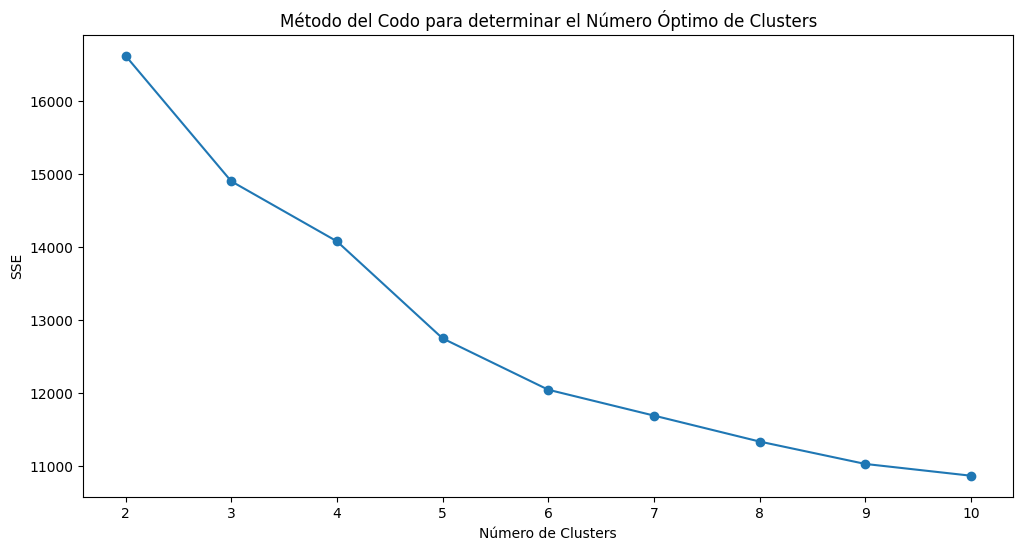

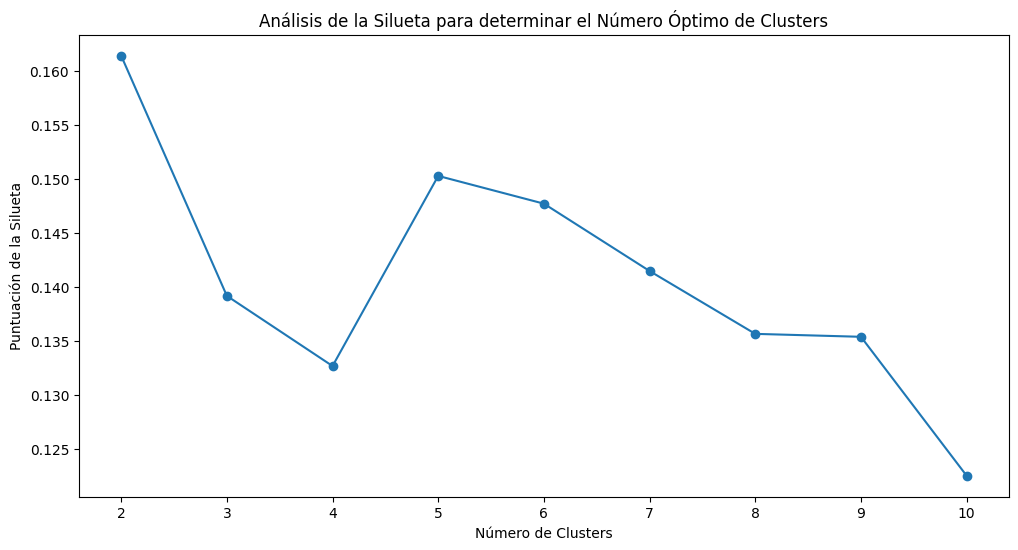

Número óptimo de clusters según el análisis de la silueta: 2


In [ ]:
categorical_cols = cleaned_df.select_dtypes('object').columns
numeric_cols = cleaned_df.drop(columns=categorical_cols).columns

for column in categorical_cols:
    transformed_data[column] = cleaned_df[column]

clustering_analysis = ClusteringAnalysis(transformed_data, categorical_cols, transformed_data.columns.drop(categorical_cols))
clustering_analysis.preprocess_data()
clustering_analysis.determine_optimal_clusters()

Observamos que el número de clusters óptimo según el análisis de la silueta es 2. No obstante, en aras de ejemplificar un caso quizás más interesante a la hora de interpretar los resultados y extraer las conclusiones finales, vamos a determinar que el número de clusters en los que dividiremos nuestros datos sea 3.

In [ ]:
clustering_analysis.execute_clustering(n_clusters=3)

C:\Users\aruizart\AppData\Local\Temp\ipykernel_59608\2883699026.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




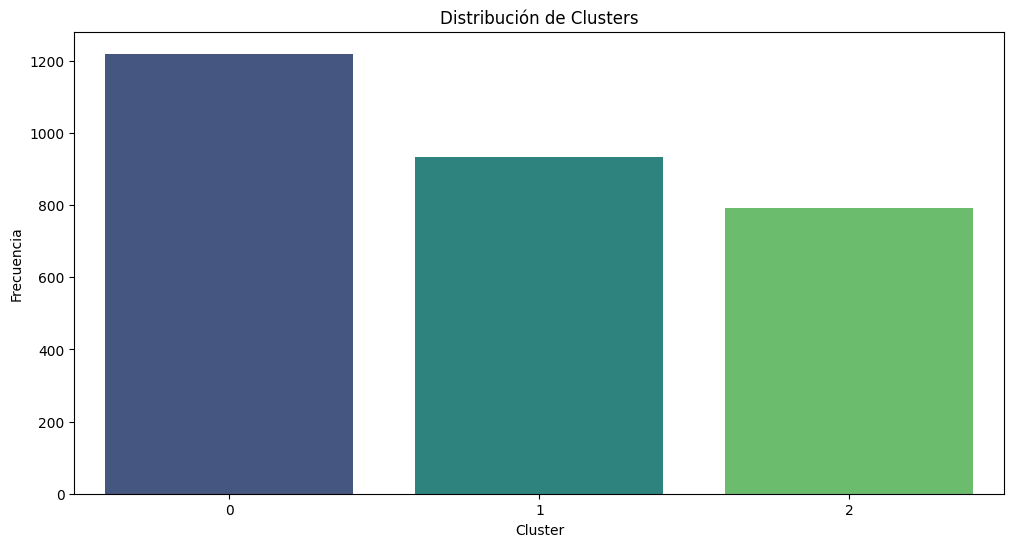

In [ ]:
clustering_analysis.plot_cluster_distribution()

In [ ]:
cleaned_df['cluster'] = clustering_analysis.df['Cluster']

In [ ]:
def analyze_clusters(df):
    # Análisis de características de clusters normalizado
    for col in df.columns:
        if col != 'cluster' and col != 'survey_variability':
            plt.figure(figsize=(12, 6))
            cluster_counts = df.groupby(['cluster', col]).size().reset_index(name='counts')
            cluster_sizes = df['cluster'].value_counts().reset_index(name='size')
            cluster_sizes.columns = ['cluster', 'size']
            cluster_counts = cluster_counts.merge(cluster_sizes, on='cluster')
            cluster_counts['proportion'] = cluster_counts['counts'] / cluster_counts['size']

            sns.barplot(x='cluster', y='proportion', hue=col, data=cluster_counts, palette='viridis')
            plt.title(f'Proporción de {col} por Cluster')
            plt.xlabel('Cluster')
            plt.ylabel('Proporción')
            plt.legend(title=col)
            plt.show()

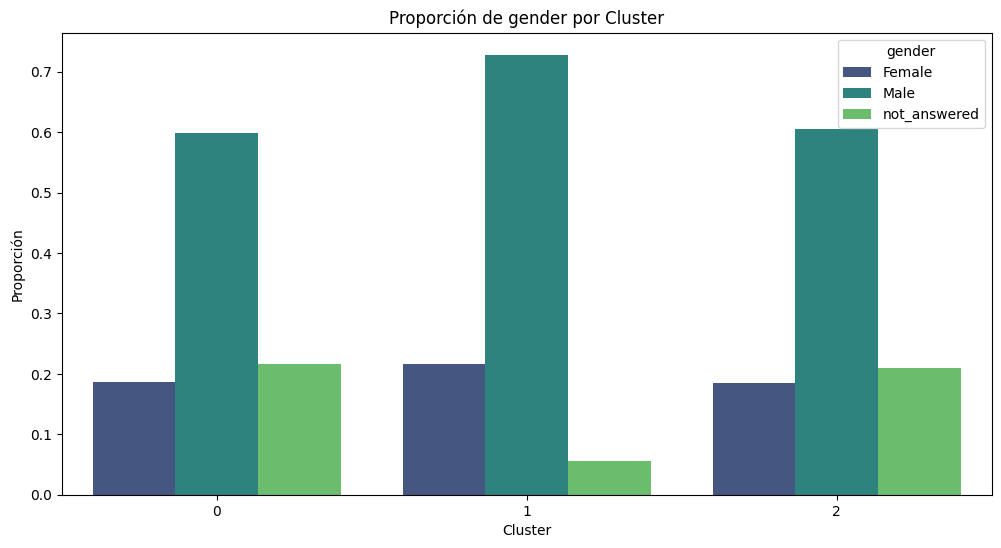

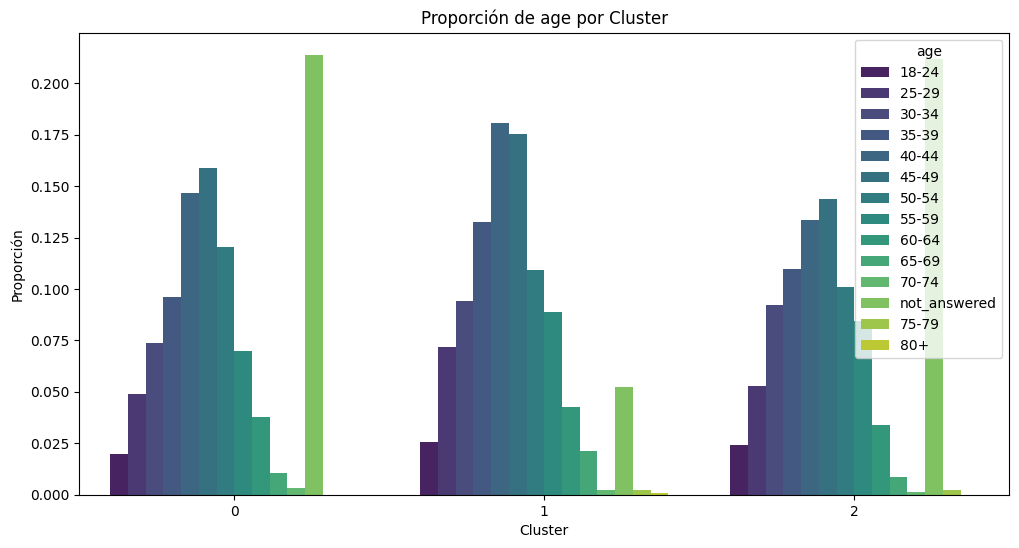

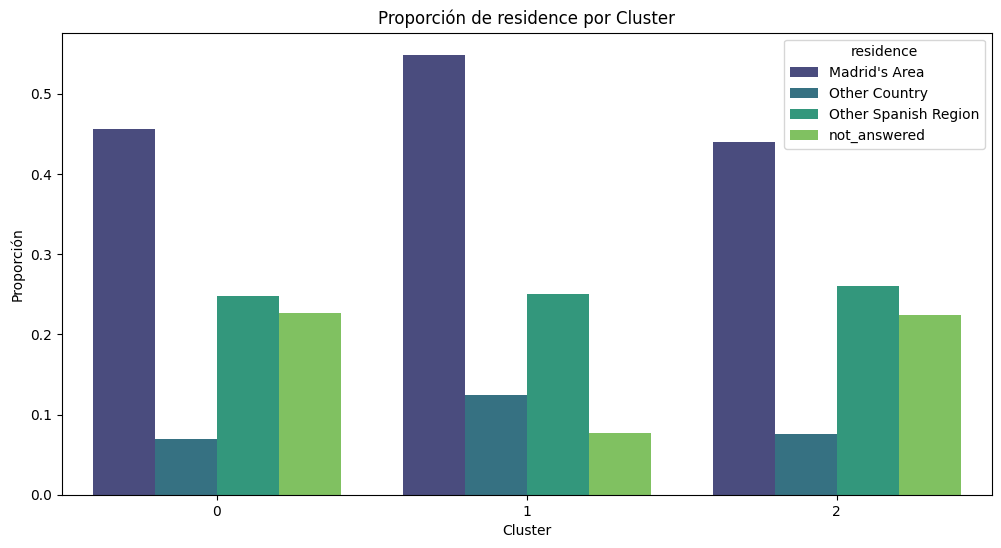

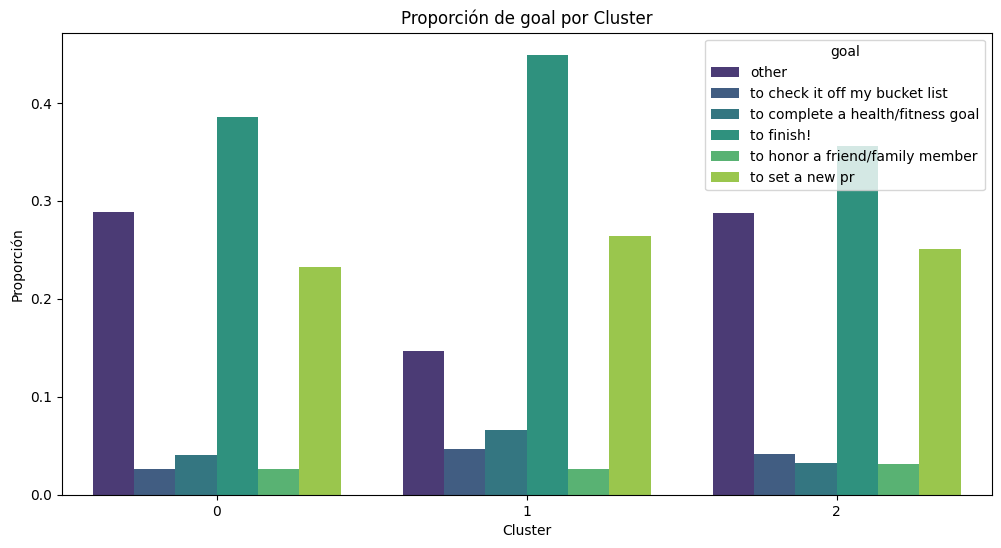

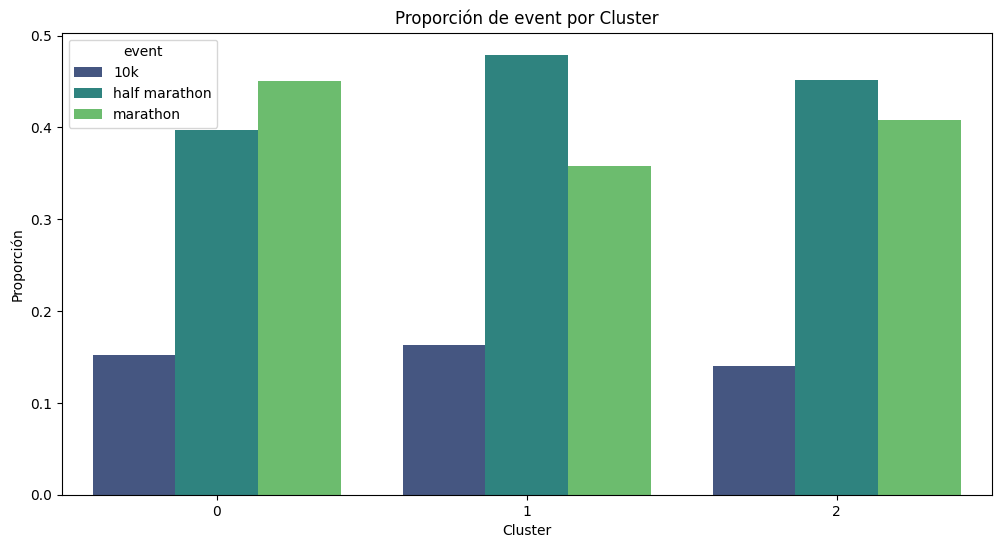

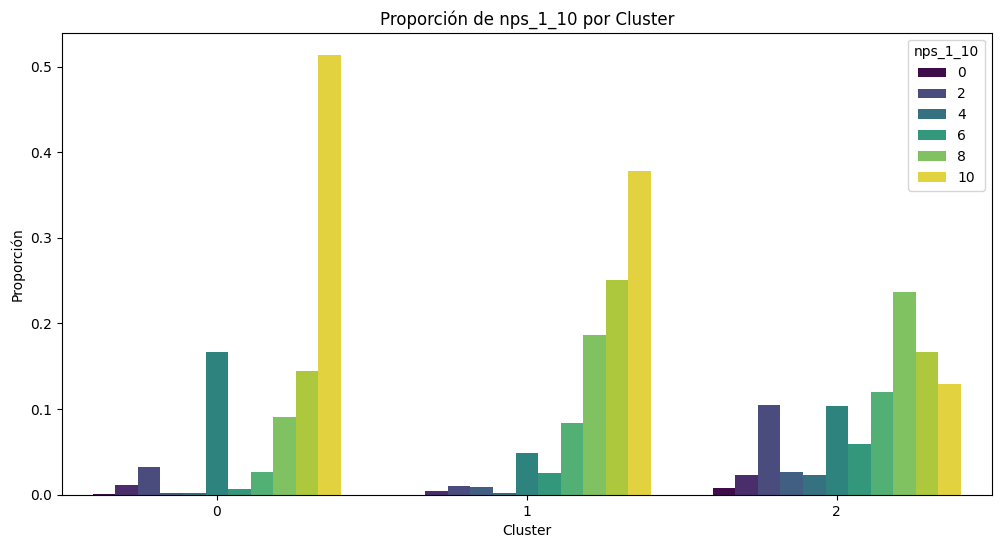

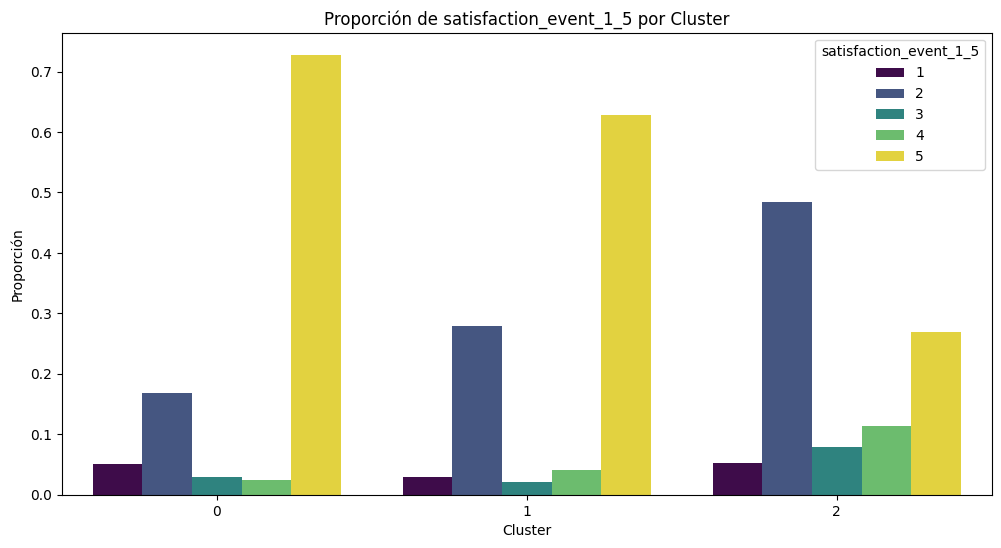

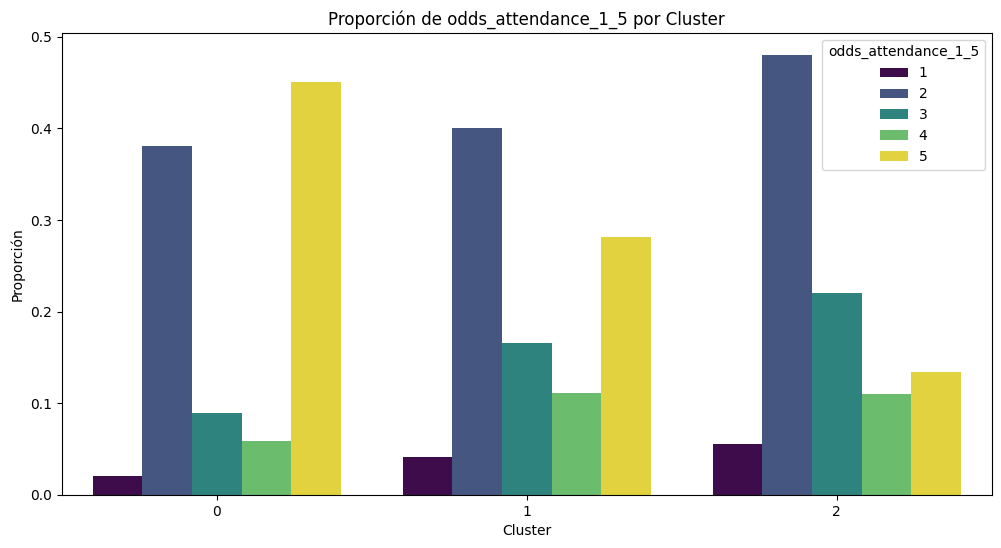

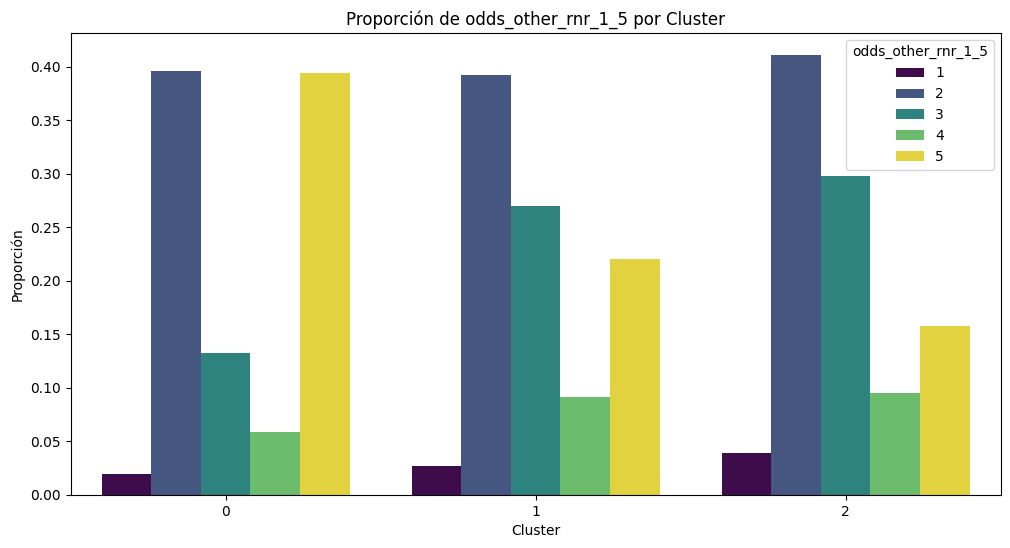

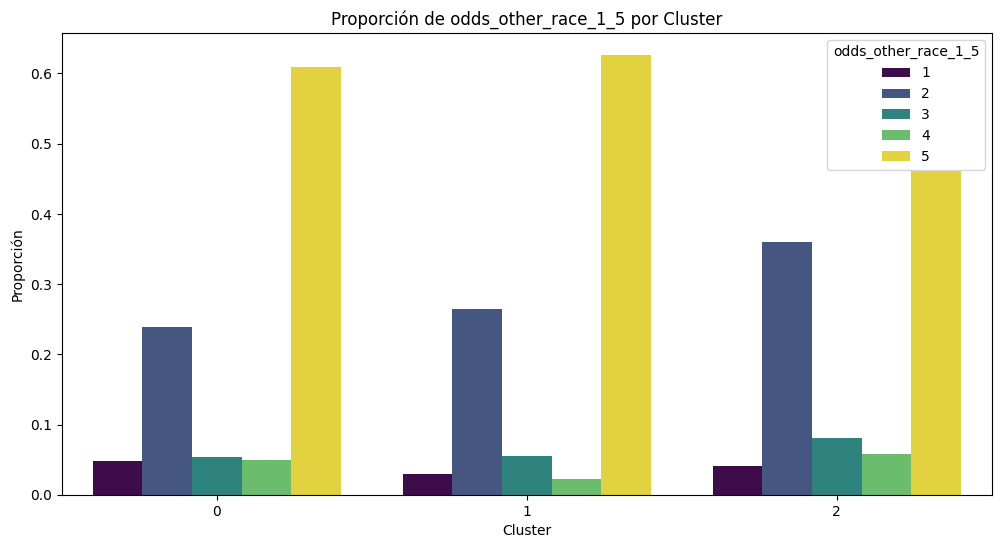

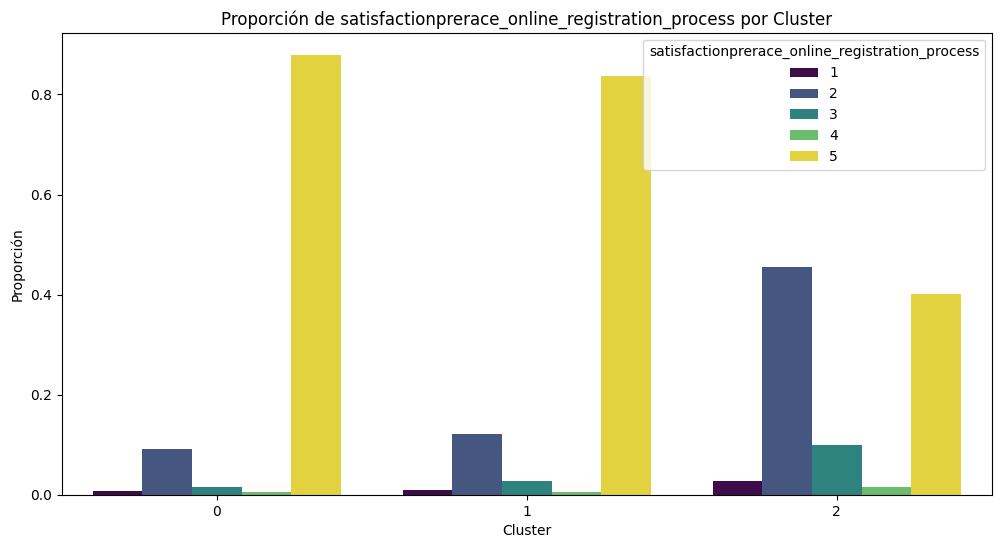

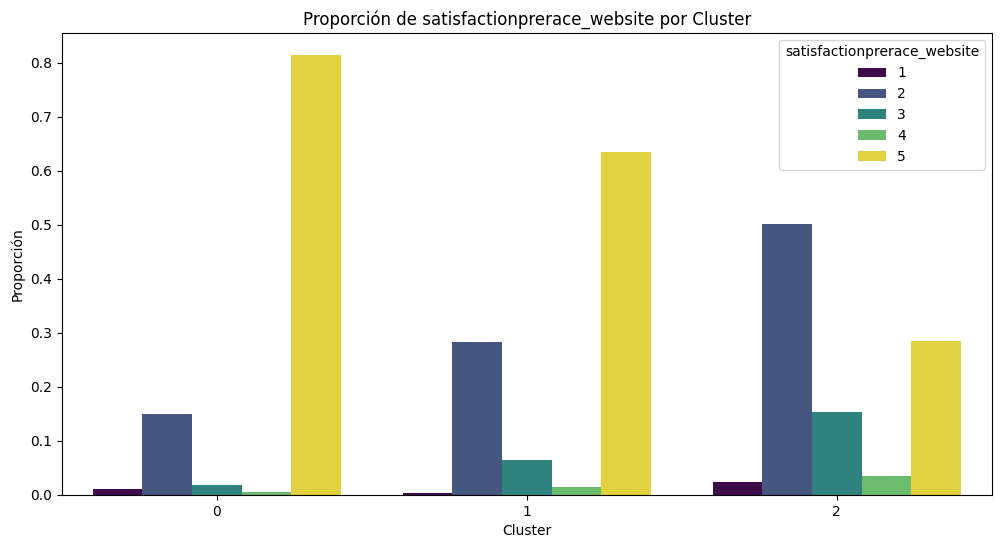

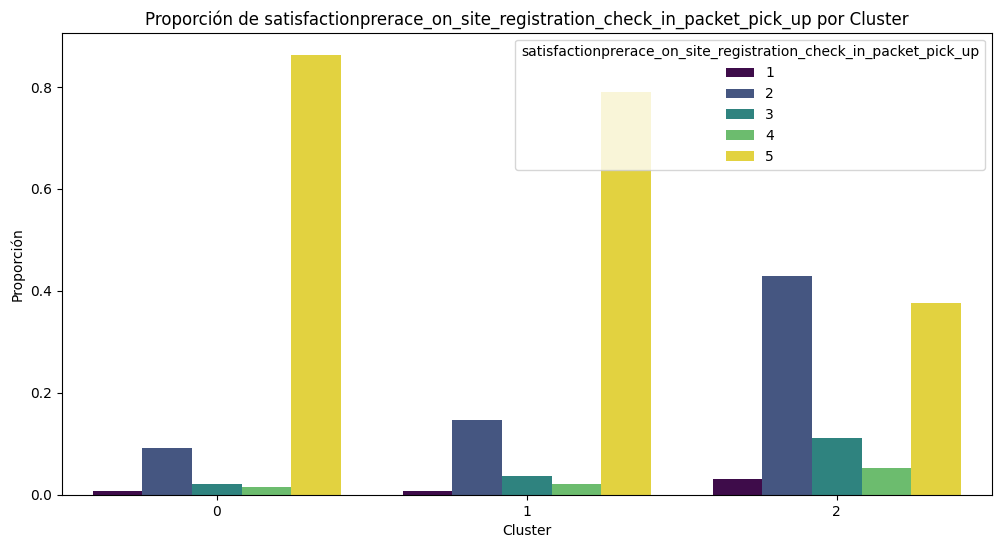

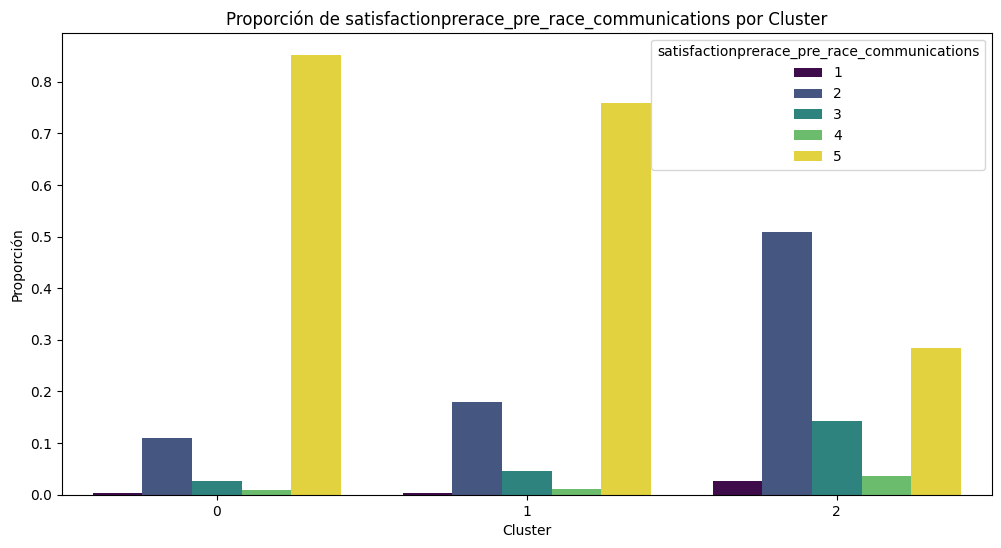

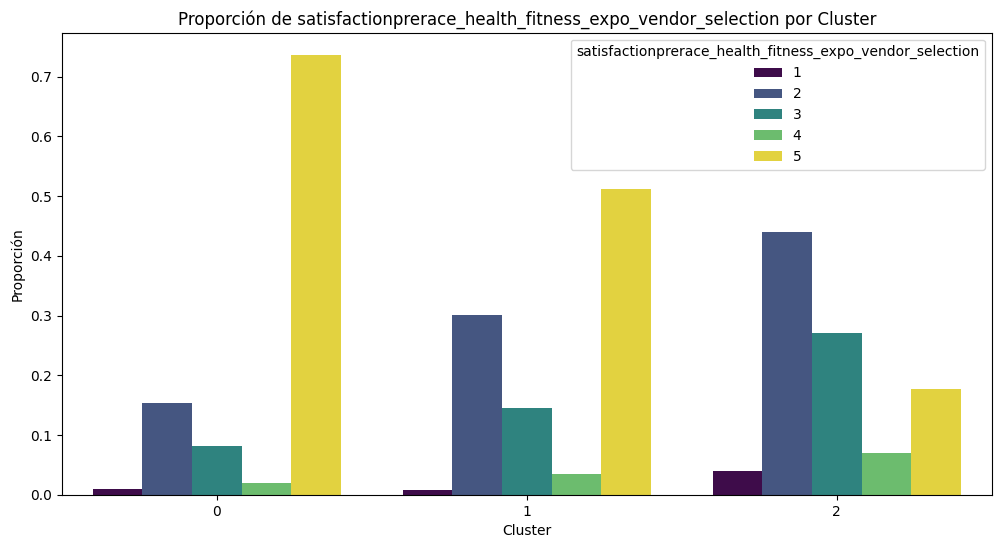

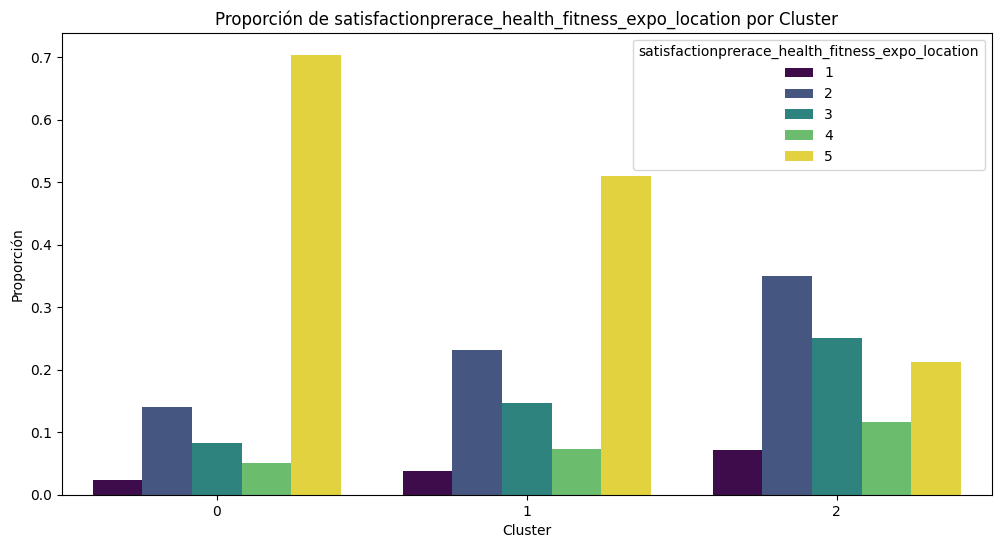

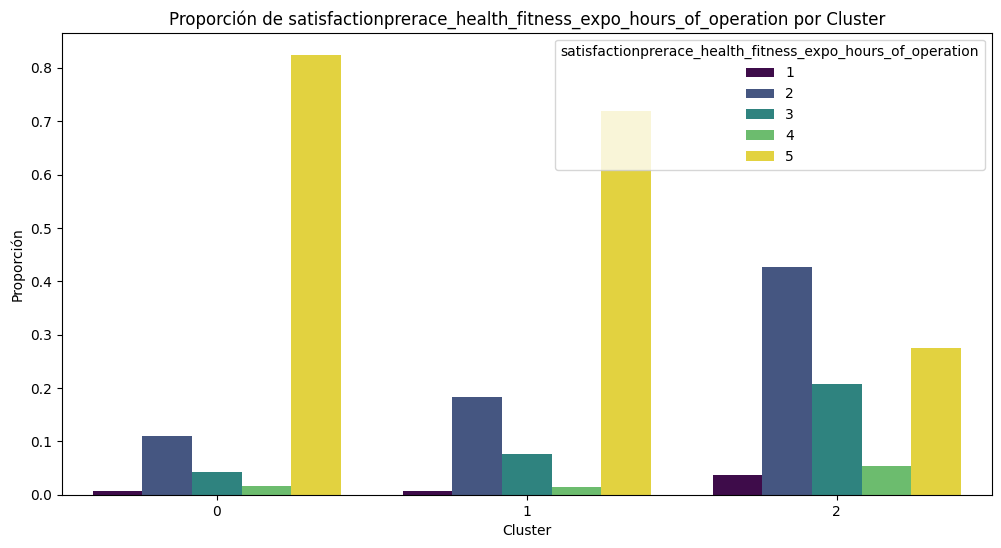

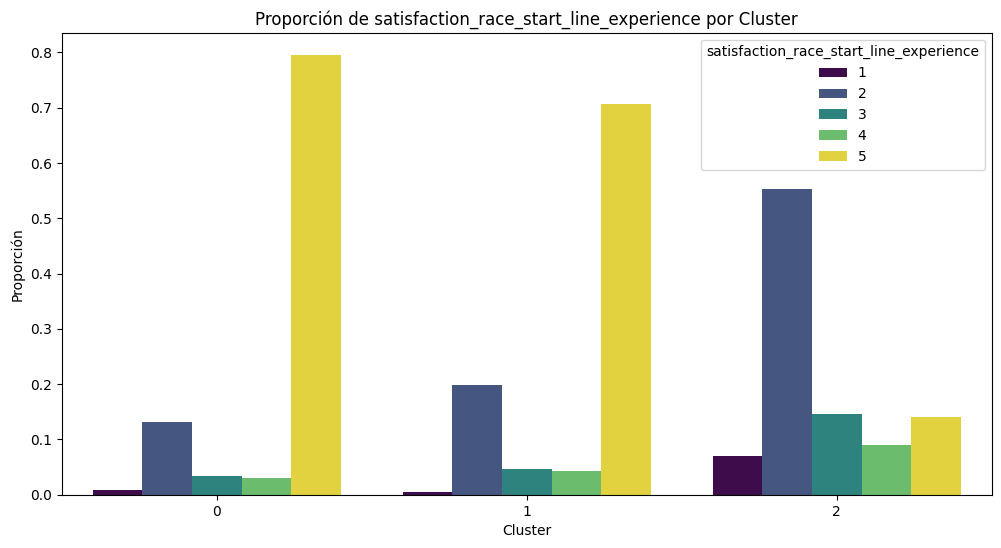

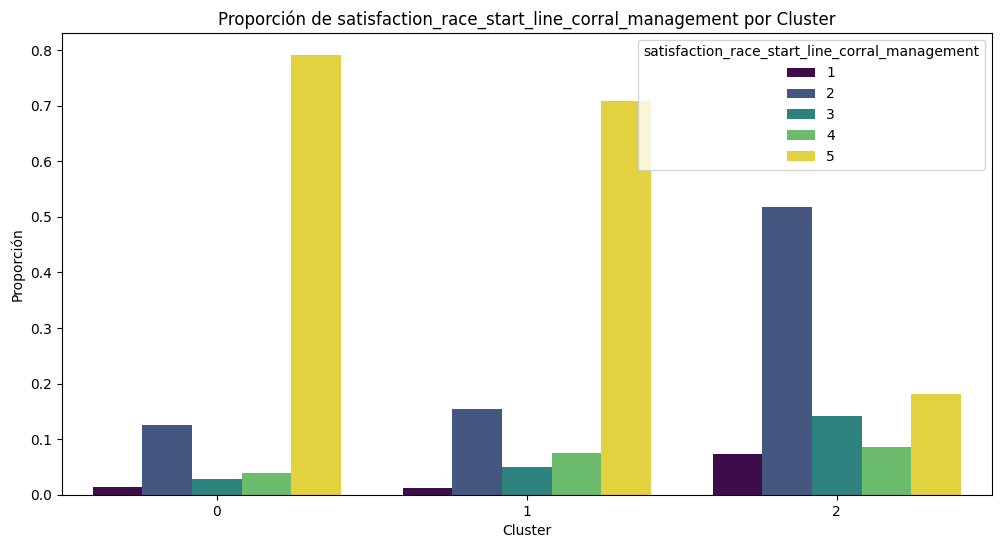

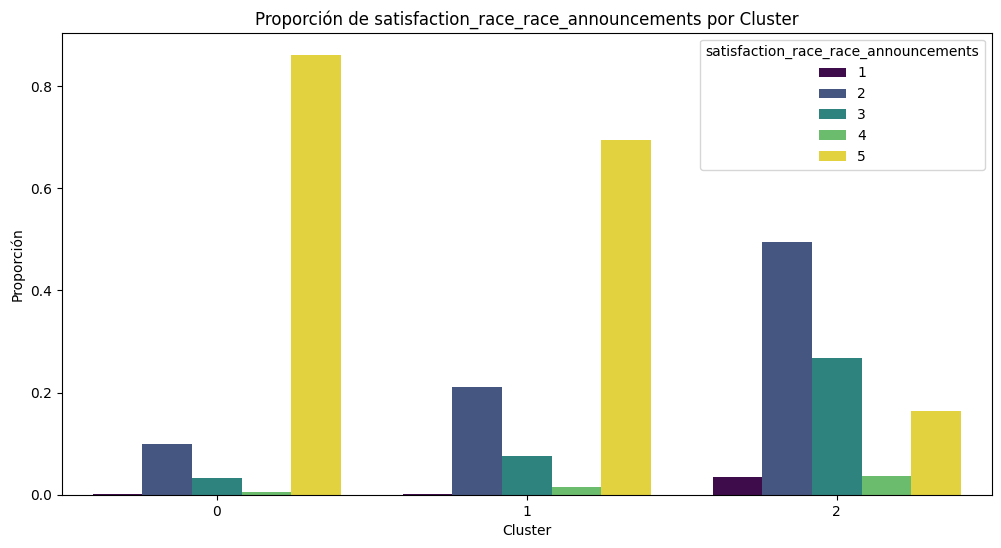

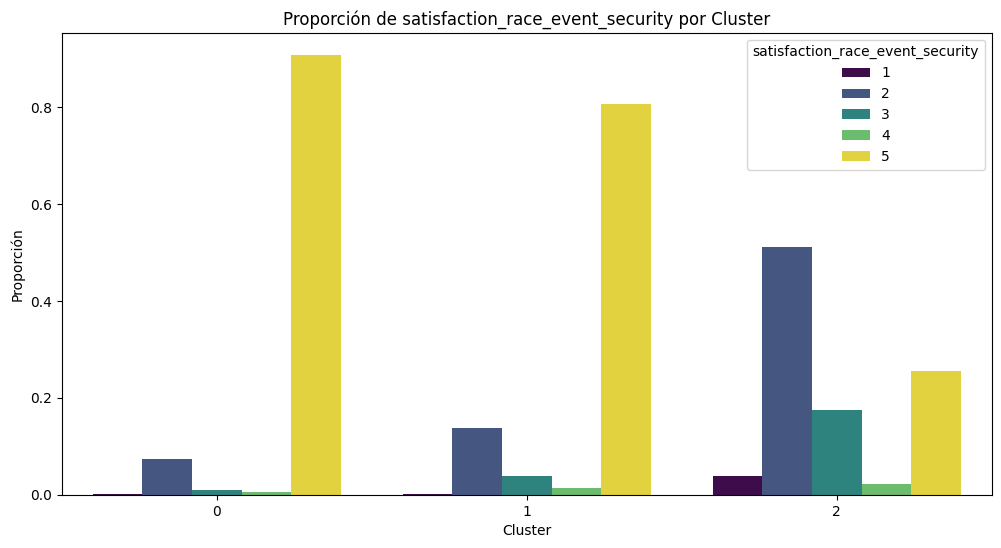

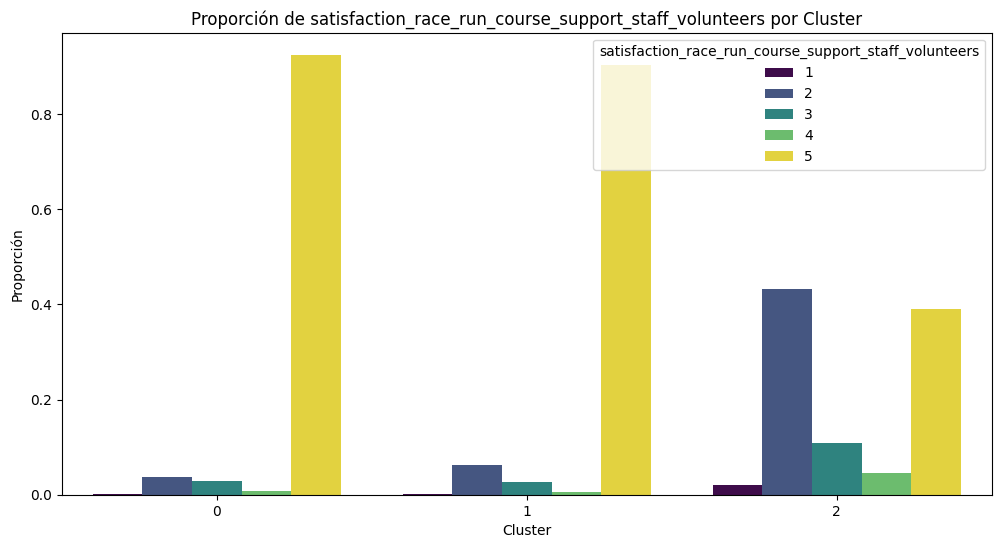

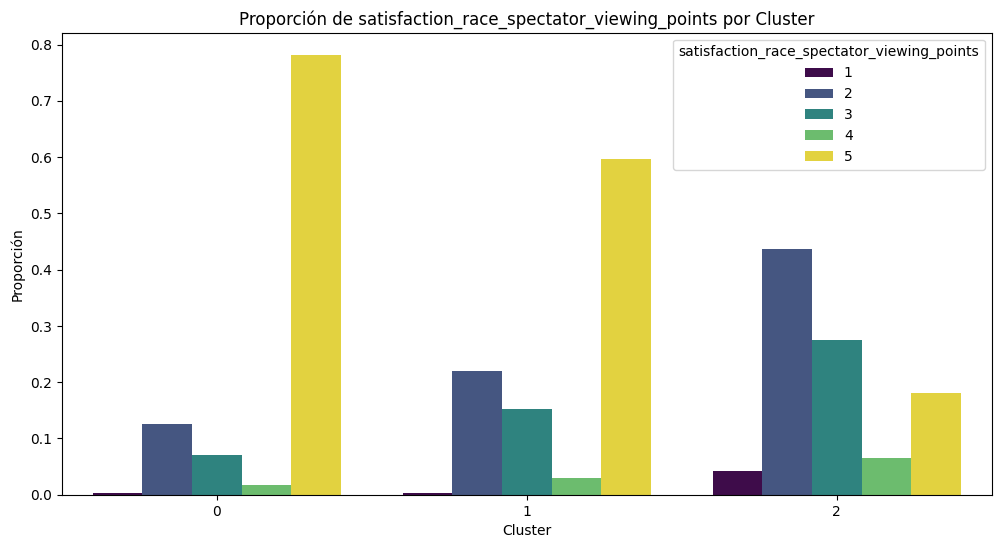

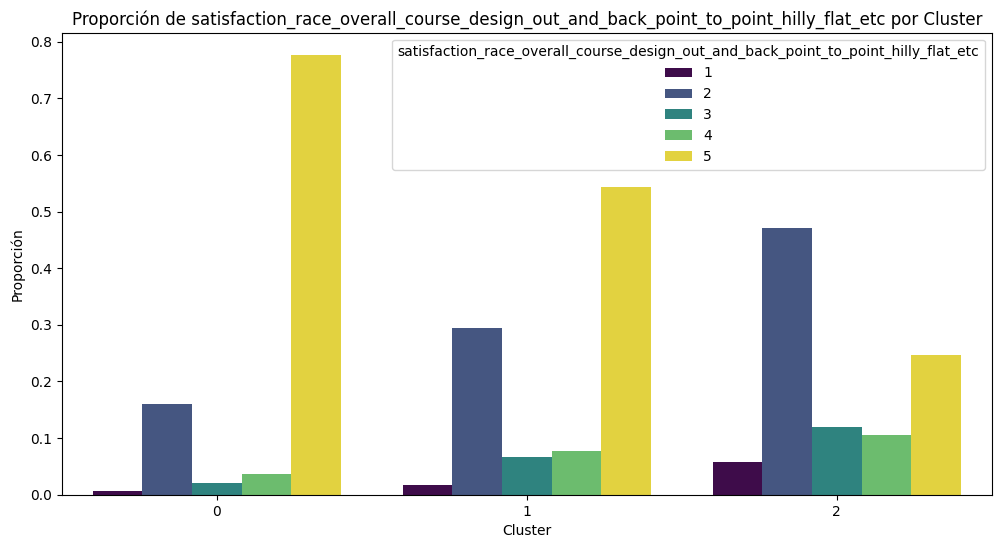

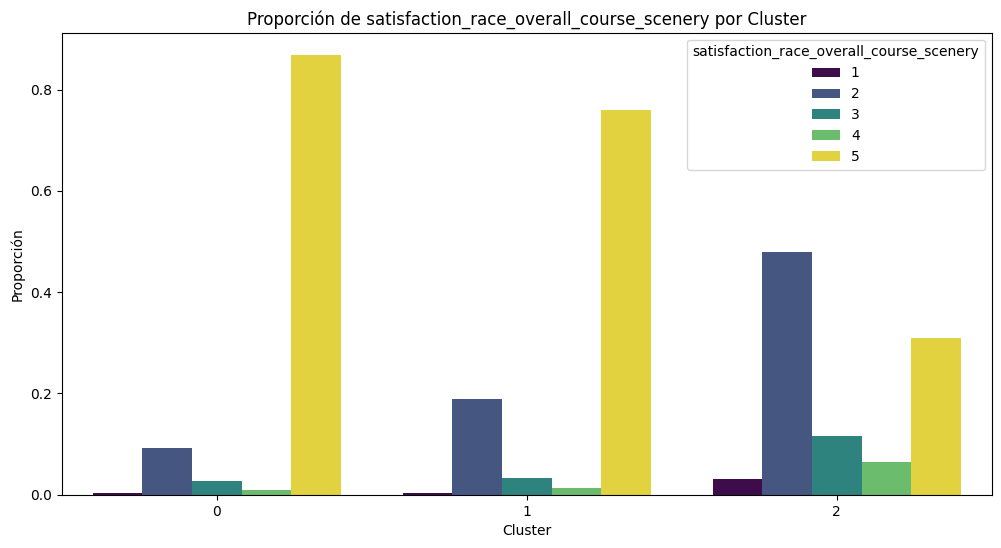

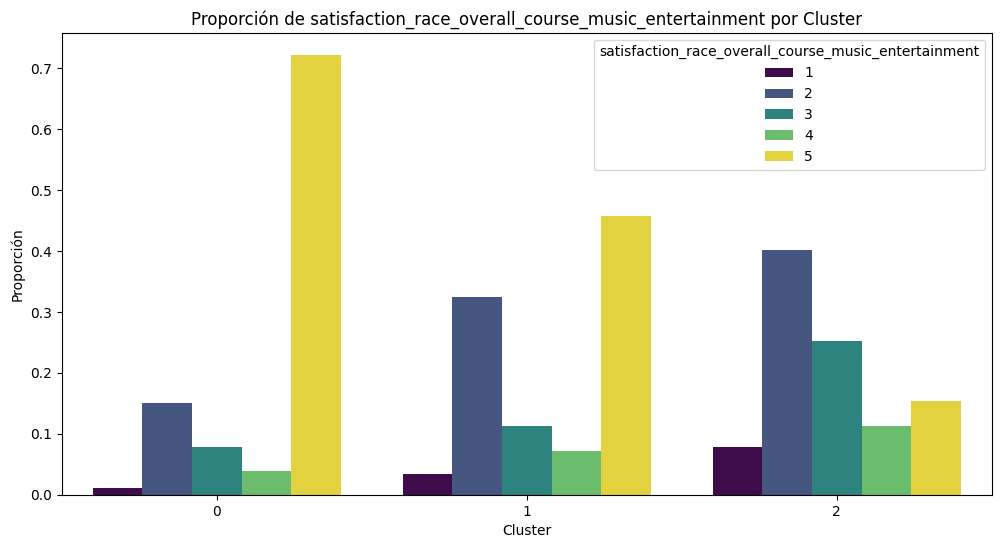

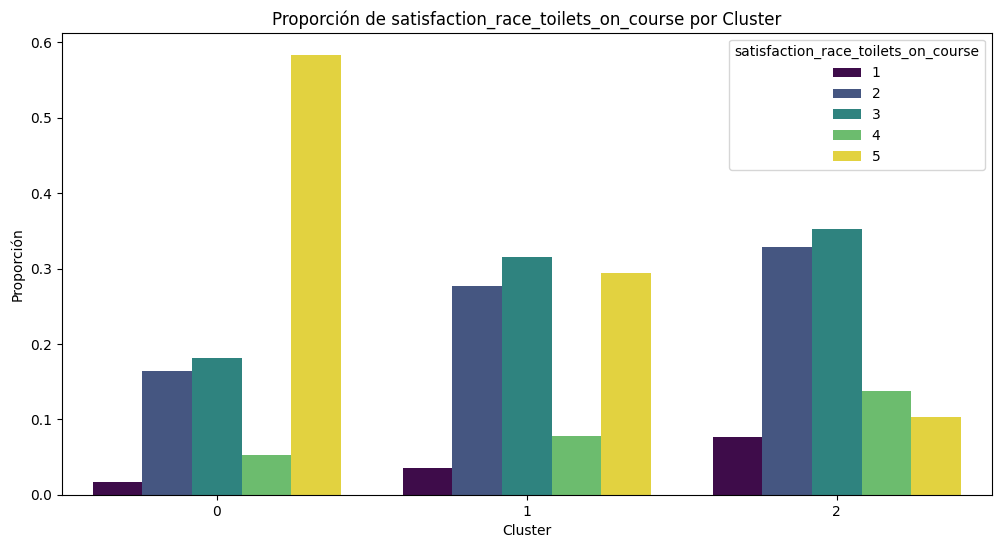

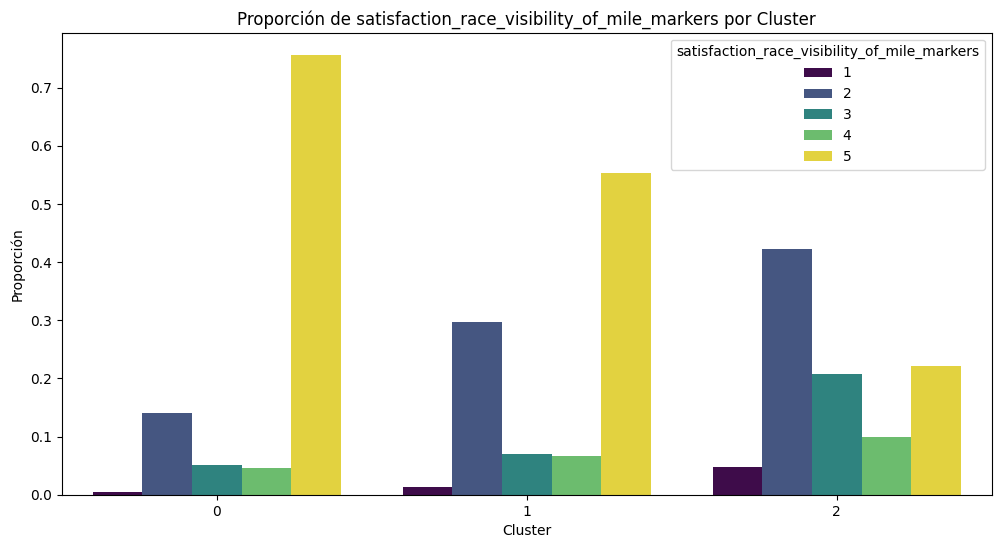

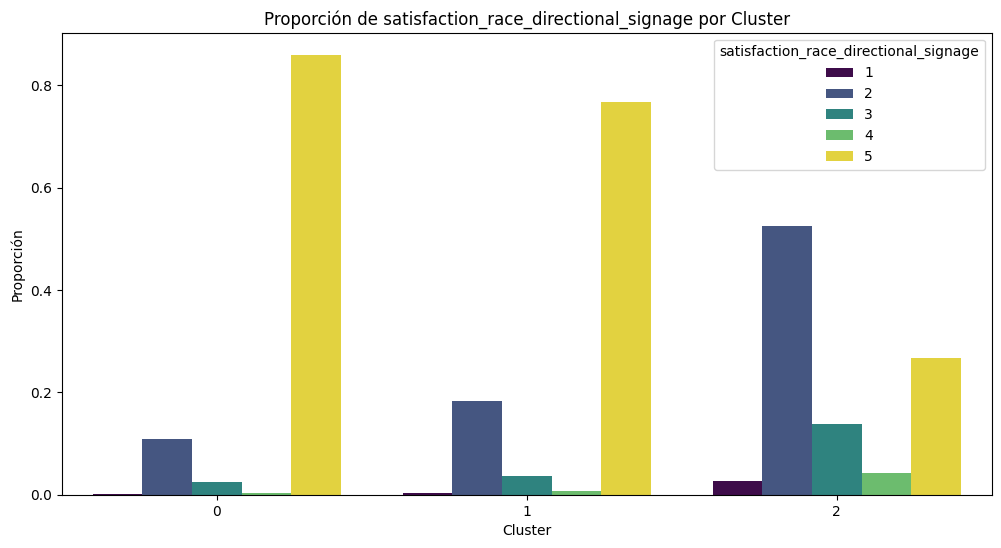

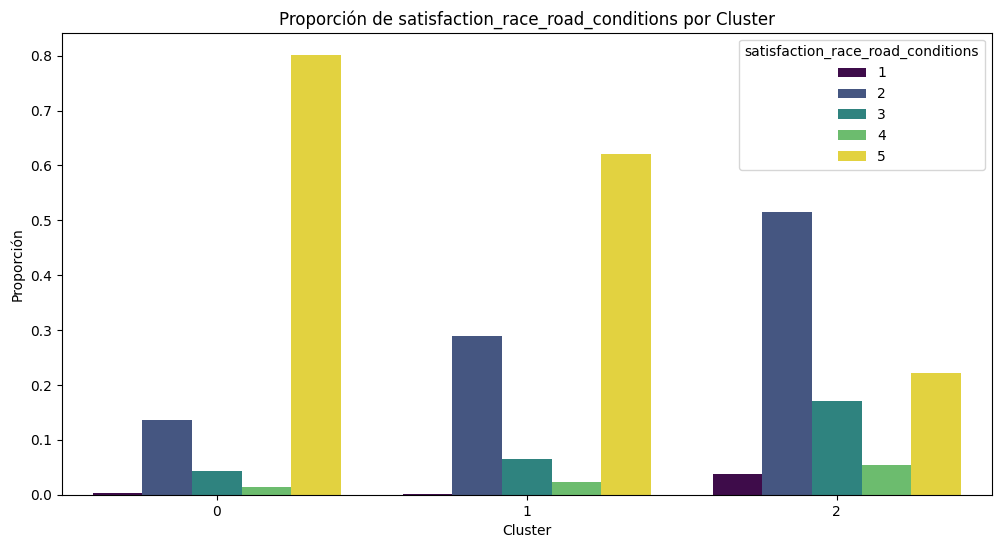

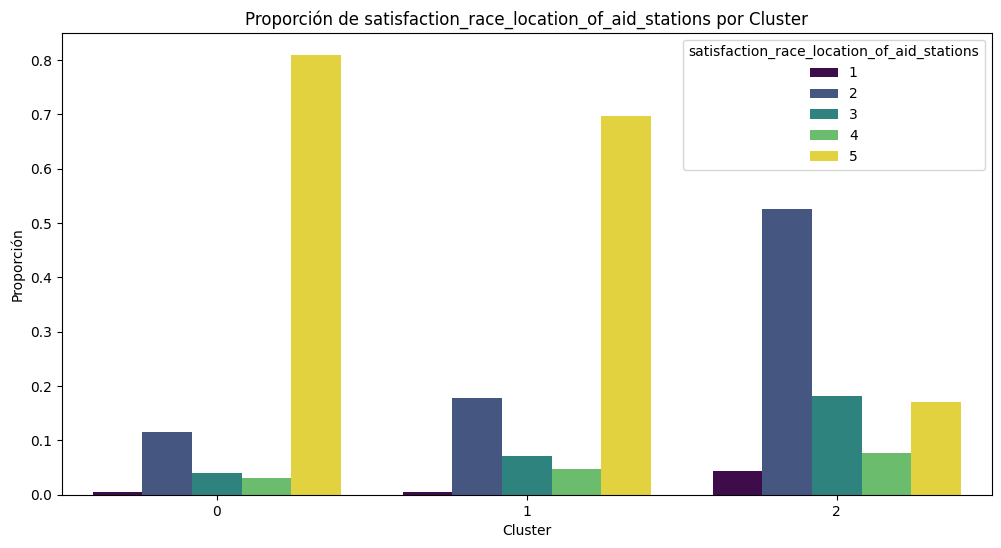

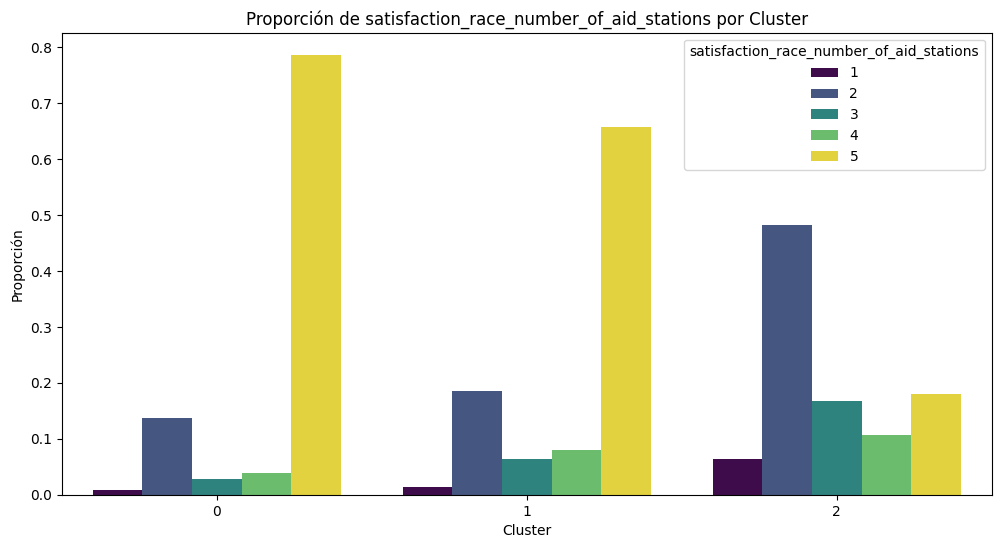

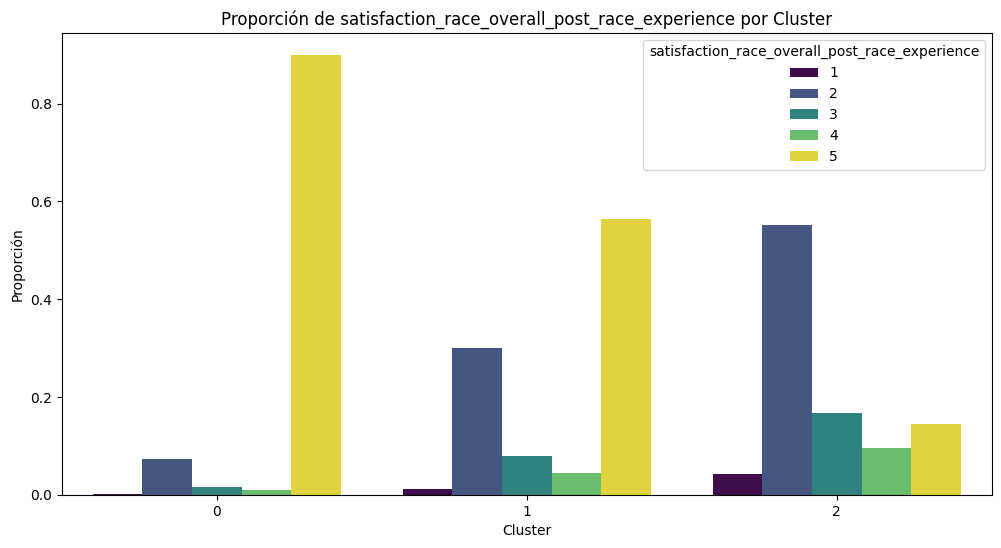

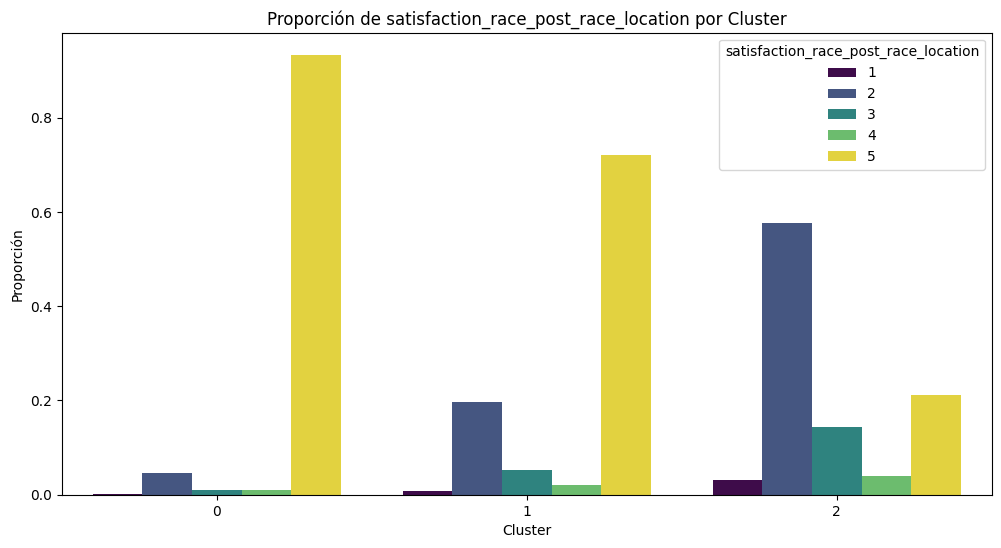

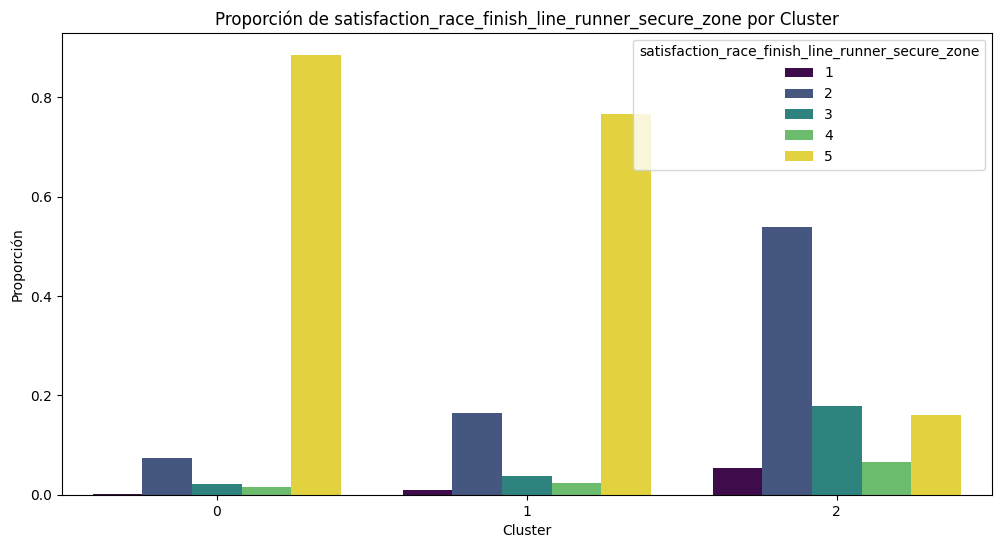

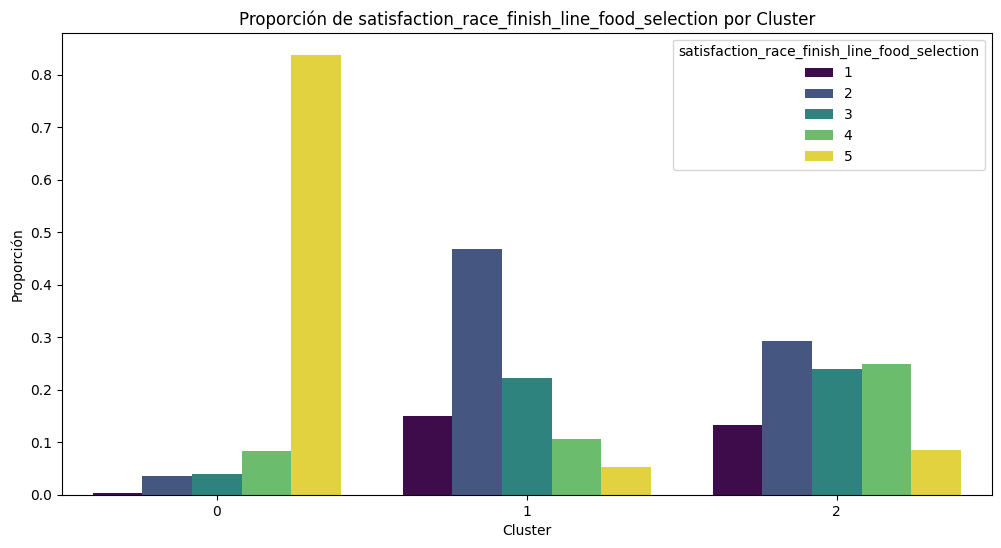

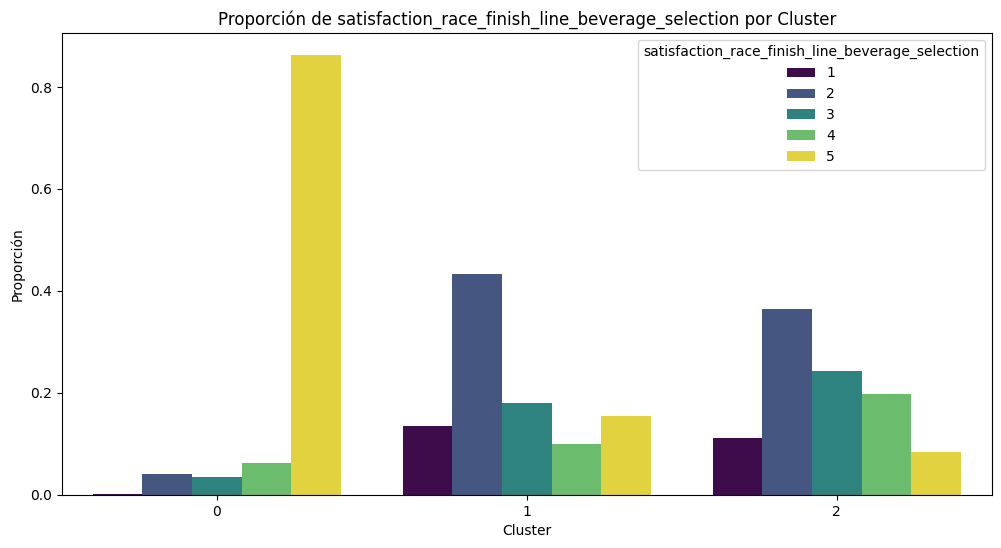

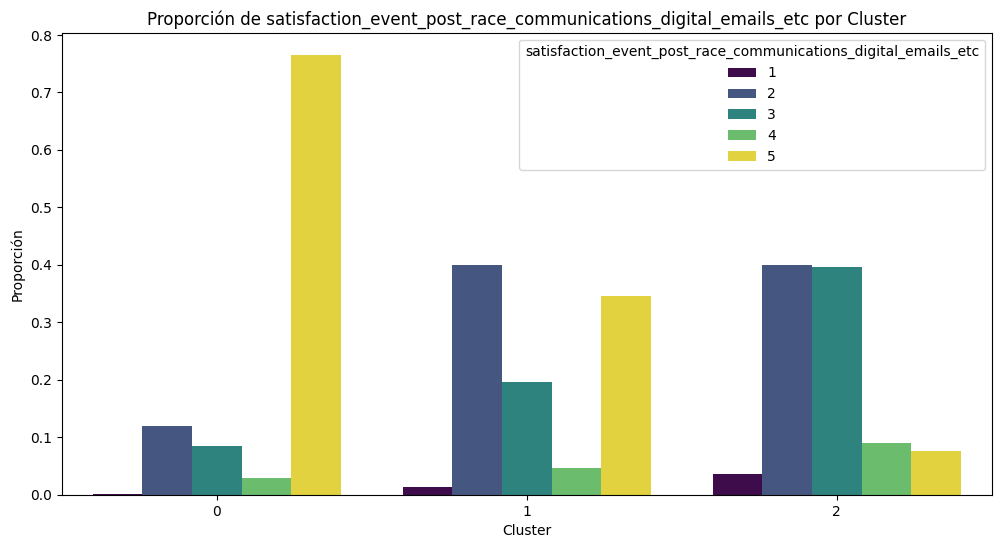

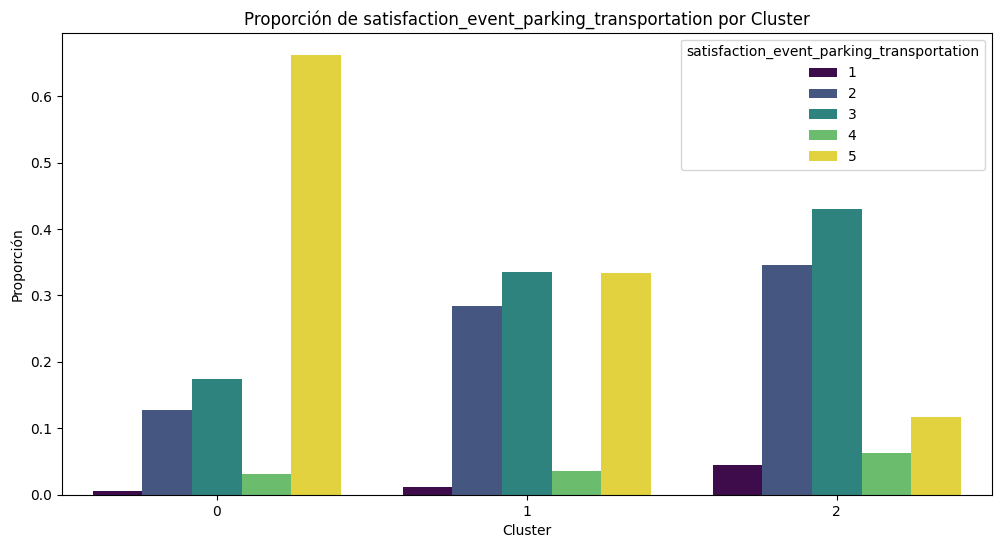

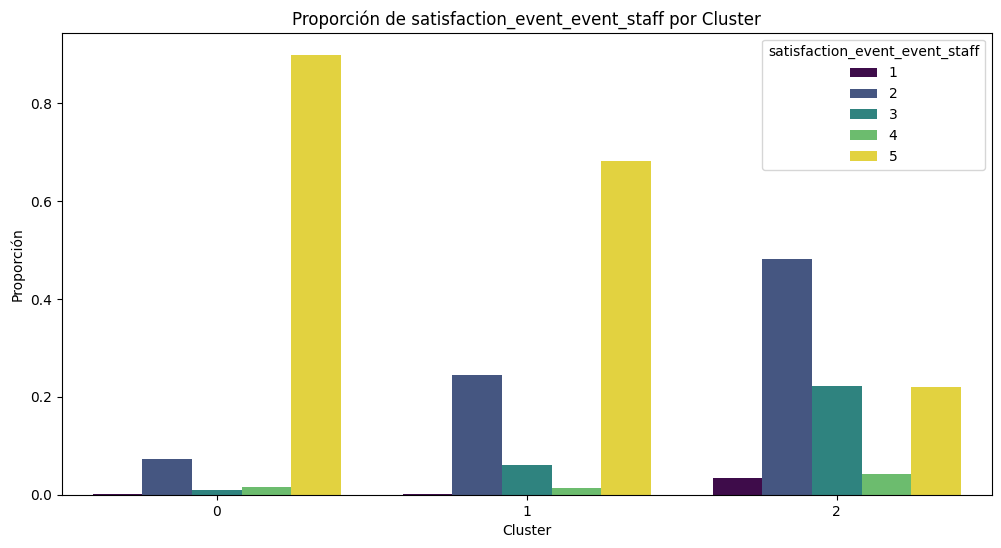

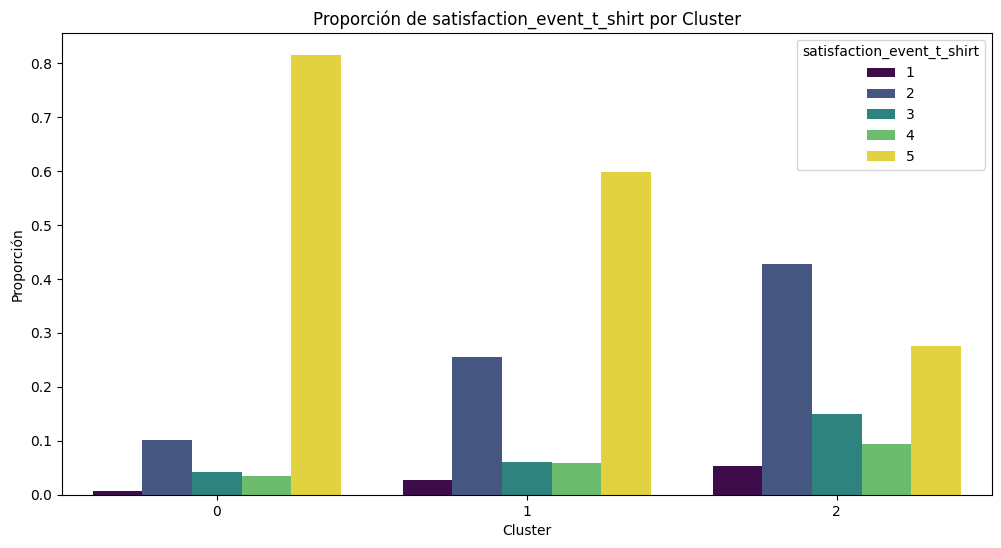

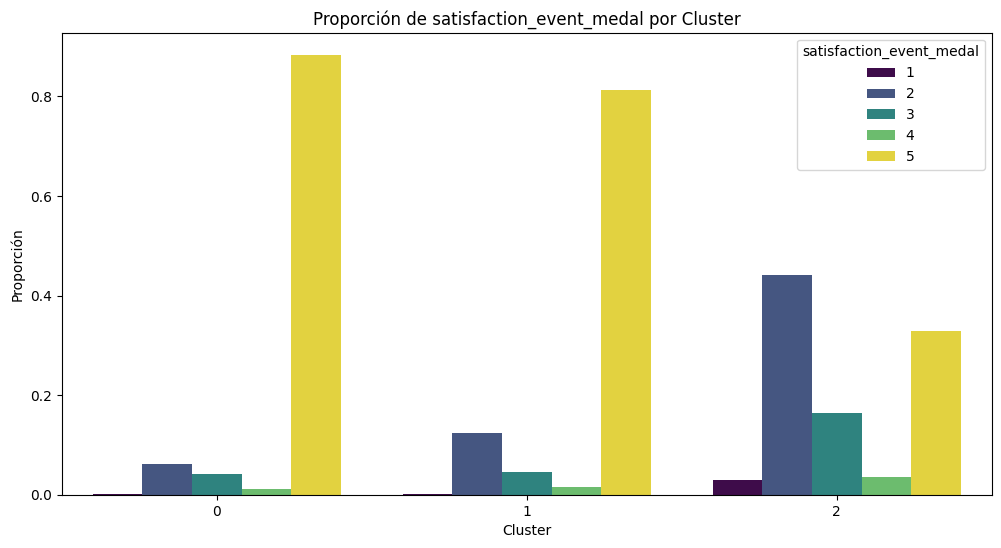

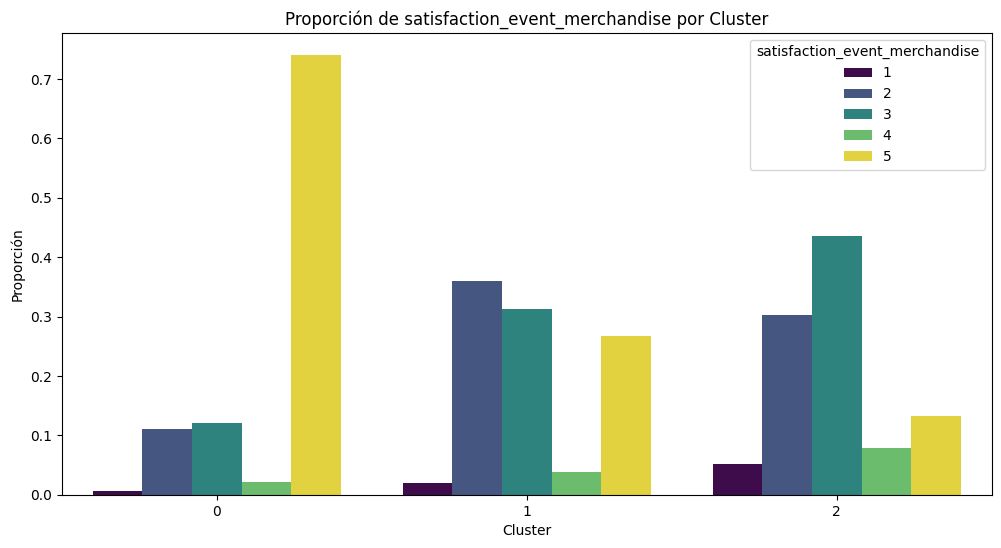

In [ ]:
analyze_clusters(cleaned_df)

# 6. Interpretación y Comunicación de Resultados

**Índice de contenido**

- [6.1. Interpretación de Clusters]()
- [6.2. Conclusiones Finales]()

## 6.1. Interpretación de Clusters

En este análisis se han identificado tres clusters distintos de participantes en base a sus respuestas en la encuesta de satisfacción del evento. Cada cluster presenta características únicas que nos permiten entender mejor las percepciones y experiencias de los participantes.

### 6.1.1. Cluster 2: _"Críticos Consistentes"_

Este grupo se caracteriza por una alta insatisfacción general. La mayoría de los participantes en este cluster otorgaron puntuaciones muy bajas en el _Net Promoter Score_ (NPS), con la mayoría de las calificaciones en el rango de 1 a 4. Esto indica que es poco probable que recomienden el evento a otros.

En término de satisfacción del evento, los participantes de este cluster muestran una marcada insatisfacción en varias áreas crísticas. Por ejemplo, la **seguridad del evento** y la **gestión en la línea de salida** recibieron puntuaciones muy bajas en comparación a otros grupos. Similarmente, la satisfacción con el **proceso de registro online** y la **comunicación previa a la carrera** también fue baja, reflejando una experiencia negativa desde el inicio.

Las condiciones del recorrido, como las **condiciones de la carretera** y la **señalización direccional**, fueron áreas de gran insatisfacción para este grupo. Además, los servicios en la línea de meta, incluyendo la **selección de alimentos y bebidas** y la **zona de seguridad del corredor**, no cumplieron con las expectativas de los participantes.

### 6.1.2. Cluster 1: _"Participantes Neutrales"_

Los participantes de este cluster presentan una satisfacción moderada o neutral. Las puntuaciones del NPS para este grupo se encuentran predominantemente en el rango de 5 a 7, lo que sugiere una experiencia aceptable pero no destacable. En términos de satisfacción del evento, las respuestas son variadas pero tienden a concentrarse en la zona media, indicando que, aunque no tuvieron una experiencia negativa, tampoco estuvieron particularmente impresionados.

Este grupo mostró puntuaciones intermedias en todos los aspectos de la satisfacción del evento y del pre-evento, incluyendo el **proceso de registro online** y la **comunicación previa a la carrera**. Las condiciones del recorrido, como las **condiciones de la carretera** y la **señalización direccional**, también recibieron puntuaciones intermedias.

En cuanto a los servicios en la línea de meta, la satisfacción con la **selección de alimentos y bebidas** y la **zona de seguridad del corredor** fue variada, pero con una tendencia hacia la media. En resumen, los participantes de este cluster tuvieron una experiencia adecuada, sin extremos de satisfacción o insatisfacción.

### 6.1.3. Cluster 0: _"Fans Entusiastas"_

Este cluster se destaca por su alta satisfacción con todos los aspectos evaluados. Los participantes de este grupo dieron las puntuaciones más altas en el NPS, con la mayoría de las calificaciones en el rango de 8 a 10, lo que indica una gran probabilidad de recomendar el evento a otros.

La satisfacción del evento en este cluster es notablemente alta, especialmente en áreas como la **seguridad del evento**, la **gestión en la línea de salida** y la **experiencia general en la línea de salida**. Estos participantes también mostraron una alta satisfacción con el **proceso de registro online** y la **comunicación previa a la carrera**, sugiriendo una experiencia fluida y bien gestionada desde el inicio.

Las condiciones del recorrido fueron bien valoradas, con altas puntuaciones en las **condiciones de la carretera** y la **señalización direccional**. En términos de servicios en la línea de meta, la **selección de alimentos y bebidas** y la **zona de seguridad del corredor** también recibieron altas puntuaciones, reflejando una experiencia positiva hasta el final del evento.

## 6.2. Conclusiones Finales

En conclusión, este análisis clustering nos ha permitido identificar diferentes grupos de participantes con percepciones y experiencias únicas sobre el evento. Esta información es crucial para entender mejor las áreas de mejora y fortalecer los puntos fuertes del evento para futuras ediciones. Algunas recomendaciones para mejorar la experiencia de los asistentes y aumentar la satisfacción general en futuras ediciones podrían ser:

1. **Mejorar la seguridad del evento**
   
   La seguridad es un aspecto crucial que afecta la percepción general del evento. Los participantes en el cluster de los "Críticos Consistentes" han mostrado una notable insatisfacción en este aspecto. Se recomienda:

   - Aumentar la visbilidad y la presencia del personal de seguridad en todas las áreas del evento.
   - Implementar medidas de seguridad adicionales en las zonas críticas, como la línea de salida y la línea de meta.
   - Realizar simulacros de emergencia y comunicar claramente a los participantes los protocolos de seguridad.

2. **Optimizar el proceso de registro online**

   El registro online es el primer punto de contacto de muchos participantes con el evento. La insatisfacción en este aspecto puede influir negativamente en la percepción general del evento. Algunas recomendaciones son:

   - Simplificar el proceso de registro online, asegurando que sea rápido y sin complicaciones.
   - Mejorar la comunicación previa a la carrera, proporcionando información clara y oportuna sobre el evento y los requisitos de participación.
   - Implementar un sistema de confirmación y recordatorio automatizado para mantener informados a los participantes.

3. **Mejorar las condiciones del recorrido**

   Las condiciones del recorrido son una parte fundamental de la experiencia del corredor. Los participantes han mostrado insatisfacción en áreas como la señalización direccional y las condiciones de la carretera. Algunas recomendaciones de mejora podrían ser:
   
   - Asegurarse de que todas las señales direccionales sean claramente visibles y estén correctamente ubicadas.
   - Mejorar las condiciones de las carreteras y senderos utilizados en el recorrido, reparando baches y eliminando obstáculos.
   - Incluir más puntos de información en el recorrido para orientar a los corredores y proporcionar asistencia si es necesario.

4. **Optimizar los servicios en la línea de meta**

   La experiencia en la línea de meta es crucial para dejar una impresión duradera en los participantes. La satisfacción con la selección de alimentos y bebidas y la zona de seguridad del corredor debe ser una prioridad. Se recomienda:

   - Ampliar la variedad y calidad de los alimentos y bebidas disponibles en la línea de meta.
   - Asegurar que la zona de seguridad del corredor sea accesible y esté bien equipada para proporcionar una recuperación adecuada tras la carrera.
   - Considerar la implementación de encuestas en tiempo real en la línea de meta para obtener feedback inmediato y poder hacer ajustes rápidos si es necesario.

5. **Mejorar la experiencia general del evento**

   La experiencia general del evento incluye varios aspectos, desde la comunicación post-carrera hasta la interacción con el personal del evento. Algunas recomendaciones son:
   
   - Mejorar la calidad de las comunicaciones post-carrera, asegurándose de que sean informativas y relevantes para los participantes.
   - Revisar y mejorar los detalles logísticos del evento, como el estacionamiento y el transporte, para garantizar una experiencia fluida y sin estrés.

6. **Escuchar y actuar sobre el _feedback_ de los participantes**

   Es crucial que la empresa organizadora no solo recoja el _feedback_ de los participantes, sino que también actúe sobre él. Se recomienda:
   
   - Implementar un sistema de retroalimentación continuo que permita a los participantes compartir sus experiencias y sugerencias.
   - Analizar regularmente los datos de satisfacción y realizar ajustes basados en las necesidades y deseos de los participantes.
   - Comunicarse con los participantes para informarles sobre las mejoras realizadas en base a su _feedback_, lo que puede aumentar la lealtad y la satisfacción general.


Implementar estas recomendaciones puede significativamente mejorar la percepción y la satisfacción de los participantes en futuros eventos. Al centrarse en la seguridad, la experiencia del recorrido, el registro online, y los servicios en la línea de meta, la empresa organizadora puede garantizar que cada participante tenga una experiencia positiva y memorable. Escuchar y actuar sobre el _feedback_ de los participantes asegurará que el evento evolucione continuamente para satisfacer las expectativas de los corredores.